<a href="https://colab.research.google.com/github/deepakri201/neurips_nlst_totalsegmentator/blob/main/NeurIPS_Datasets_and_Benchmarks_NLST_TotalSegmentator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NeurIPS Datasets and Benchmarks TotalSegmentator Analysis of NLST


---

This notebook provides the code that is needed to reproduce the figures in the paper submitted to NeurIPS Datasets and Benchmarks track. To reproduce, follow this link to obtain a GCP project id.



---




Deepa Krishnaswamy and Vamsi Krishna Thiriveedhi

Brigham and Women's Hospital

May 2024



---



In [1]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [2]:
import os
import sys
import time
import json
import subprocess
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sb
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

from collections import OrderedDict

import seaborn as sns

from pathlib import Path

import random

import collections
import scipy

In [3]:
!pip install bokeh==2.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successfully uninstalled bokeh-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.3.8 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 2.4.3 which is incompatible.


In [4]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show, save
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row

from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png

In [5]:
import bokeh
bokeh.__version__

'2.4.3'

# Parameterization

In [6]:
table_id = "idc-external-025.neurIPS_totalseg.quantitative_measurements_and_clinical_data"

In [7]:
# table_id = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa"

In [8]:
# table_id = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa" # includes left/right laterality and smoking status
# table_id_126k = "idc-external-025.terra.nlst-126k-measurements-clinical-acquisition"
# table_id_10k = "idc-external-025.terra.10k-series-data-061023-measurements-clinical-viewer_table_Deepa" # includes left/right laterality and smoking status

# Functions

In [9]:
def color_list_generator(df, col):
  """

  Create a list of colors per col given a dataframe

  Arguments:
    df    : dataframe to get data from
    col   : column to use to get unique treatments.

  Returns:
    colormap   : the colormap created
    colors     : the actual colors

  Inspired by creating colors for each treatment
  Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
  Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html

  """

  if (len(df[col].unique()))==1:
    colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
  elif (len(df[col].unique()))==2:
    colors = brewer["Dark2"][3][0:2]
  elif (len(df[col].unique()))>8:
    num_colors = len(df[col].unique())
    num_colormaps = np.int32(np.ceil(num_colors/8))
    colormap_chained = brewer["Dark2"][8]*num_colormaps
    colors = colormap_chained[0:num_colors]
  else:
    colors = brewer["Dark2"][len(df[col].unique())]

  # Create a map between treatment and color.
  colormap = {i: colors[k] for k,i in enumerate(df[col].unique())}

  # sort these according to the key
  colormap = collections.OrderedDict(sorted(colormap.items()))

  # Return a list of colors for each value that we will be looking at.
  return colormap, [colormap[x] for x in df[col]]

In [44]:
# This is the original query without applying any heuristics


def get_organ_feature(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
    SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    Value,
    lateralityModifier.CodeMeaning as laterality
  FROM
    `{table_id}` as clinical_table
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

# This is the query applying 1 heuristic, segmentation completeness

def get_organ_feature_with_segmentation_completeness_no_laterality(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
    SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    Value,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness_check,
    # segmentation_completeness.viewerUrl,
    # segmentation_completeness.SeriesNumber
  FROM
    `{table_id}` as clinical_table
  ### Heuristic 1 - segmentation completeness check ##### could remove later
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND
    segmentation_completeness_check = 'may_be_segmented_fully'
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

def get_organ_feature_with_segmentation_completeness(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
    SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    Value,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness_check,
    # segmentation_completeness.viewerUrl,
    # segmentation_completeness.SeriesNumber
  FROM
    `{table_id}` as clinical_table
  ### Heuristic 1 - segmentation completeness check ##### could remove later
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND # does not work??
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND
    segmentation_completeness_check = 'may_be_segmented_fully'
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df


def get_organ_feature_with_segmentation_completeness_and_one_connected_component(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
  SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness.totalsegSegmentLabel,
    Value,
    segmentation_completeness_check,
  FROM
    #`idc-external-025.neurIPS_totalseg.quantitative_measurements_and_clinical_data` as clinical_table
    `{table_id}` as clinical_table
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND # remove with organs with no laterality
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  JOIN
    `idc-external-025.neurIPS_totalseg.jsonRadiomics` as jsonRadiomics
  ON
    clinical_table.sourceSegmentedSeriesUID = jsonRadiomics.SeriesInstanceUID AND
    segmentation_completeness.totalsegSegmentLabel = jsonRadiomics.organ
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND # "Volume from Voxel Summation"
    segmentation_completeness_check = 'may_be_segmented_fully' AND
    jsonRadiomics.diagnostics_Mask_original_VolumeNum = 1
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df



# This is the query applying 2 heuristics, segmentation completeness and vertebrae at every slice

def get_organ_feature_with_segmentation_completeness_and_vertebrae_every_slice(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
    SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    Value,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness_check,
    # segmentation_completeness.viewerUrl,
    # segmentation_completeness.SeriesNumber
  FROM
    `{table_id}` as clinical_table
  ### Heuristic 1 - segmentation completeness check ##### could remove later
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND
    segmentation_completeness_check = 'may_be_segmented_fully' AND # from segmentation_completeness table
    ## Heuristic 2 - keep series that have a vertebrae at every slice
    (rssSIUD IN (SELECT DISTINCT rssSIUD FROM `idc-external-025.neurIPS_totalseg.vertabra-at-every-slice-all-table`))
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

# This is the query applying 3 heuristics:
# segmentation completeness
# vertebrae every slice
# one connected component

def get_organ_feature_with_segmentation_completeness_and_vertebrae_every_slice_and_one_connected_component(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
  SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness.totalsegSegmentLabel,
    Value,
    segmentation_completeness_check,
  FROM
    # `idc-external-025.neurIPS_totalseg.quantitative_measurements_and_clinical_data` as clinical_table
    `{table_id}` as clinical_table
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    # clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND # remove with organs with no laterality
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  JOIN
    `idc-external-025.neurIPS_totalseg.jsonRadiomics` as jsonRadiomics
  ON
    clinical_table.sourceSegmentedSeriesUID = jsonRadiomics.SeriesInstanceUID AND
    segmentation_completeness.totalsegSegmentLabel = jsonRadiomics.organ
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND # "Volume from Voxel Summation"
    segmentation_completeness_check = 'may_be_segmented_fully' AND
    ## Heuristic 2 - keep series that have a vertebrae at every slice
    (rssSIUD IN (SELECT DISTINCT rssSIUD FROM `idc-external-025.neurIPS_totalseg.vertabra-at-every-slice-all-table`)) AND
    ## Heuristic 3 - single connected component
    jsonRadiomics.diagnostics_Mask_original_VolumeNum = 1
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

# segmentation completeness
# vertebrae every slice
# one connected component
# number of voxels >= 1000

def get_organ_feature_with_segmentation_completeness_and_vertebrae_every_slice_and_one_connected_component_and_number_of_voxels(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
  SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness.totalsegSegmentLabel,
    Value,
    segmentation_completeness_check,
  FROM
    # `idc-external-025.neurIPS_totalseg.quantitative_measurements_and_clinical_data` as clinical_table
    `{table_id}` as clinical_table
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    # clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND # remove with organs with no laterality
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  JOIN
    `idc-external-025.neurIPS_totalseg.jsonRadiomics` as jsonRadiomics
  ON
    clinical_table.sourceSegmentedSeriesUID = jsonRadiomics.SeriesInstanceUID AND
    segmentation_completeness.totalsegSegmentLabel = jsonRadiomics.organ
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND # "Volume from Voxel Summation"
    segmentation_completeness_check = 'may_be_segmented_fully' AND
    ## Heuristic 2 - keep series that have a vertebrae at every slice
    (rssSIUD IN (SELECT DISTINCT rssSIUD FROM `idc-external-025.neurIPS_totalseg.vertabra-at-every-slice-all-table`)) AND
    ## Heuristic 3 - single connected component
    jsonRadiomics.diagnostics_Mask_original_VolumeNum = 1 AND
    ## Heuristic 4 - number of voxels > 1000
    jsonRadiomics.diagnostics_Mask_original_VoxelNum >= 100
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df


def get_organ_feature_with_segmentation_completeness_and_one_connected_component_and_number_of_voxels(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
  SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness.totalsegSegmentLabel,
    Value,
    segmentation_completeness_check,
  FROM
    #`idc-external-025.neurIPS_totalseg.quantitative_measurements_and_clinical_data` as clinical_table
    `{table_id}` as clinical_table
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND # remove with organs with no laterality
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  JOIN
    `idc-external-025.neurIPS_totalseg.jsonRadiomics` as jsonRadiomics
  ON
    clinical_table.sourceSegmentedSeriesUID = jsonRadiomics.SeriesInstanceUID AND
    segmentation_completeness.totalsegSegmentLabel = jsonRadiomics.organ
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND # "Volume from Voxel Summation"
    segmentation_completeness_check = 'may_be_segmented_fully' AND
    jsonRadiomics.diagnostics_Mask_original_VolumeNum = 1 AND
    jsonRadiomics.diagnostics_Mask_original_VoxelNum >= 100
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df


# Part 1 - Ribs left vs right

## All rib pairs - left vs right differences

In [18]:
region_list = ["First rib" , "Second rib", "Third rib", "Fourth rib",  "Fifth rib", "Sixth rib",
               "Seventh rib",  "Eighth rib", "Ninth rib", "Tenth rib", "Eleventh rib",  "Twelfth rib"]
feature = "Volume from Voxel Summation"

df_plot_ribs_stats_all = pd.DataFrame()

for n in range(0,len(region_list)):

  region = region_list[n]
  print('*** region: ' + str(region) + ' ***')

  # Original
  df_plot_ribs_temp = get_organ_feature(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join = df_plot_ribs_join[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join = df_plot_ribs_join.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_left'].values]
  df_plot_ribs_join['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_right'].values]
  df_plot_ribs_join['Value_left_minus_right'] = abs(df_plot_ribs_join['Value_left'].values - df_plot_ribs_join['Value_right'].values)

  # With segmentation completeness
  df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join_2 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join_2 = df_plot_ribs_join_2[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join_2 = df_plot_ribs_join_2.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join_2['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_left'].values]
  df_plot_ribs_join_2['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_right'].values]
  df_plot_ribs_join_2['Value_left_minus_right'] = abs(df_plot_ribs_join_2['Value_left'].values - df_plot_ribs_join_2['Value_right'].values)

  # With the segmentation completeness and checking that the number of components == 1
  df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness_and_one_connected_component(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join_3 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join_3 = df_plot_ribs_join_3[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join_3 = df_plot_ribs_join_3.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join_3['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_3['Value_left'].values]
  df_plot_ribs_join_3['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_3['Value_right'].values]
  df_plot_ribs_join_3['Value_left_minus_right'] = abs(df_plot_ribs_join_3['Value_left'].values - df_plot_ribs_join_3['Value_right'].values)

  # With the segmentation completeness, checking if number of components == 1, and number of voxels >= 10
  df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness_and_one_connected_component_and_number_of_voxels(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join_4 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join_4 = df_plot_ribs_join_4[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join_4 = df_plot_ribs_join_4.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join_4['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_4['Value_left'].values]
  df_plot_ribs_join_4['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_4['Value_right'].values]
  df_plot_ribs_join_4['Value_left_minus_right'] = abs(df_plot_ribs_join_4['Value_left'].values - df_plot_ribs_join_4['Value_right'].values)

  # Join all
  df_plot_ribs_stats = pd.DataFrame()
  df_plot_ribs_join['filter_status'] = ['original'] * len(df_plot_ribs_join)
  df_plot_ribs_join_2['filter_status'] = ['with_one_filter'] * len(df_plot_ribs_join_2)
  df_plot_ribs_join_3['filter_status'] = ['with_two_filter'] * len(df_plot_ribs_join_3)
  df_plot_ribs_join_4['filter_status'] = ['with_three_filter'] * len(df_plot_ribs_join_4)
  df_plot_ribs_stats = pd.concat([df_plot_ribs_join, df_plot_ribs_join_2, df_plot_ribs_join_3, df_plot_ribs_join_4])

  df_plot_ribs_stats_all = pd.concat([df_plot_ribs_stats_all, df_plot_ribs_stats])



*** region: First rib ***
*** region: Second rib ***
*** region: Third rib ***
*** region: Fourth rib ***
*** region: Fifth rib ***
*** region: Sixth rib ***
*** region: Seventh rib ***
*** region: Eighth rib ***
*** region: Ninth rib ***
*** region: Tenth rib ***
*** region: Eleventh rib ***
*** region: Twelfth rib ***


Assess the difference between the left and right ribs

In [13]:
# Normalized differences

df_plot_ribs_stats_all['Value_relative_difference2'] = (np.abs(df_plot_ribs_stats_all['Value_left'].values - df_plot_ribs_stats_all['Value_right'].values)) / (df_plot_ribs_stats_all['Value_left'].values + df_plot_ribs_stats_all['Value_right'].values)

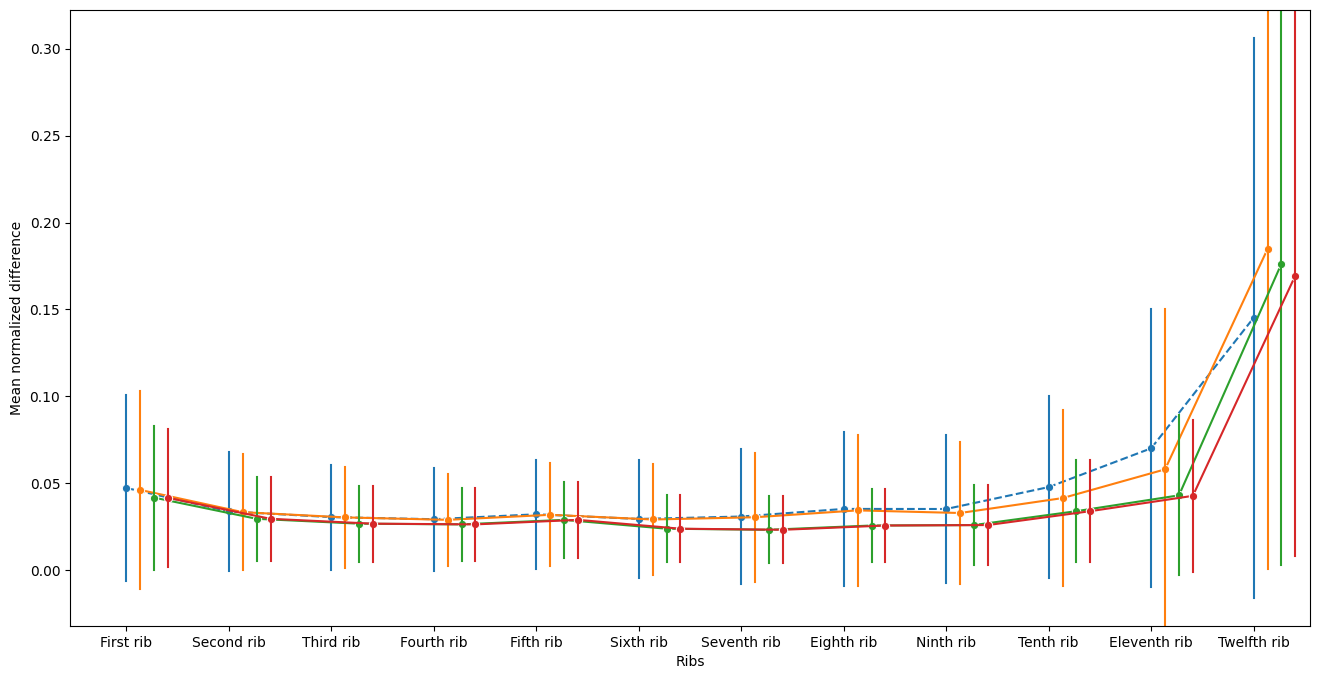

In [16]:
### Plot for the Value_relative_difference2 mean and std over the three heuristics comparison ###

# https://stackoverflow.com/questions/43126064/how-do-i-shift-categorical-scatter-markers-to-left-and-right-above-xticks-multi

import matplotlib.transforms as transforms

### Calculate the mean and stddev ###

mean_cv = df_plot_ribs_stats_all.groupby(['filter_status', 'findingSite_CodeMeaning'])['Value_relative_difference2'].mean()
mean_cv_df = mean_cv.reset_index()
mean_cv_df.columns = ['filter_status', 'findingSite_CodeMeaning', 'Value_relative_difference2_mean']

stddev_cv = df_plot_ribs_stats_all.groupby(['filter_status', 'findingSite_CodeMeaning'])['Value_relative_difference2'].std()
stddev_cv_df = stddev_cv.reset_index()
stddev_cv_df.columns = ['filter_status', 'findingSite_CodeMeaning', 'Value_relative_difference2_stddev']

df_cv = pd.DataFrame()
df_cv = mean_cv_df.merge(stddev_cv_df, on=['filter_status', 'findingSite_CodeMeaning'], how='inner')

# Define order of ribs we want
rib_list = ['First rib', 'Second rib', 'Third rib', 'Fourth rib', 'Fifth rib', 'Sixth rib',
            'Seventh rib', 'Eighth rib', 'Ninth rib', 'Tenth rib', 'Eleventh rib', 'Twelfth rib']

# Create a dictionary to map the ribs_order to their corresponding indices
rib_index_map = {rib: idx for idx, rib in enumerate(rib_list)}

df_cv_original = df_cv[df_cv['filter_status']=='original']
df_cv_filter_1 = df_cv[df_cv['filter_status']=="with_one_filter"]
df_cv_filter_2 = df_cv[df_cv['filter_status']=="with_two_filter"]
df_cv_filter_3 = df_cv[df_cv['filter_status']=="with_three_filter"]

# Add a new column with the corresponding index for each rib
df_cv_original['rib_index'] = df_cv_original['findingSite_CodeMeaning'].map(rib_index_map)
df_cv_filter_1['rib_index'] = df_cv_filter_1['findingSite_CodeMeaning'].map(rib_index_map)
df_cv_filter_2['rib_index'] = df_cv_filter_2['findingSite_CodeMeaning'].map(rib_index_map)
df_cv_filter_3['rib_index'] = df_cv_filter_3['findingSite_CodeMeaning'].map(rib_index_map)

# Sort the DataFrame based on the ribs_index column
df_cv_original_sorted = df_cv_original.sort_values(by=['rib_index'])
df_cv_filter_1_sorted = df_cv_filter_1.sort_values(by=['rib_index'])
df_cv_filter_2_sorted = df_cv_filter_2.sort_values(by=['rib_index'])
df_cv_filter_3_sorted = df_cv_filter_3.sort_values(by=['rib_index'])

# Drop the temporary ribs_index column
df_cv_original_sorted.drop(columns=['rib_index'], inplace=True)
df_cv_filter_1_sorted.drop(columns=['rib_index'], inplace=True)
df_cv_filter_2_sorted.drop(columns=['rib_index'], inplace=True)
df_cv_filter_3_sorted.drop(columns=['rib_index'], inplace=True)

df_cv_original = df_cv_original_sorted.copy(deep=True)
df_cv_filter_1 = df_cv_filter_1_sorted.copy(deep=True)
df_cv_filter_2 = df_cv_filter_2_sorted.copy(deep=True)
df_cv_filter_3 = df_cv_filter_3_sorted.copy(deep=True)

### Plot ###

fig = plt.figure(figsize=(16,8))

offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# original
ax = sns.lineplot(data=df_cv_original, x = 'findingSite_CodeMeaning', y = 'Value_relative_difference2_mean' , marker='o')
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')
ax.set_ylabel('Mean normalized difference')
for n in range(0,len(df_cv_original)):
  plt.plot([n, n],
          [df_cv_original['Value_relative_difference2_mean'].values[n] - df_cv_original['Value_relative_difference2_stddev'].values[n], df_cv_original['Value_relative_difference2_mean'].values[n] + df_cv_original['Value_relative_difference2_stddev'].values[n]],
          c='C0')

# with 1 filter
ax = sns.lineplot(data=df_cv_filter_1, x = 'findingSite_CodeMeaning', y = 'Value_relative_difference2_mean' , marker='o', transform=trans+offset(10))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')

ax.set_ylabel('Mean normalized difference')
for n in range(0,len(df_cv_filter_1)):
  plt.plot([n, n],
          [df_cv_filter_1['Value_relative_difference2_mean'].values[n] - df_cv_filter_1['Value_relative_difference2_stddev'].values[n], df_cv_filter_1['Value_relative_difference2_mean'].values[n] + df_cv_filter_1['Value_relative_difference2_stddev'].values[n]],
          c='C1',
          transform=trans+offset(10))

# with 2 filter
ax = sns.lineplot(data=df_cv_filter_2, x = 'findingSite_CodeMeaning', y = 'Value_relative_difference2_mean' , marker='o', transform=trans+offset(20))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')

ax.set_ylabel('Mean normalized difference')
for n in range(0,len(df_cv_filter_2)):
  plt.plot([n, n],
          [df_cv_filter_2['Value_relative_difference2_mean'].values[n] - df_cv_filter_2['Value_relative_difference2_stddev'].values[n], df_cv_filter_2['Value_relative_difference2_mean'].values[n] + df_cv_filter_2['Value_relative_difference2_stddev'].values[n]],
          c='C2',
          transform=trans+offset(20))

# with 3 filter
ax = sns.lineplot(data=df_cv_filter_3, x = 'findingSite_CodeMeaning', y = 'Value_relative_difference2_mean' , marker='o', transform=trans+offset(30))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')

ax.set_ylabel('Mean normalized difference')
for n in range(0,len(df_cv_filter_3)):
  plt.plot([n, n],
          [df_cv_filter_3['Value_relative_difference2_mean'].values[n] - df_cv_filter_3['Value_relative_difference2_stddev'].values[n], df_cv_filter_3['Value_relative_difference2_mean'].values[n] + df_cv_filter_3['Value_relative_difference2_stddev'].values[n]],
          c='C3',
          transform=trans+offset(30))

In [ ]:
# Investigate why such poor results for the twelfth rib - original results

df_original = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status']=='original']
df_original_rib_12 = df_original[df_original['findingSite_CodeMeaning']=="Twelfth rib"]
df_original_rib_12 = df_original_rib_12.sort_values(by='Value_relative_difference2', ascending=False)

df_original_rib_12.head(5)

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value_left,Value_right,Value_left_minus_right,filter_status,Value_relative_difference,Value_relative_difference2,Coefficient_of_variation
90945,216972,1.3.6.1.4.1.14519.5.2.1.7009.9004.135981462593...,1.3.6.1.4.1.14519.5.2.1.7009.9004.205217235187...,63,M,Twelfth rib,7.177390,0.002052,7.175338,original,0.999714,0.999428,0.999428
59937,105248,1.2.840.113654.2.55.12908775556614379594178027...,1.2.840.113654.2.55.33539711870502012551878622...,55,M,Twelfth rib,0.003906,6.655273,6.651367,original,1702.858966,0.998827,0.998827
87196,215047,1.3.6.1.4.1.14519.5.2.1.7009.9004.226011287714...,1.3.6.1.4.1.14519.5.2.1.7009.9004.173938273212...,67,F,Twelfth rib,0.003230,4.490239,4.487009,original,1389.166794,0.998562,0.998562
598,106014,1.2.840.113654.2.55.10781111428634090169731439...,1.2.840.113654.2.55.10247436413604158632764089...,68,M,Twelfth rib,5.513871,0.004314,5.509557,original,0.999218,0.998436,0.998436
103705,214058,1.3.6.1.4.1.14519.5.2.1.7009.9004.290554253407...,1.3.6.1.4.1.14519.5.2.1.7009.9004.308929717569...,62,F,Twelfth rib,5.024927,0.003955,5.020972,original,0.999213,0.998427,0.998427


In [ ]:
# Investigate for the twelfth rib - after 3 filters - ones that were not removed, but should have been

df_filter_3 = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status']=='with_three_filter']
df_filter_3_rib_12 = df_filter_3[df_filter_3['findingSite_CodeMeaning']=="Twelfth rib"]
df_filter_3_rib_12 = df_filter_3_rib_12.sort_values(by='Value_relative_difference2', ascending=False)

df_filter_3_rib_12.head(5)

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value_left,Value_right,Value_left_minus_right,filter_status,Value_relative_difference,Value_relative_difference2,Coefficient_of_variation
9284,116957,1.2.840.113654.2.55.18871538468845583333268657...,1.2.840.113654.2.55.31523216007293066113915752...,62,F,Twelfth rib,6.234030,0.076204,6.157826,with_three_filter,0.987776,0.975847,0.975847
15189,200951,1.3.6.1.4.1.14519.5.2.1.7009.9004.171448522863...,1.3.6.1.4.1.14519.5.2.1.7009.9004.167595855113...,62,F,Twelfth rib,5.081177,0.083771,4.997406,with_three_filter,0.983513,0.967562,0.967562
14859,207385,1.3.6.1.4.1.14519.5.2.1.7009.9004.396138154798...,1.3.6.1.4.1.14519.5.2.1.7009.9004.156477874697...,68,M,Twelfth rib,7.955338,0.154145,7.801193,with_three_filter,0.980624,0.961984,0.961984
19401,207102,1.3.6.1.4.1.14519.5.2.1.7009.9004.289469800667...,1.3.6.1.4.1.14519.5.2.1.7009.9004.307637945690...,59,M,Twelfth rib,8.447058,0.172046,8.275012,with_three_filter,0.979632,0.960078,0.960078
14390,209467,1.3.6.1.4.1.14519.5.2.1.7009.9004.149806882428...,1.3.6.1.4.1.14519.5.2.1.7009.9004.140445442625...,64,M,Twelfth rib,5.203283,0.114557,5.088726,with_three_filter,0.977984,0.956916,0.956916


In [ ]:
# Investivate for the 12th rib - after 3 filters - ones that were removed, and should have been

df_original = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status']=='original']
df_original_rib_12 = df_original[df_original['findingSite_CodeMeaning']=="Twelfth rib"]
df_original_rib_12 = df_original_rib_12.sort_values(by='Value_relative_difference2', ascending=False)

series_original_rib_12 = df_original_rib_12['sourceSegmentedSeriesUID'].values

df_filter_3 = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status']=='with_three_filter']
df_filter_3_rib_12 = df_filter_3[df_filter_3['findingSite_CodeMeaning']=="Twelfth rib"]
df_filter_3_rib_12 = df_filter_3_rib_12.sort_values(by='Value_relative_difference2', ascending=False)

series_filter_3_rib_12 = df_filter_3_rib_12['sourceSegmentedSeriesUID'].values

# get ones in original, not in filter 3
series_filter_3_removed = list(set(series_original_rib_12)-set(series_filter_3_rib_12))
print('series_filter_3_removed: ' + str(len(series_filter_3_removed)))

# get the df
df_series_filter_3_removed = df_original_rib_12[df_original_rib_12['sourceSegmentedSeriesUID'].isin(series_filter_3_removed)]
df_series_filter_3_removed = df_series_filter_3_removed.sort_values(by='Value_relative_difference2', ascending=True)
df_series_filter_3_removed.head()


series_filter_3_removed: 93517


,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value_left,Value_right,Value_left_minus_right,filter_status,Value_relative_difference,Value_relative_difference2,Coefficient_of_variation
9410,108915,1.2.840.113654.2.55.74473136650646387874615655...,1.2.840.113654.2.55.13746977193752970720776333...,59,M,Twelfth rib,2.694397,2.694397,0.0,original,0.0,0.0,0.0
60772,116556,1.2.840.113654.2.55.33548394151134797462950580...,1.2.840.113654.2.55.33874653895768763576771172...,61,M,Twelfth rib,3.212091,3.212091,0.0,original,0.0,0.0,0.0
52029,133589,1.2.840.113654.2.55.11937667606104445300433567...,1.2.840.113654.2.55.30419583537207770359572789...,59,M,Twelfth rib,4.842851,4.842851,0.0,original,0.0,0.0,0.0
14048,129272,1.2.840.113654.2.55.86123200476371170267641179...,1.2.840.113654.2.55.15510193800585179795461862...,60,F,Twelfth rib,1.929707,1.929707,0.0,original,0.0,0.0,0.0
51474,119688,1.2.840.113654.2.55.30418520926639316605846573...,1.2.840.113654.2.55.30201011919089627410096888...,64,M,Twelfth rib,3.492340,3.492340,0.0,original,0.0,0.0,0.0


## Stats for ribs

We have four different methods of computing the differences:
1. Left volume - right volume
2. abs(Left volume - right volume) / left volume
3. abs(Left volume - right volume) / (Left volume + right volume)
4. std([left volume, right volume)] / mean([left volume, right volume])

Try the linear mixed effects model on the 3rd one, normalized difference.

In [45]:
print(region_list)

['First rib', 'Second rib', 'Third rib', 'Fourth rib', 'Fifth rib', 'Sixth rib', 'Seventh rib', 'Eighth rib', 'Ninth rib', 'Tenth rib', 'Eleventh rib', 'Twelfth rib']


In [46]:
set(df_plot_ribs_stats_all['filter_status'].values)

{'original', 'with_one_filter', 'with_three_filter', 'with_two_filter'}

In [52]:
# df_for_stats_1 = df_plot_ribs_stats_all.copy(deep=True)
# df_for_stats_1A = df_for_stats_1[df_for_stats_1['filter_status']=="original"]
# df_for_stats_1B = df_for_stats_1[df_for_stats_1['filter_status']=="with_one_filter"]
# df_for_stats_1 = pd.concat([df_for_stats_1A, df_for_stats_1B])
# print(set(df_for_stats_1['filter_status'].values))

# df_for_stats_2 = df_plot_ribs_stats_all.copy(deep=True)
# df_for_stats_2A = df_for_stats_2[df_for_stats_2['filter_status']=='with_one_filter']
# df_for_stats_2B = df_for_stats_2[df_for_stats_2['filter_status']=="with_two_filter"]
# df_for_stats_2 = pd.concat([df_for_stats_2A, df_for_stats_2B])
# print(set(df_for_stats_2['filter_status'].values))

df_for_stats_1 = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status'].isin(["original", "with_one_filter"])]
df_for_stats_2 = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status'].isin(["with_one_filter", "with_two_filter"])]
df_for_stats_3 = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status'].isin(["with_two_filter", "with_three_filter"])]
df_for_stats_4 = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status'].isin(["original", "with_three_filter"])]

print(set(df_for_stats_1['filter_status'].values))
print(set(df_for_stats_2['filter_status'].values))
print(set(df_for_stats_3['filter_status'].values))
print(set(df_for_stats_4['filter_status'].values))

df_for_stats_1['stats_test'] = ["original_vs_one_filter"] * len(df_for_stats_1)
df_for_stats_2['stats_test'] = ["one_filter_vs_two_filter"] * len(df_for_stats_2)
df_for_stats_3['stats_test'] = ["two_filter_vs_three_filter"] * len(df_for_stats_3)
df_for_stats_4['stats_test'] = ["original_vs_three_filter"] * len(df_for_stats_4)

df_for_stats = pd.concat([df_for_stats_1, df_for_stats_2, df_for_stats_3, df_for_stats_4])



{'original', 'with_one_filter'}
{'with_two_filter', 'with_one_filter'}
{'with_three_filter', 'with_two_filter'}
{'with_three_filter', 'original'}


In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

stats_test = ["original_vs_one_filter", "one_filter_vs_two_filter", "two_filter_vs_three_filter", "original_vs_three_filter"]

stats_test_type_list = []
stats_test_region_list = []
stats_test_p_value_list = []

# for each group comparison
for m in range(0,4):

  df_for_stats_sub = df_for_stats[df_for_stats["stats_test"]==stats_test[m]]

  # for each region
  for n in range(0,len(region_list)):

    region = region_list[n]
    print('*** region: ' + str(region) + ' ***')

    # Assuming volumes_data is a DataFrame containing columns: patient_id, side (left/right), volume, and filter_status

    df = df_for_stats_sub[df_for_stats_sub['findingSite_CodeMeaning']==region]

    # Fit linear mixed-effects model
    mixed_model = smf.mixedlm("Value_relative_difference2 ~ filter_status", df, groups=df["PatientID"]) # 'Value_relative_difference2' = (left-right)/(left+right)
    mixed_results = mixed_model.fit()

    # Print summary of results
    print(mixed_results.summary())

    stats_test_type_list.append(stats_test[m])
    stats_test_region_list.append(region)
    stats_test_p_value_list.append(mixed_results.pvalues[1])


# df_stats_ribs_1 = pd.DataFrame()
# df_stats_ribs_1['region'] = region_list
# df_stats_ribs_1['p_value'] = p_values

*** region: First rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   171995   Method:              REML                      
No. Groups:         26192    Scale:               0.0008                    
Min. group size:    1        Log-Likelihood:      329690.9731               
Max. group size:    36       Converged:           Yes                       
Mean group size:    6.6                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.047    0.000 157.854 0.000  0.046  0.048
filter_status[T.with_one_filter] -0.000    0.000  -1.391 0.164 -0.001  0.000
Group Var                         0.002    0.001                            

*** region: Second

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   238407   Method:              REML                      
No. Groups:         26193    Scale:               0.0005                    
Min. group size:    1        Log-Likelihood:      538937.5799               
Max. group size:    36       Converged:           Yes                       
Mean group size:    9.1                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.034    0.000 191.792 0.000  0.033  0.034
filter_status[T.with_one_filter] -0.000    0.000  -2.032 0.042 -0.000 -0.000
Group Var                         0.001    0.000                            

*** region: Third 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   251270   Method:              REML                      
No. Groups:         26193    Scale:               0.0003                    
Min. group size:    1        Log-Likelihood:      610631.8871               
Max. group size:    36       Converged:           Yes                       
Mean group size:    9.6                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.030    0.000 199.643 0.000  0.030  0.031
filter_status[T.with_one_filter] -0.000    0.000  -1.822 0.068 -0.000  0.000
Group Var                         0.001    0.000                            

*** region: Fourth

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   251459   Method:              REML                      
No. Groups:         26193    Scale:               0.0003                    
Min. group size:    1        Log-Likelihood:      618193.6900               
Max. group size:    36       Converged:           Yes                       
Mean group size:    9.6                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.029    0.000 201.844 0.000  0.029  0.029
filter_status[T.with_one_filter] -0.000    0.000  -4.184 0.000 -0.000 -0.000
Group Var                         0.000    0.000                            

*** region: Fifth 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   251446   Method:              REML                      
No. Groups:         26193    Scale:               0.0004                    
Min. group size:    1        Log-Likelihood:      607851.4320               
Max. group size:    36       Converged:           Yes                       
Mean group size:    9.6                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.032    0.000 201.984 0.000  0.032  0.032
filter_status[T.with_one_filter] -0.000    0.000  -3.437 0.001 -0.000 -0.000
Group Var                         0.001    0.000                            

*** region: Sixth 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   251276   Method:              REML                      
No. Groups:         26194    Scale:               0.0004                    
Min. group size:    1        Log-Likelihood:      585444.4348               
Max. group size:    36       Converged:           Yes                       
Mean group size:    9.6                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.029    0.000 171.395 0.000  0.029  0.030
filter_status[T.with_one_filter] -0.000    0.000  -3.204 0.001 -0.000 -0.000
Group Var                         0.001    0.000                            

*** region: Sevent

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   249337   Method:              REML                      
No. Groups:         26194    Scale:               0.0006                    
Min. group size:    1        Log-Likelihood:      540248.0100               
Max. group size:    36       Converged:           Yes                       
Mean group size:    9.5                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.031    0.000 159.047 0.000  0.030  0.031
filter_status[T.with_one_filter] -0.000    0.000  -2.673 0.008 -0.000 -0.000
Group Var                         0.001    0.000                            

*** region: Eighth

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   235507   Method:              REML                      
No. Groups:         26193    Scale:               0.0009                    
Min. group size:    1        Log-Likelihood:      466373.8220               
Max. group size:    36       Converged:           Yes                       
Mean group size:    9.0                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.035    0.000 159.099 0.000  0.035  0.035
filter_status[T.with_one_filter] -0.000    0.000  -2.694 0.007 -0.001 -0.000
Group Var                         0.001    0.000                            

*** region: Ninth 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   210716   Method:              REML                      
No. Groups:         26193    Scale:               0.0009                    
Min. group size:    1        Log-Likelihood:      410660.0306               
Max. group size:    36       Converged:           Yes                       
Mean group size:    8.0                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.035    0.000 172.841 0.000  0.035  0.035
filter_status[T.with_one_filter] -0.001    0.000  -6.664 0.000 -0.001 -0.001
Group Var                         0.001    0.000                            

*** region: Tenth 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   165689   Method:              REML                      
No. Groups:         26193    Scale:               0.0015                    
Min. group size:    1        Log-Likelihood:      282466.4640               
Max. group size:    33       Converged:           Yes                       
Mean group size:    6.3                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.048    0.000 191.755 0.000  0.047  0.048
filter_status[T.with_one_filter] -0.002    0.000  -8.996 0.000 -0.003 -0.002
Group Var                         0.001    0.000                            

*** region: Eleven

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   137188   Method:              REML                      
No. Groups:         26189    Scale:               0.0033                    
Min. group size:    1        Log-Likelihood:      174677.5876               
Max. group size:    28       Converged:           Yes                       
Mean group size:    5.2                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.071    0.000 176.517 0.000  0.070  0.071
filter_status[T.with_one_filter] -0.004    0.001  -5.793 0.000 -0.005 -0.002
Group Var                         0.003    0.001                            

*** region: Twelft

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   87644    Method:              REML                      
No. Groups:         16148    Scale:               0.0005                    
Min. group size:    1        Log-Likelihood:      181934.5411               
Max. group size:    34       Converged:           Yes                       
Mean group size:    5.4                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.047    0.000 107.134 0.000  0.046  0.048
filter_status[T.with_two_filter] -0.001    0.000  -6.715 0.000 -0.001 -0.001
Group Var                         0.003    0.002                            

*** region: Second

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   201103   Method:              REML                      
No. Groups:         25738    Scale:               0.0003                    
Min. group size:    1        Log-Likelihood:      482853.1103               
Max. group size:    30       Converged:           Yes                       
Mean group size:    7.8                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.034    0.000 195.749 0.000  0.033  0.034
filter_status[T.with_two_filter] -0.002    0.000 -20.299 0.000 -0.002 -0.002
Group Var                         0.001    0.000                            

*** region: Third 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   211199   Method:              REML                      
No. Groups:         26191    Scale:               0.0002                    
Min. group size:    1        Log-Likelihood:      542307.7025               
Max. group size:    32       Converged:           Yes                       
Mean group size:    8.1                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.030    0.000 209.222 0.000  0.030  0.031
filter_status[T.with_two_filter] -0.001    0.000 -19.743 0.000 -0.002 -0.001
Group Var                         0.000    0.000                            

*** region: Fourth

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   210695   Method:              REML                      
No. Groups:         26192    Scale:               0.0002                    
Min. group size:    1        Log-Likelihood:      564280.2509               
Max. group size:    32       Converged:           Yes                       
Mean group size:    8.0                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.029    0.000 211.253 0.000  0.028  0.029
filter_status[T.with_two_filter] -0.001    0.000 -14.195 0.000 -0.001 -0.001
Group Var                         0.000    0.000                            

*** region: Fifth 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   212250   Method:              REML                      
No. Groups:         26192    Scale:               0.0002                    
Min. group size:    1        Log-Likelihood:      550690.9370               
Max. group size:    32       Converged:           Yes                       
Mean group size:    8.1                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.032    0.000 211.026 0.000  0.032  0.032
filter_status[T.with_two_filter] -0.001    0.000 -14.773 0.000 -0.001 -0.001
Group Var                         0.001    0.000                            

*** region: Sixth 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   218559   Method:              REML                      
No. Groups:         26187    Scale:               0.0003                    
Min. group size:    1        Log-Likelihood:      551936.4589               
Max. group size:    34       Converged:           Yes                       
Mean group size:    8.3                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.029    0.000 181.220 0.000  0.029  0.029
filter_status[T.with_two_filter] -0.001    0.000 -19.997 0.000 -0.002 -0.001
Group Var                         0.001    0.000                            

*** region: Sevent

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   218902   Method:              REML                      
No. Groups:         26112    Scale:               0.0004                    
Min. group size:    1        Log-Likelihood:      517275.3412               
Max. group size:    34       Converged:           Yes                       
Mean group size:    8.4                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.030    0.000 169.062 0.000  0.030  0.031
filter_status[T.with_two_filter] -0.002    0.000 -23.480 0.000 -0.002 -0.002
Group Var                         0.001    0.000                            

*** region: Eighth

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   193388   Method:              REML                      
No. Groups:         25107    Scale:               0.0005                    
Min. group size:    1        Log-Likelihood:      419985.6089               
Max. group size:    31       Converged:           Yes                       
Mean group size:    7.7                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.034    0.000 161.206 0.000  0.034  0.035
filter_status[T.with_two_filter] -0.003    0.000 -23.015 0.000 -0.003 -0.002
Group Var                         0.001    0.000                            

*** region: Ninth 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   151673   Method:              REML                      
No. Groups:         22172    Scale:               0.0005                    
Min. group size:    1        Log-Likelihood:      330251.3055               
Max. group size:    35       Converged:           Yes                       
Mean group size:    6.8                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.033    0.000 151.836 0.000  0.033  0.033
filter_status[T.with_two_filter] -0.002    0.000 -19.120 0.000 -0.003 -0.002
Group Var                         0.001    0.000                            

*** region: Tenth 

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:   71323    Method:              REML                      
No. Groups:         13735    Scale:               0.0007                    
Min. group size:    1        Log-Likelihood:      141464.8483               
Max. group size:    28       Converged:           Yes                       
Mean group size:    5.2                                                     
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.042    0.000 110.562 0.000  0.041  0.043
filter_status[T.with_two_filter] -0.002    0.000 -11.751 0.000 -0.003 -0.002
Group Var                         0.002    0.001                            

*** region: Eleven

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  21721    Method:              REML                      
No. Groups:        5495     Scale:               0.0012                    
Min. group size:   1        Log-Likelihood:      33597.2750                
Max. group size:   26       Converged:           Yes                       
Mean group size:   4.0                                                     
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.061    0.001 48.850 0.000  0.058  0.063
filter_status[T.with_two_filter] -0.003    0.000 -5.542 0.000 -0.004 -0.002
Group Var                         0.008    0.006                           

*** region: Twelfth rib ***
  

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  82524    Method:              REML                      
No. Groups:        15412    Scale:               0.0003                    
Min. group size:   1        Log-Likelihood:      192725.1224               
Max. group size:   32       Converged:           Yes                       
Mean group size:   5.4                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.042    0.000 127.313 0.000  0.042  0.043
filter_status[T.with_two_filter] 0.000    0.000   0.279 0.780 -0.000  0.000
Group Var                        0.002    0.001                            

*** region: Second rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  176812   Method:              REML                      
No. Groups:        24038    Scale:               0.0002                    
Min. group size:   2        Log-Likelihood:      485542.7354               
Max. group size:   30       Converged:           Yes                       
Mean group size:   7.4                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.030    0.000 203.388 0.000  0.030  0.030
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.000    0.000                            

*** region: Third rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  171376   Method:              REML                      
No. Groups:        22780    Scale:               0.0001                    
Min. group size:   2        Log-Likelihood:      501811.5536               
Max. group size:   32       Converged:           Yes                       
Mean group size:   7.5                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.027    0.000 196.821 0.000  0.027  0.028
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.000    0.000                            

*** region: Fourth rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  170218   Method:              REML                      
No. Groups:        22470    Scale:               0.0001                    
Min. group size:   2        Log-Likelihood:      516002.8160               
Max. group size:   32       Converged:           Yes                       
Mean group size:   7.6                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.027    0.000 201.341 0.000  0.026  0.027
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.000    0.000                            

*** region: Fifth rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  173484   Method:              REML                      
No. Groups:        22651    Scale:               0.0001                    
Min. group size:   2        Log-Likelihood:      529690.7600               
Max. group size:   32       Converged:           Yes                       
Mean group size:   7.7                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.029    0.000 211.225 0.000  0.029  0.029
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.000    0.000                            

*** region: Sixth rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  186518   Method:              REML                      
No. Groups:        23284    Scale:               0.0001                    
Min. group size:   2        Log-Likelihood:      584962.0152               
Max. group size:   34       Converged:           Yes                       
Mean group size:   8.0                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.024    0.000 200.604 0.000  0.024  0.024
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.000    0.000                            

*** region: Seventh rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  191092   Method:              REML                      
No. Groups:        23174    Scale:               0.0001                    
Min. group size:   2        Log-Likelihood:      576531.0524               
Max. group size:   34       Converged:           Yes                       
Mean group size:   8.2                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.023    0.000 198.872 0.000  0.023  0.024
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.000    0.000                            

*** region: Eighth rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  167642   Method:              REML                      
No. Groups:        21716    Scale:               0.0001                    
Min. group size:   2        Log-Likelihood:      484409.4428               
Max. group size:   30       Converged:           Yes                       
Mean group size:   7.7                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.026    0.000 193.873 0.000  0.026  0.026
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.000    0.000                            

*** region: Ninth rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  133724   Method:              REML                      
No. Groups:        19511    Scale:               0.0002                    
Min. group size:   2        Log-Likelihood:      362858.2215               
Max. group size:   34       Converged:           Yes                       
Mean group size:   6.9                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.026    0.000 172.024 0.000  0.026  0.027
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.000    0.000                            

*** region: Tenth rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value_relative_difference2
No. Observations:  62866    Method:              REML                      
No. Groups:        11843    Scale:               0.0002                    
Min. group size:   2        Log-Likelihood:      160220.3100               
Max. group size:   26       Converged:           Yes                       
Mean group size:   5.3                                                     
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.034    0.000 132.926 0.000  0.034  0.035
filter_status[T.with_two_filter] 0.000    0.000   0.000 1.000 -0.000  0.000
Group Var                        0.001    0.001                            

*** region: Eleventh rib ***


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Value_relative_difference2
No. Observations:   19625   Method:             REML                      
No. Groups:         4832    Scale:              0.0002                    
Min. group size:    1       Log-Likelihood:     45750.9447                
Max. group size:    26      Converged:          Yes                       
Mean group size:    4.1                                                   
--------------------------------------------------------------------------
                                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.045    0.001 60.653 0.000  0.044  0.047
filter_status[T.with_two_filter] 0.000    0.000  0.105 0.917 -0.000  0.000
Group Var                        0.003    0.004                           

*** region: Twelfth rib ***
               

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   166875    Method:               REML                      
No. Groups:         26192     Scale:                0.0007                    
Min. group size:    1         Log-Likelihood:       329649.8055               
Max. group size:    34        Converged:            Yes                       
Mean group size:    6.4                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.047    0.000 162.021 0.000  0.046  0.048
filter_status[T.with_three_filter] -0.002    0.000 -11.439 0.000 -0.002 -0.002
Group Var                           0.002    0.001                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   214116    Method:               REML                      
No. Groups:         26193     Scale:                0.0004                    
Min. group size:    1         Log-Likelihood:       503310.9753               
Max. group size:    30        Converged:            Yes                       
Mean group size:    8.2                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.034    0.000 203.125 0.000  0.033  0.034
filter_status[T.with_three_filter] -0.002    0.000 -22.084 0.000 -0.002 -0.002
Group Var                           0.001    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   211447    Method:               REML                      
No. Groups:         26193     Scale:                0.0003                    
Min. group size:    1         Log-Likelihood:       528681.5952               
Max. group size:    32        Converged:            Yes                       
Mean group size:    8.1                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.030    0.000 207.751 0.000  0.030  0.031
filter_status[T.with_three_filter] -0.002    0.000 -20.327 0.000 -0.002 -0.001
Group Var                           0.000    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   210982    Method:               REML                      
No. Groups:         26193     Scale:                0.0003                    
Min. group size:    1         Log-Likelihood:       525620.1536               
Max. group size:    32        Converged:            Yes                       
Mean group size:    8.1                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.029    0.000 208.730 0.000  0.029  0.029
filter_status[T.with_three_filter] -0.001    0.000 -16.419 0.000 -0.001 -0.001
Group Var                           0.000    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   212680    Method:               REML                      
No. Groups:         26193     Scale:                0.0003                    
Min. group size:    1         Log-Likelihood:       529841.1380               
Max. group size:    32        Converged:            Yes                       
Mean group size:    8.1                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.032    0.000 209.826 0.000  0.032  0.032
filter_status[T.with_three_filter] -0.001    0.000 -16.339 0.000 -0.001 -0.001
Group Var                           0.001    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   219235    Method:               REML                      
No. Groups:         26194     Scale:                0.0003                    
Min. group size:    1         Log-Likelihood:       535247.1273               
Max. group size:    34        Converged:            Yes                       
Mean group size:    8.4                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.029    0.000 181.431 0.000  0.029  0.030
filter_status[T.with_three_filter] -0.002    0.000 -22.140 0.000 -0.002 -0.002
Group Var                           0.001    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   221527    Method:               REML                      
No. Groups:         26194     Scale:                0.0004                    
Min. group size:    1         Log-Likelihood:       509597.0660               
Max. group size:    34        Converged:            Yes                       
Mean group size:    8.5                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.031    0.000 170.338 0.000  0.030  0.031
filter_status[T.with_three_filter] -0.002    0.000 -25.526 0.000 -0.003 -0.002
Group Var                           0.001    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   209761    Method:               REML                      
No. Groups:         26193     Scale:                0.0006                    
Min. group size:    1         Log-Likelihood:       443264.3029               
Max. group size:    31        Converged:            Yes                       
Mean group size:    8.0                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.035    0.000 172.878 0.000  0.035  0.035
filter_status[T.with_three_filter] -0.003    0.000 -26.212 0.000 -0.003 -0.003
Group Var                           0.001    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   192767    Method:               REML                      
No. Groups:         26193     Scale:                0.0008                    
Min. group size:    1         Log-Likelihood:       392732.0234               
Max. group size:    35        Converged:            Yes                       
Mean group size:    7.4                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.035    0.000 187.372 0.000  0.035  0.035
filter_status[T.with_three_filter] -0.004    0.000 -26.549 0.000 -0.004 -0.003
Group Var                           0.001    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   157232    Method:               REML                      
No. Groups:         26193     Scale:                0.0013                    
Min. group size:    1         Log-Likelihood:       275794.5018               
Max. group size:    28        Converged:            Yes                       
Mean group size:    6.0                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.048    0.000 200.166 0.000  0.047  0.048
filter_status[T.with_three_filter] -0.005    0.000 -21.250 0.000 -0.006 -0.005
Group Var                           0.001    0.000                       

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Value_relative_difference2
No. Observations:   135092    Method:               REML                      
No. Groups:         26189     Scale:                0.0031                    
Min. group size:    1         Log-Likelihood:       176129.7939               
Max. group size:    28        Converged:            Yes                       
Mean group size:    5.2                                                       
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           0.071    0.000 181.386 0.000  0.070  0.071
filter_status[T.with_three_filter] -0.011    0.001 -16.236 0.000 -0.012 -0.010
Group Var                           0.003    0.001                       

In [56]:
df_stats_ribs = pd.DataFrame()
df_stats_ribs['stats_test'] = stats_test_type_list
df_stats_ribs['region'] = stats_test_region_list
df_stats_ribs['p_value'] = stats_test_p_value_list
df_stats_ribs['significant'] = ["yes" if f<=0.05 else "no" for f in stats_test_p_value_list]

# df_stats_ribs.loc[df_stats_ribs.stats_test=='two_filter_vs_one_filter', 'stats_test'] = 'two_filter_vs_three_filter'


df_stats_ribs

,stats_test,region,p_value,significant
0,original_vs_one_filter,First rib,1.642142e-01,no
1,original_vs_one_filter,Second rib,4.216703e-02,yes
2,original_vs_one_filter,Third rib,6.847553e-02,no
3,original_vs_one_filter,Fourth rib,2.865896e-05,yes
4,original_vs_one_filter,Fifth rib,5.875914e-04,yes
5,original_vs_one_filter,Sixth rib,1.357133e-03,yes
6,original_vs_one_filter,Seventh rib,7.515218e-03,yes
7,original_vs_one_filter,Eighth rib,7.055267e-03,yes
8,original_vs_one_filter,Ninth rib,2.661015e-11,yes
9,original_vs_one_filter,Tenth rib,2.338341e-19,yes


In [76]:
df_stats_ribs.to_csv("/content/stats_ribs.csv")

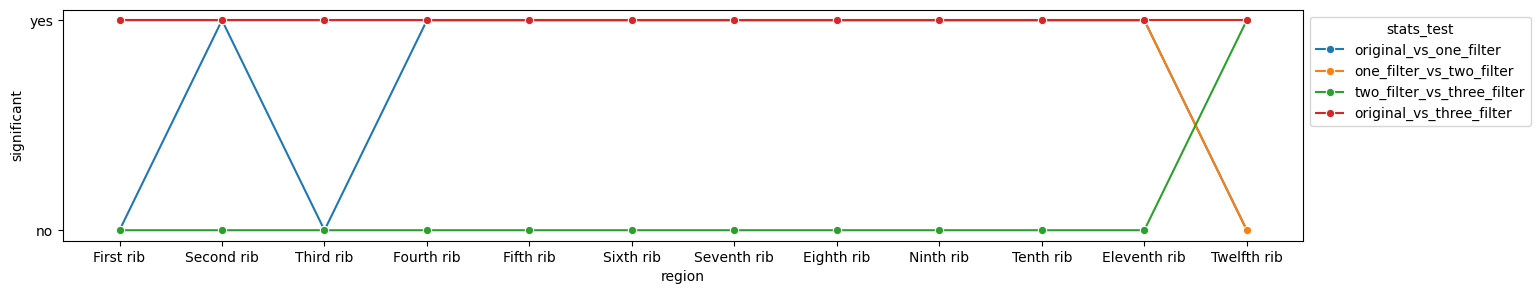

In [75]:
# Plot of the change in if significant or not

plt.figure(figsize=(16,3))
ax = sns.lineplot(data=df_stats_ribs, x='region', y='significant', hue='stats_test', marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.invert_yaxis()
plt.show()

<ipython-input-104-afdca3782a0f>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['no', 'yes'])
<ipython-input-104-afdca3782a0f>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['no', 'yes'])
<ipython-input-104-afdca3782a0f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['no', 'yes'])
<ipython-input-104-afdca3782a0f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['yes'])


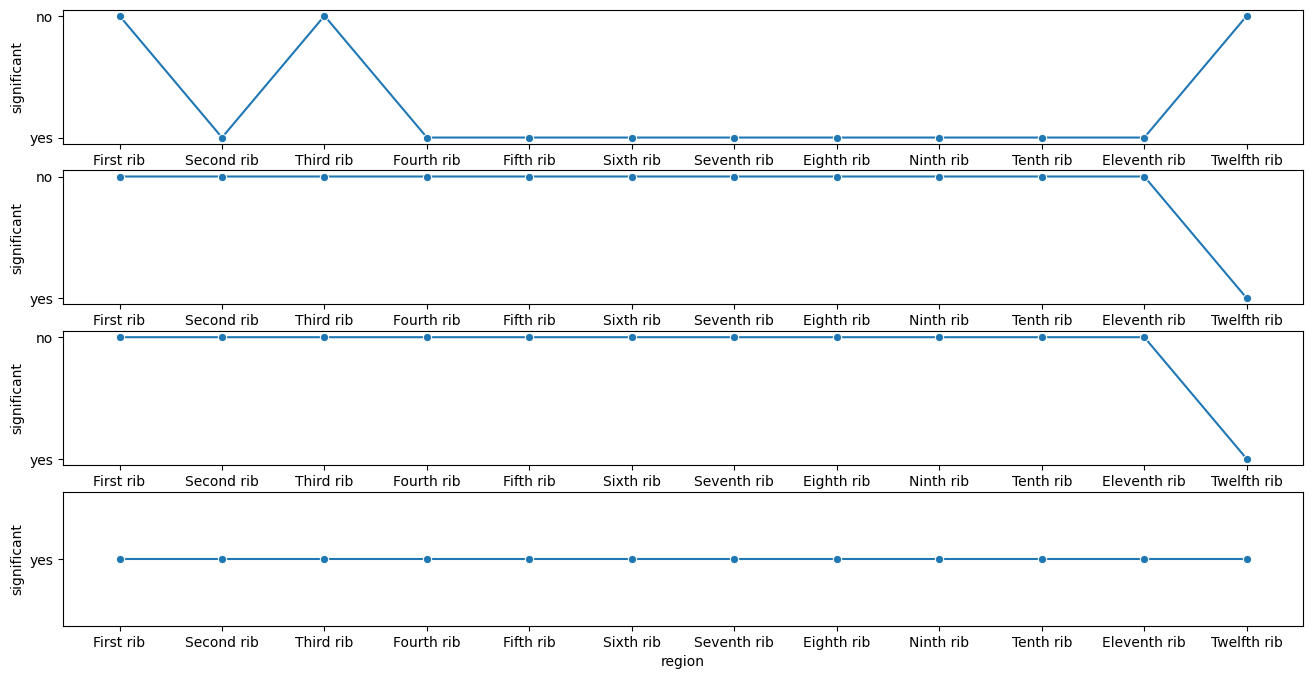

In [104]:
stats_test = ["original_vs_one_filter", "one_filter_vs_two_filter", "two_filter_vs_three_filter", "original_vs_three_filter"]
df_stats_ribs['p_value_binary'] = [1 if f=="yes" else 0 for f in df_stats_ribs['p_value'].values]

plt.figure(figsize=(16,8))

plt.subplot(4,1,1)
ax = sns.lineplot(data=df_stats_ribs[df_stats_ribs['stats_test']==stats_test[0]], x='region', y='significant', marker='o')
ax.set_yticklabels(['no', 'yes'])

plt.subplot(4,1,2)
ax = sns.lineplot(data=df_stats_ribs[df_stats_ribs['stats_test']==stats_test[1]], x='region', y='significant', marker='o')
ax.set_yticklabels(['no', 'yes'])

plt.subplot(4,1,3)
ax = sns.lineplot(data=df_stats_ribs[df_stats_ribs['stats_test']==stats_test[2]], x='region', y='significant', marker='o')
ax.set_yticklabels(['no', 'yes'])

plt.subplot(4,1,4)
ax = sns.lineplot(data=df_stats_ribs[df_stats_ribs['stats_test']==stats_test[3]], x='region', y='significant', marker='o')
ax.set_yticklabels(['yes'])

plt.show()

<Figure size 1200x600 with 0 Axes>

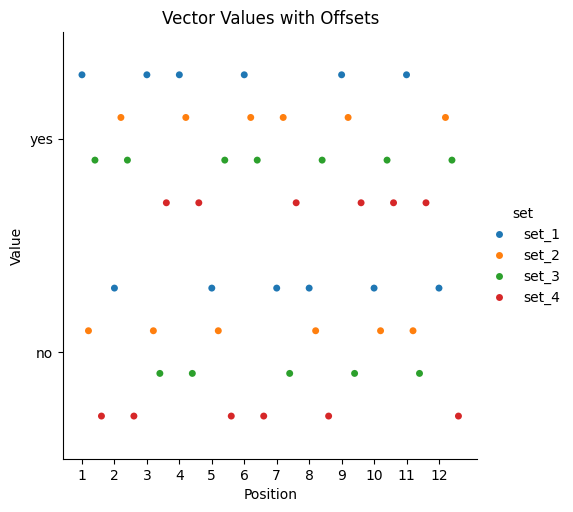

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
vector_set_1 = ['yes', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no']
vector_set_2 = ['no', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes']
vector_set_3 = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes']
vector_set_4 = ['no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'no']

# Create a DataFrame
df = pd.DataFrame({
    'position': list(range(1, 13)) * 4,
    'value': vector_set_1 + vector_set_2 + vector_set_3 + vector_set_4,
    'set': ['set_1'] * 12 + ['set_2'] * 12 + ['set_3'] * 12 + ['set_4'] * 12
})

# Define an offset for each set
offsets = {'set_1': 0, 'set_2': 0.2, 'set_3': 0.4, 'set_4': 0.6}
df['position_offset'] = df['position'] + df['set'].map(offsets)

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.catplot(x='position_offset', y='value', hue='set', data=df, kind='swarm', dodge=True)

# Customize plot
plt.xlabel('Position')
plt.ylabel('Value')
plt.xticks(range(1, 13))
plt.title('Vector Values with Offsets')

# Show plot
plt.show()


# Part 2 - Anatomical consistency - within patient

Here we divide into within patient and within study consistency.

Linear mixed effects - one takes into account patient, and one takes into account study??



In [21]:
# Within study consistency

region = "T1 vertebra"
feature = "Volume from Voxel Summation"

df_plot_region_0 = get_organ_feature(region, feature, table_id, project_name)
df_plot_region_0['Value'] = [np.float32(f)/1000.00 for f in df_plot_region_0['Value'].values]
df_plot_region_0['filter_status'] = ['original'] * len(df_plot_region_0)

# df_plot_region_1 = get_organ_feature_with_segmentation_completeness_no_laterality(region, feature, table_id, project_name)
df_plot_region_1 = get_organ_feature_with_segmentation_completeness_and_vertebrae_every_slice_and_one_connected_component_and_number_of_voxels(region, feature, table_id, project_name)
df_plot_region_1['Value'] = [np.float32(f)/1000.00 for f in df_plot_region_1['Value'].values]
df_plot_region_1['filter_status'] = ['with_filters'] * len(df_plot_region_1)

df_plot_region = pd.concat([df_plot_region_0, df_plot_region_1])

In [22]:
df_plot_region.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value,laterality,filter_status,totalsegSegmentLabel,segmentation_completeness_check
0,132286,1.2.840.113654.2.55.69571713245519885935137963...,1.2.840.113654.2.55.10000830183123495604835259...,72,M,T1 vertebra,21.268555,None,original,NaN,NaN
1,107764,1.2.840.113654.2.55.17158622996185378565487542...,1.2.840.113654.2.55.10000850533416322553665072...,56,M,T1 vertebra,27.758832,None,original,NaN,NaN
2,128370,1.2.840.113654.2.55.26576277676425799146847962...,1.2.840.113654.2.55.10000944692524986099312741...,69,F,T1 vertebra,9.293231,None,original,NaN,NaN
3,129659,1.2.840.113654.2.55.14224315431907123431252487...,1.2.840.113654.2.55.10001102480903211454943302...,59,M,T1 vertebra,13.276914,None,original,NaN,NaN
4,123560,1.2.840.113654.2.55.19994432989699494147310497...,1.2.840.113654.2.55.10001275412896145078730823...,56,F,T1 vertebra,13.692276,None,original,NaN,NaN


In [23]:
set(df_plot_region['filter_status'].values)

{'original', 'with_filters'}

[Text(0.5, 0, 'Original vs with filters'),
 Text(0, 0.5, 'Standard deviation of volumes in mL')]

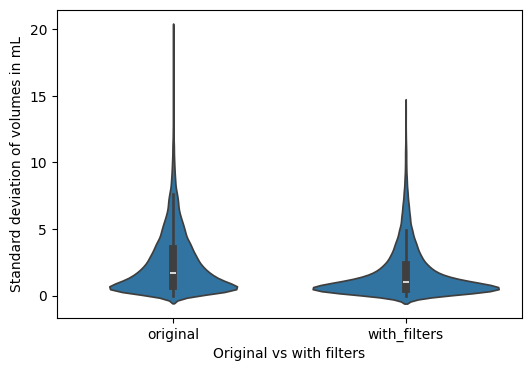

In [24]:
# Violin plot of the standard deviation values, before and after the heuristics

df_plot_region_stddev = df_plot_region.copy(deep=True)

# For each study, group by and get the median
median_volumes = df_plot_region_stddev.groupby('PatientID')['Value'].median()
median_volumes_df = median_volumes.reset_index()
median_volumes_df.columns = ['PatientID', 'Median']

# For each study, group by and get the standard deviation
stddev_volumes = df_plot_region_stddev.groupby('PatientID')['Value'].std()
stddev_volumes_df = stddev_volumes.reset_index()
stddev_volumes_df.columns = ['PatientID', 'Stddev']

# Now add the median value and stddev value as a column to the original dataframe
df_temp = df_plot_region_stddev.merge(median_volumes_df, on='PatientID', how='inner')
df_temp = df_temp.merge(stddev_volumes_df, on='PatientID', how='inner')

df_plot_region_stddev = df_temp.copy(deep=True)

# # Set the datatype
# df_temp['Median'] = [np.float32(f) for f in df_temp['Median'].values]
# df_temp['Stddev'] = [np.float32(f) for f in df_temp]
# df_temp['Value'] = [np.float32(f) for f in df_temp['Value'].values]

# only keep first row of each patient
df_plot_region_stddev_patient = df_plot_region_stddev.copy(deep=True)
df_plot_region_stddev_patient = df_plot_region_stddev.drop_duplicates(subset=['PatientID', 'filter_status'], keep='first')

plt.figure(figsize=(6,4))
ax = sns.violinplot(data=df_plot_region_stddev_patient, x="filter_status", y="Stddev")
ax.set(xlabel='Original vs with filters', ylabel='Standard deviation of volumes in mL')

In [40]:
# add in url
df_plot_region_stddev_patient['viewer_url'] = [os.path.join("https://viewer.imaging.datacommons.cancer.gov/viewer",f) for f in df_plot_region_stddev_patient['StudyInstanceUID'].values]

In [25]:
df_plot_region_stddev_patient.columns

Index(['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age',
       'gender', 'findingSite_CodeMeaning', 'Value', 'laterality',
       'filter_status', 'totalsegSegmentLabel',
       'segmentation_completeness_check', 'Median', 'Stddev'],
      dtype='object')

In [41]:
series_original = df_plot_region_stddev_patient[df_plot_region_stddev_patient['filter_status']=='original']['sourceSegmentedSeriesUID'].values
series_filtered = df_plot_region_stddev_patient[df_plot_region_stddev_patient['filter_status']=="with_filters"]['sourceSegmentedSeriesUID'].values

# Find series that was successfully removed by the outliers
# = difference between series_original and series_filtered
series_removed_by_outliers = list(set(series_original) - set(series_filtered))
df_series_removed_by_outliers = df_plot_region_stddev_patient[df_plot_region_stddev_patient['sourceSegmentedSeriesUID'].isin(series_removed_by_outliers)]
df_series_removed_by_outliers = df_series_removed_by_outliers.sort_values(by='Stddev', ascending=False)

df_series_removed_by_outliers.head(5)

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value,laterality,filter_status,totalsegSegmentLabel,segmentation_completeness_check,Median,Stddev,viewer_url
24649,111030,1.2.840.113654.2.55.18519865252279719014339916...,1.2.840.113654.2.55.11313031577336701975379775...,57,M,T1 vertebra,3.420618,None,original,NaN,NaN,37.336426,19.819165,https://viewer.imaging.datacommons.cancer.gov/...
86355,132644,1.2.840.113654.2.55.12944120303672237424697753...,1.2.840.113654.2.55.19633417389046883830980321...,55,M,T1 vertebra,0.600419,None,original,NaN,NaN,0.600419,18.555893,https://viewer.imaging.datacommons.cancer.gov/...
147083,217679,1.3.6.1.4.1.14519.5.2.1.7009.9004.120151555933...,1.3.6.1.4.1.14519.5.2.1.7009.9004.350035267119...,57,M,T1 vertebra,29.234824,None,original,NaN,NaN,26.179650,15.432132,https://viewer.imaging.datacommons.cancer.gov/...
146690,212431,1.3.6.1.4.1.14519.5.2.1.7009.9004.223606999086...,1.3.6.1.4.1.14519.5.2.1.7009.9004.308974030246...,61,M,T1 vertebra,26.858402,None,original,NaN,NaN,16.089661,15.229301,https://viewer.imaging.datacommons.cancer.gov/...
79875,118243,1.2.840.113654.2.55.12904057215754691253398490...,1.2.840.113654.2.55.17747796811535803052822467...,67,M,T1 vertebra,21.715355,None,original,NaN,NaN,11.000897,15.152533,https://viewer.imaging.datacommons.cancer.gov/...


In [43]:
# Find series that were not successfully removed by the outliers
# = series_filtered
# descending in the standard deviation

df_series_not_removed_by_outliers = df_plot_region_stddev_patient[df_plot_region_stddev_patient['filter_status']=="with_filters"]
df_series_not_removed_by_outliers = df_series_not_removed_by_outliers.sort_values(by='Stddev', ascending=False)
df_series_not_removed_by_outliers.head(5)

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value,laterality,filter_status,totalsegSegmentLabel,segmentation_completeness_check,Median,Stddev,viewer_url
43525,113474,1.2.840.113654.2.55.13510392706144266295224158...,1.2.840.113654.2.55.26738461339656820768280304...,56,M,T1 vertebra,26.693727,None,with_filters,vertebrae_T1,may_be_segmented_fully,15.396882,14.120906,https://viewer.imaging.datacommons.cancer.gov/...
22134,127916,1.2.840.113654.2.55.40234939992048659799897962...,1.2.840.113654.2.55.21990165897737186460550260...,70,M,T1 vertebra,30.109590,None,with_filters,vertebrae_T1,may_be_segmented_fully,26.292369,13.814006,https://viewer.imaging.datacommons.cancer.gov/...
47398,100212,1.2.840.113654.2.55.20769953399918588282860382...,1.2.840.113654.2.55.27499110090398492251000963...,56,M,T1 vertebra,31.916514,None,with_filters,vertebrae_T1,may_be_segmented_fully,31.181459,13.403046,https://viewer.imaging.datacommons.cancer.gov/...
94421,115534,1.2.840.113654.2.55.11122574994365573246037500...,1.2.840.113654.2.55.42309565427503536864856407...,70,M,T1 vertebra,29.104004,None,with_filters,vertebrae_T1,may_be_segmented_fully,24.893646,12.336489,https://viewer.imaging.datacommons.cancer.gov/...
110660,200947,1.3.6.1.4.1.14519.5.2.1.7009.9004.184273196711...,1.3.6.1.4.1.14519.5.2.1.7009.9004.141699745651...,64,M,T1 vertebra,24.741688,None,with_filters,vertebrae_T1,may_be_segmented_fully,24.741688,12.104198,https://viewer.imaging.datacommons.cancer.gov/...


# Part 3 - Population study

Here we create three types of plots:
1. Number of series per vertebrae original, applying segmentation completeness, applying segmentation completeness and vertebrae at every slice
2. Vertebrae volume after applying the 2 heuristics (segmentation completeness and vertebrae at every slice)
3. Vertebrae volume compared to literature

## Vertebral volumes - applying heuristics

In [45]:
region1_list = ['C1 vertebra', 'C2 vertebra', 'C3 vertebra', 'C4 vertebra', 'C5 vertebra', 'C6 vertebra', 'C7 vertebra', 'T1 vertebra', 'T2 vertebra', 'T3 vertebra', 'T4 vertebra', 'T5 vertebra', 'T6 vertebra', 'T7 vertebra', 'T8 vertebra', 'T9 vertebra', 'T10 vertebra', 'T11 vertebra', 'T12 vertebra', 'L1 vertebra', 'L2 vertebra', 'L3 vertebra', 'L4 vertebra', 'L5 vertebra']
feature = "Volume from Voxel Summation"

# 0 - original,
# 1 - with segmentation completeness
# 2 - with segmentation completeness and vertebrae at every slice
# 3 - with segmetnation completeness, vertebrae at every slice, and one connected components
# 4 - with segmetnation completeness, vertebrae at every slice, and one connected components, and number of voxels >= 1000
df_plot_filters_0 = pd.DataFrame()
df_plot_filters_1 = pd.DataFrame()
df_plot_filters_2 = pd.DataFrame()
df_plot_filters_3 = pd.DataFrame()
df_plot_filters_4 = pd.DataFrame()

for region1 in region1_list:
  print(region1)
  # Original
  df = get_organ_feature(region1, feature, table_id, project_name)
  df_plot_filters_0 = pd.concat([df_plot_filters_0, df])
  # With segmentation completeness
  # df = get_organ_feature_with_segmentation_completeness(region1, feature, table_id, project_name)
  df = get_organ_feature_with_segmentation_completeness_no_laterality(region1, feature, table_id, project_name)
  df_plot_filters_1 = pd.concat([df_plot_filters_1, df])
  # With segmentation completeness and vertebrae every slice
  df = get_organ_feature_with_segmentation_completeness_and_vertebrae_every_slice(region1, feature, table_id, project_name)
  df_plot_filters_2 = pd.concat([df_plot_filters_2, df])
  # With segmentation completeness, vertebrae every slice, and num components = 1
  df = get_organ_feature_with_segmentation_completeness_and_vertebrae_every_slice_and_one_connected_component(region1, feature, table_id, project_name)
  df_plot_filters_3 = pd.concat([df_plot_filters_3, df])
  # With segmentation completeness, vertebrae every slice, num components = 1, num_voxels >= 1000
  df = get_organ_feature_with_segmentation_completeness_and_vertebrae_every_slice_and_one_connected_component_and_number_of_voxels(region1, feature, table_id, project_name)
  df_plot_filters_4 = pd.concat([df_plot_filters_4, df])


C1 vertebra
C2 vertebra
C3 vertebra
C4 vertebra
C5 vertebra
C6 vertebra
C7 vertebra
T1 vertebra
T2 vertebra
T3 vertebra
T4 vertebra
T5 vertebra
T6 vertebra
T7 vertebra
T8 vertebra
T9 vertebra
T10 vertebra
T11 vertebra
T12 vertebra
L1 vertebra
L2 vertebra
L3 vertebra
L4 vertebra
L5 vertebra


In [46]:
### Get numeric column and convert to mL ###
# Original
new_column = [np.float32(f) for f in df_plot_filters_0['Value'].values]
df_plot_filters_0['Value_numeric'] = new_column
df_plot_filters_0['Value_numeric'] = df_plot_filters_0['Value_numeric'] / 1000.00
# With segmentation completeness
new_column = [np.float32(f) for f in df_plot_filters_1['Value'].values]
df_plot_filters_1['Value_numeric'] = new_column
df_plot_filters_1['Value_numeric'] = df_plot_filters_1['Value_numeric'] / 1000.00
# With segmentation completeness and vertebrae every slice
new_column = [np.float32(f) for f in df_plot_filters_2['Value'].values]
df_plot_filters_2['Value_numeric'] = new_column
df_plot_filters_2['Value_numeric'] = df_plot_filters_2['Value_numeric'] / 1000.00
# With segmentation completeness and vertebrae every slice, and number of components = 1
new_column = [np.float32(f) for f in df_plot_filters_3['Value'].values]
df_plot_filters_3['Value_numeric'] = new_column
df_plot_filters_3['Value_numeric'] = df_plot_filters_3['Value_numeric'] / 1000.00
# With segmentation completeness and vertebrae every slice, and number of components = 1, and number of voxels >= 1000
new_column = [np.float32(f) for f in df_plot_filters_4['Value'].values]
df_plot_filters_4['Value_numeric'] = new_column
df_plot_filters_4['Value_numeric'] = df_plot_filters_4['Value_numeric'] / 1000.00

# check for duplicates
# remove duplicate rows -- why do I get that from the query?!
# df_plot = df_plot.drop_duplicates()

Plot a comparison of the number of series  - original, with segmentation completeness, and with segmentation completeness and vertebrae at every slice

In [47]:
# Plot a comparison of the number of series - 3 histograms

num_series_df = pd.DataFrame()
num_series_0 = []
num_series_1 = []
num_series_2 = []
num_series_3 = []
num_series_4 = []
for region1 in region1_list:
  num_series_0.append(len(df_plot_filters_0[df_plot_filters_0['findingSite_CodeMeaning']==region1]))
  num_series_1.append(len(df_plot_filters_1[df_plot_filters_1['findingSite_CodeMeaning']==region1]))
  num_series_2.append(len(df_plot_filters_2[df_plot_filters_2['findingSite_CodeMeaning']==region1]))
  num_series_3.append(len(df_plot_filters_3[df_plot_filters_3['findingSite_CodeMeaning']==region1]))
  num_series_4.append(len(df_plot_filters_4[df_plot_filters_4['findingSite_CodeMeaning']==region1]))
num_series_df['region'] = region1_list
num_series_df['num_series_original'] = num_series_0
num_series_df['num_series_with_segmentation_completeness'] = num_series_1
num_series_df['num_series_with_segmentation_completeness_and_vertebrae_every_slice'] = num_series_2
num_series_df['num_series_with_segmentation_completeness_and_vertebrae_every_slice_and_single_component'] = num_series_3
num_series_df['num_series_with_segmentation_completeness_and_vertebrae_every_slice_and_single_component_and_number_of_voxels'] = num_series_4


In [48]:
num_series_df

,region,num_series_original,num_series_with_segmentation_completeness,num_series_with_segmentation_completeness_and_vertebrae_every_slice,num_series_with_segmentation_completeness_and_vertebrae_every_slice_and_single_component,num_series_with_segmentation_completeness_and_vertebrae_every_slice_and_single_component_and_number_of_voxels
0,C1 vertebra,51,36,36,29,4
1,C2 vertebra,38,5,5,5,3
2,C3 vertebra,163,6,6,3,3
3,C4 vertebra,860,32,32,24,11
4,C5 vertebra,8889,136,136,64,41
5,C6 vertebra,50208,609,609,406,297
6,C7 vertebra,121443,3554,3554,2630,2606
7,T1 vertebra,125507,23902,23902,21869,21860
8,T2 vertebra,125547,105453,105453,99566,99548
9,T3 vertebra,125531,125319,125319,108963,108929


In [ ]:
# Overlapping histograms

df_plot_hist = pd.DataFrame()
df_plot_filters_0['heuristic'] = len(df_plot_filters_0) * ['original']
df_plot_filters_1['heuristic'] = len(df_plot_filters_1) * ['with_heuristic_1']
df_plot_filters_2['heuristic'] = len(df_plot_filters_2) * ['with_heuristic_1_2']
df_plot_filters_3['heuristic'] = len(df_plot_filters_3) * ['with_heuristic_1_2_3']
df_plot_filters_4['heuristic'] = len(df_plot_filters_4) * ['with_heuristic_1_2_3_4']
df_plot_hist = pd.concat([df_plot_filters_0, df_plot_filters_1, df_plot_filters_2, df_plot_filters_3, df_plot_filters_4])

df_plot_hist['findingSite_CodeMeaning_short'] = [f[0:3] for f in df_plot_hist['findingSite_CodeMeaning'].values]

heuristics_list = [['original'],
                   ['original', 'with_heuristic_1'],
                   ['original', 'with_heuristic_1', 'with_heuristic_1_2'],
                   ['original', 'with_heuristic_1', 'with_heuristic_1_2', 'with_heuristic_1_2_3'],
                   ['original', 'with_heuristic_1', 'with_heuristic_1_2', 'with_heuristic_1_2_3', 'with_heuristic_1_2_3_4']]


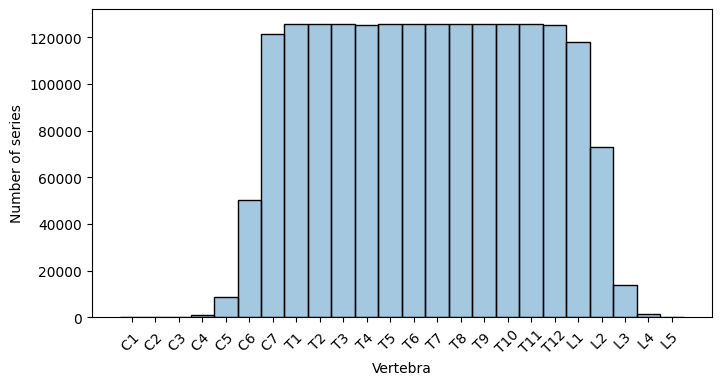

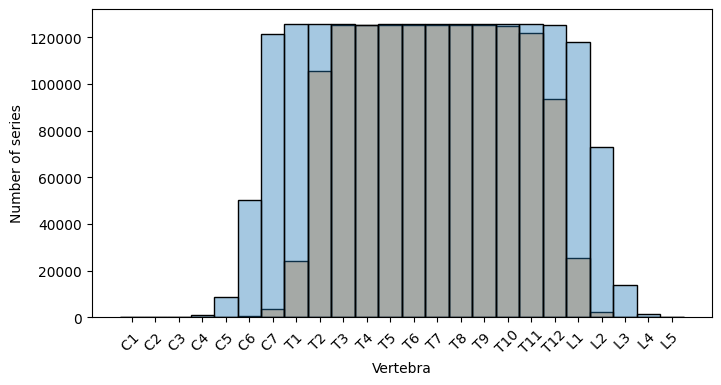

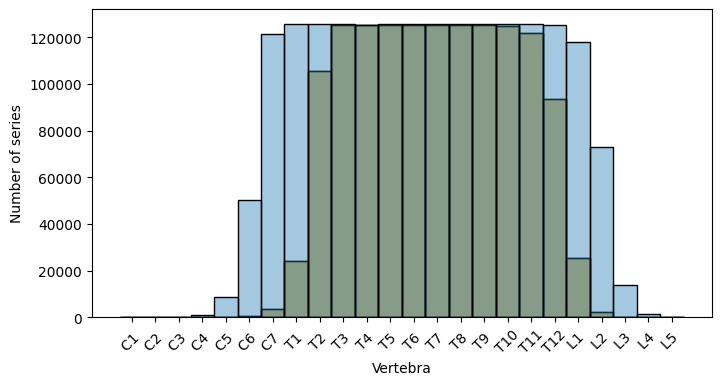

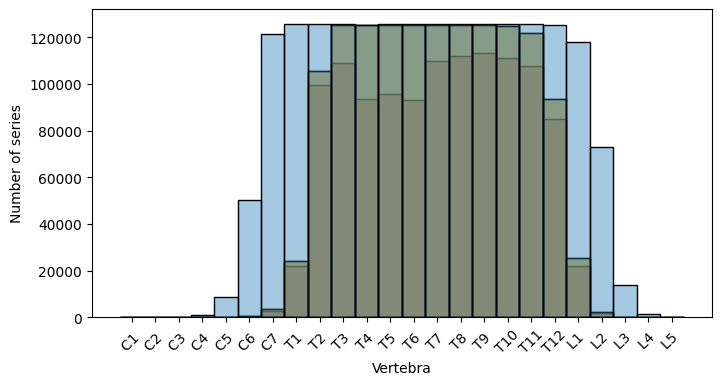

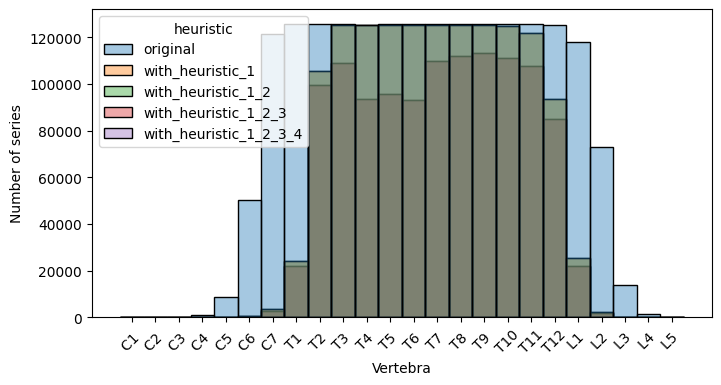

In [80]:

for n in range(0,5):
  fig = plt.figure(figsize=(8,4))
  df_plot_hist_subset = df_plot_hist[df_plot_hist['heuristic'].isin(heuristics_list[n])]
  ax = sns.histplot(data=df_plot_hist_subset, x="findingSite_CodeMeaning_short", hue='heuristic', alpha=0.4)
  plt.xticks(rotation=45)
  ax.set_xlabel('Vertebra')
  ax.set_ylabel('Number of series')
  # plt.gca().legend.set_visible(False)
  if n<4:
    plt.legend([],[], frameon=False)
  plt.show()

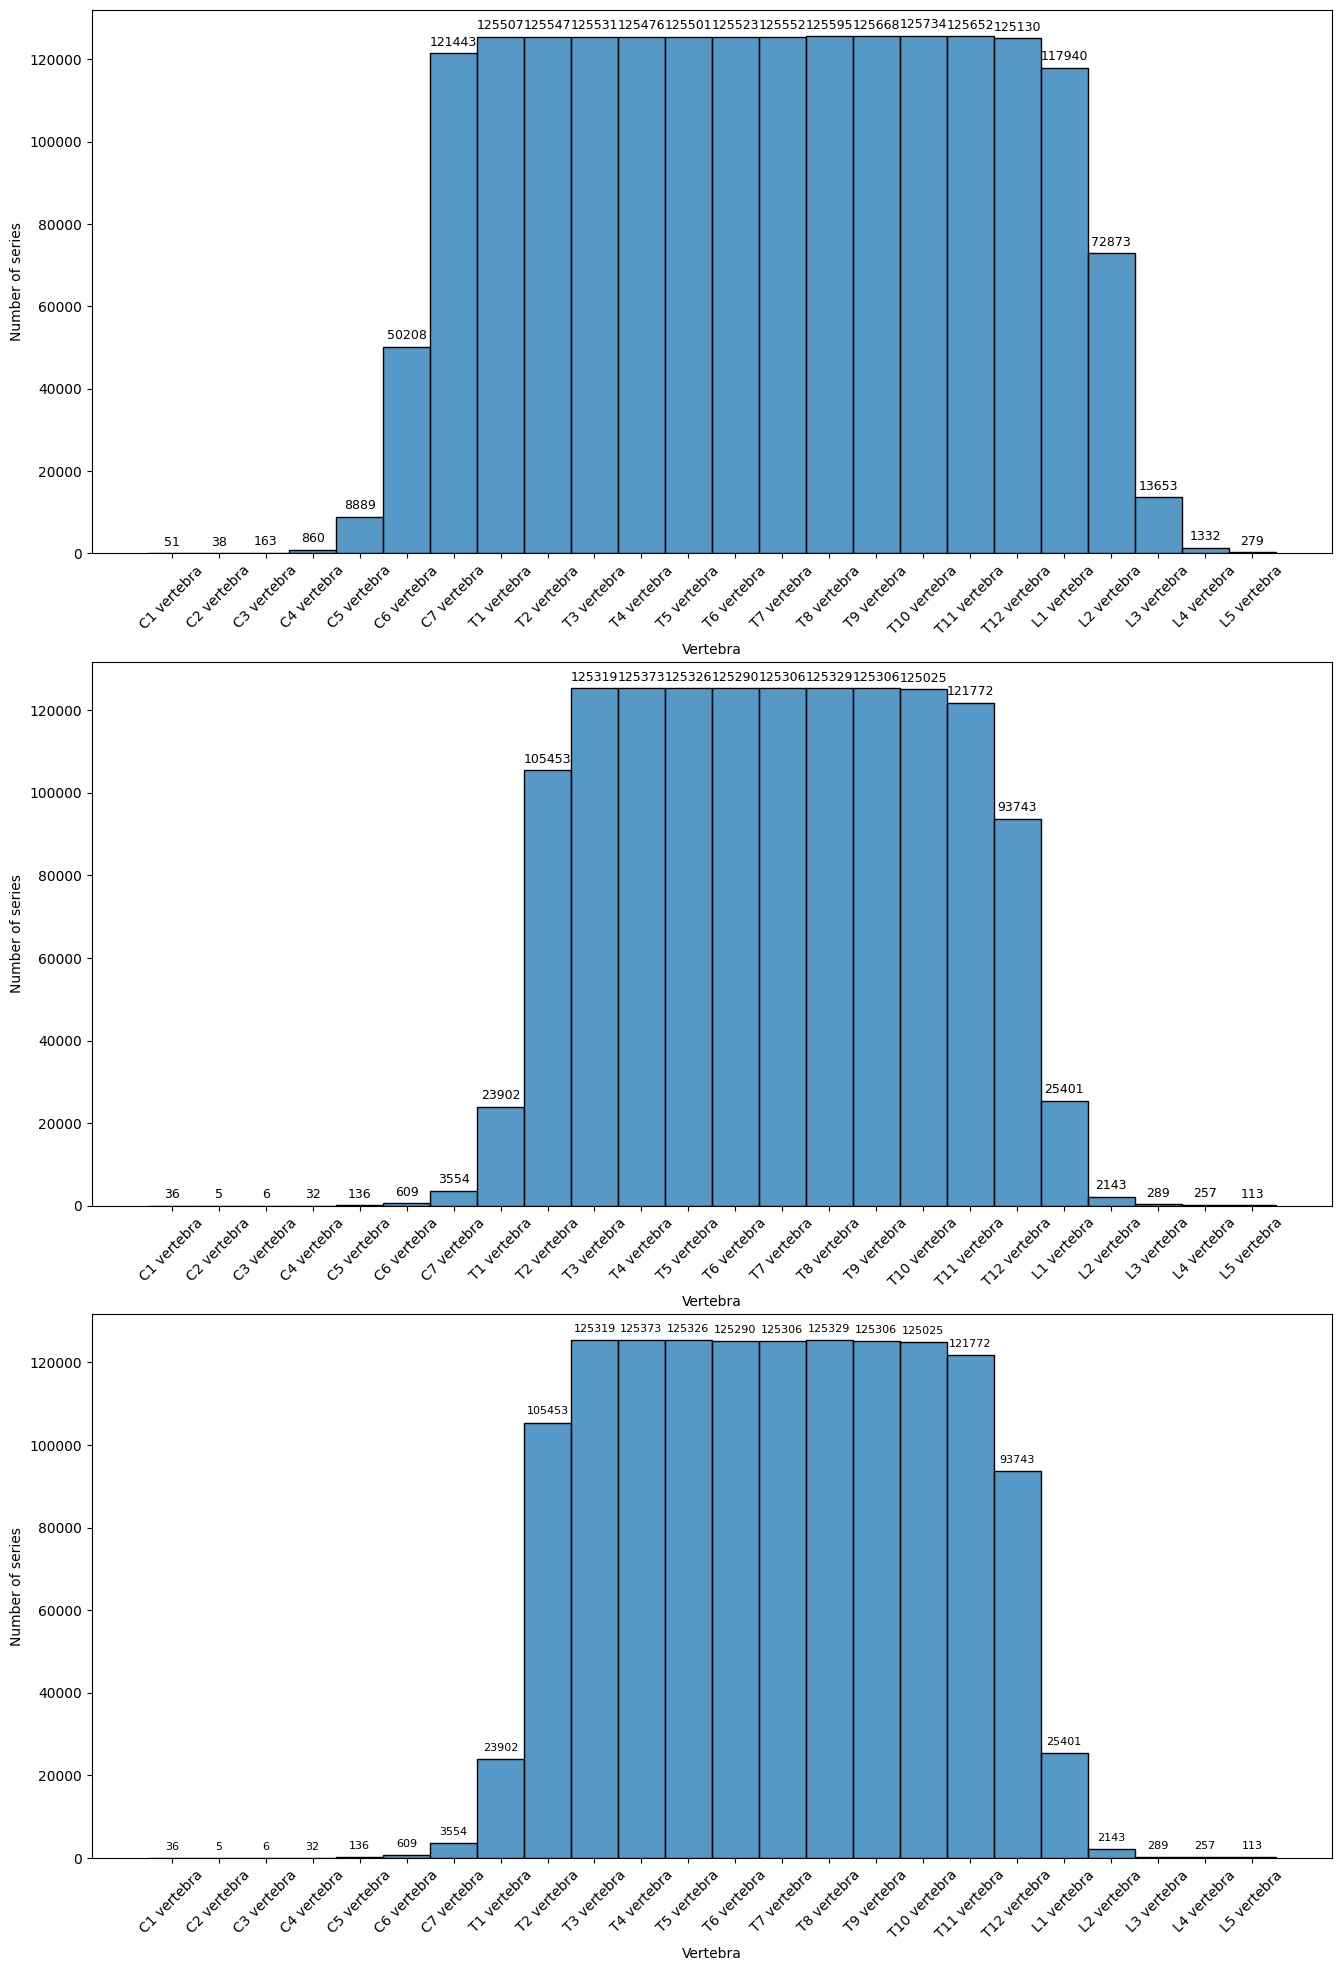

In [ ]:
# Individual histograms for each heuristic addition

# https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/#

# Histogram with the number of series per vertebrae

fig = plt.figure(figsize=(16,24))

plt.subplot(3,1,1),
ax = sns.histplot(data=df_plot_filters_0, x="findingSite_CodeMeaning")
plt.xticks(rotation=45)
ax.set_xlabel('Vertebra')
ax.set_ylabel('Number of series')

# Iterating over the bars one-by-one
for bar in ax.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax.annotate(format(bar.get_height(), 'd'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 8),
                   textcoords='offset points')

plt.subplot(3,1,2),
ax = sns.histplot(data=df_plot_filters_1, x="findingSite_CodeMeaning")
plt.xticks(rotation=45)
ax.set_xlabel('Vertebra')
ax.set_ylabel('Number of series')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), 'd'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 8),
                   textcoords='offset points')


plt.subplot(3,1,3),
ax = sns.histplot(data=df_plot_filters_2, x="findingSite_CodeMeaning")
plt.xticks(rotation=45)
ax.set_xlabel('Vertebra')
ax.set_ylabel('Number of series')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), 'd'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

Box plot of the volume after the two heuristics are applied

Text(0.5, 0, 'Vertebra')

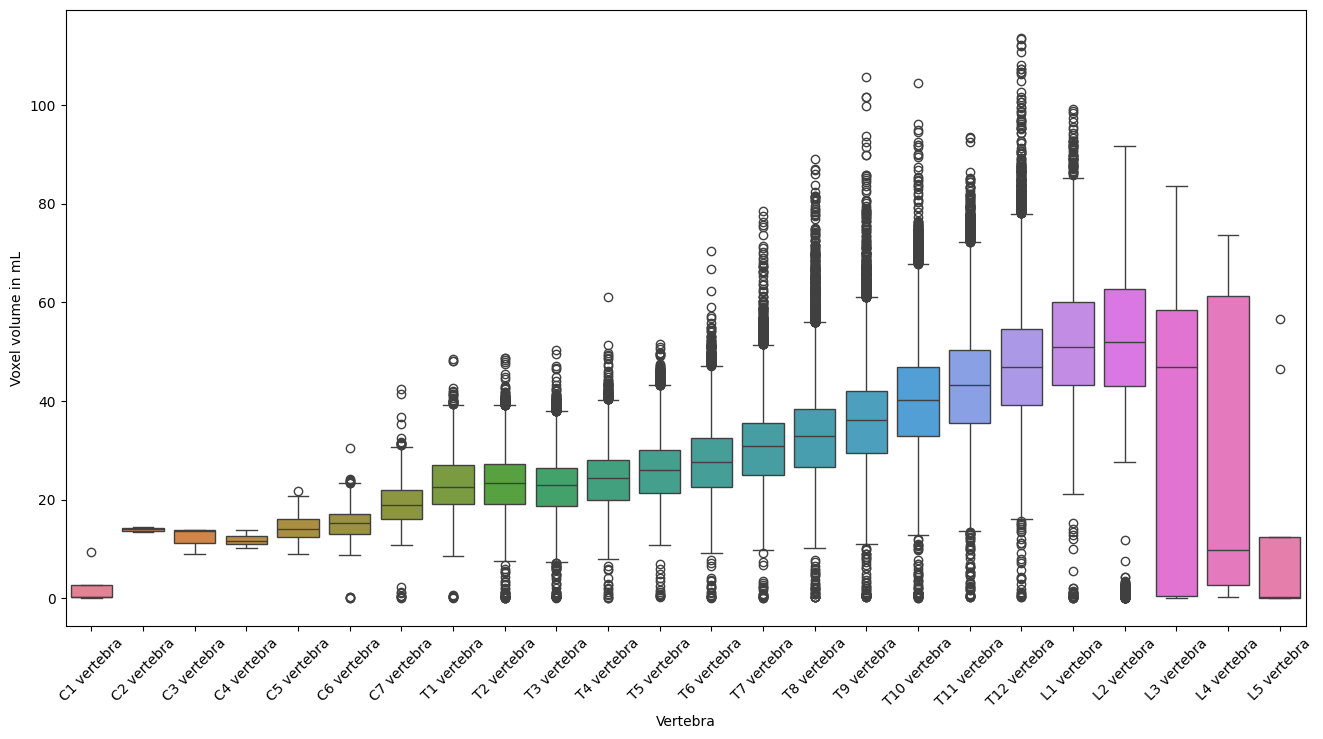

In [98]:
fig = plt.figure(figsize=(16, 8))

ax = sns.boxplot(data=df_plot_filters_4, x="findingSite_CodeMeaning", y="Value_numeric", order=region1_list, hue="findingSite_CodeMeaning")
plt.xticks(rotation=45)
ax.set_ylabel("Voxel volume in mL")
ax.set_xlabel("Vertebra")

Comparison to literature

In [87]:
# Get the unique number of patients, series, and the gender ratio

num_patients = len(set(df_plot_filters_4['PatientID'].values))
num_studies = len(set(df_plot_filters_4['StudyInstanceUID'].values))
num_series = len(set(df_plot_filters_4['sourceSegmentedSeriesUID'].values))
df_plot_keep_gender = df_plot_filters_4.drop_duplicates(['PatientID', 'gender'])
num_male_patients = len(df_plot_keep_gender[df_plot_keep_gender['gender']=='M'])
male_patients_ratio = num_male_patients / num_patients

print('num_patients: ' + str(num_patients))
print('num_studies: ' + str(num_studies))
print('num_series: ' + str(num_series))
print('num_male_patients: ' + str(num_male_patients))
print('male_patients_ratio: ' + str(male_patients_ratio))


num_patients: 26194
num_studies: 71580
num_series: 125753
num_male_patients: 15478
male_patients_ratio: 0.5908986790868138


In [88]:
# Create a combined dataframe

df_plot_vertebrae = pd.DataFrame()
df_plot_filters_0['filter_status'] = ['original'] * len(df_plot_filters_0)
df_plot_filters_1['filter_status'] = ['with_one_filter'] * len(df_plot_filters_1)
df_plot_filters_2['filter_status'] = ['with_two_filter'] * len(df_plot_filters_2)
df_plot_filters_3['filter_status'] = ['with_three_filter'] * len(df_plot_filters_3)
df_plot_filters_4['filter_status'] = ['with_four_filter'] * len(df_plot_filters_4)
df_plot_vertebrae = pd.concat([df_plot_filters_0, df_plot_filters_1, df_plot_filters_2, df_plot_filters_3, df_plot_filters_4])

Text(0.5, 0, 'Vertebra')

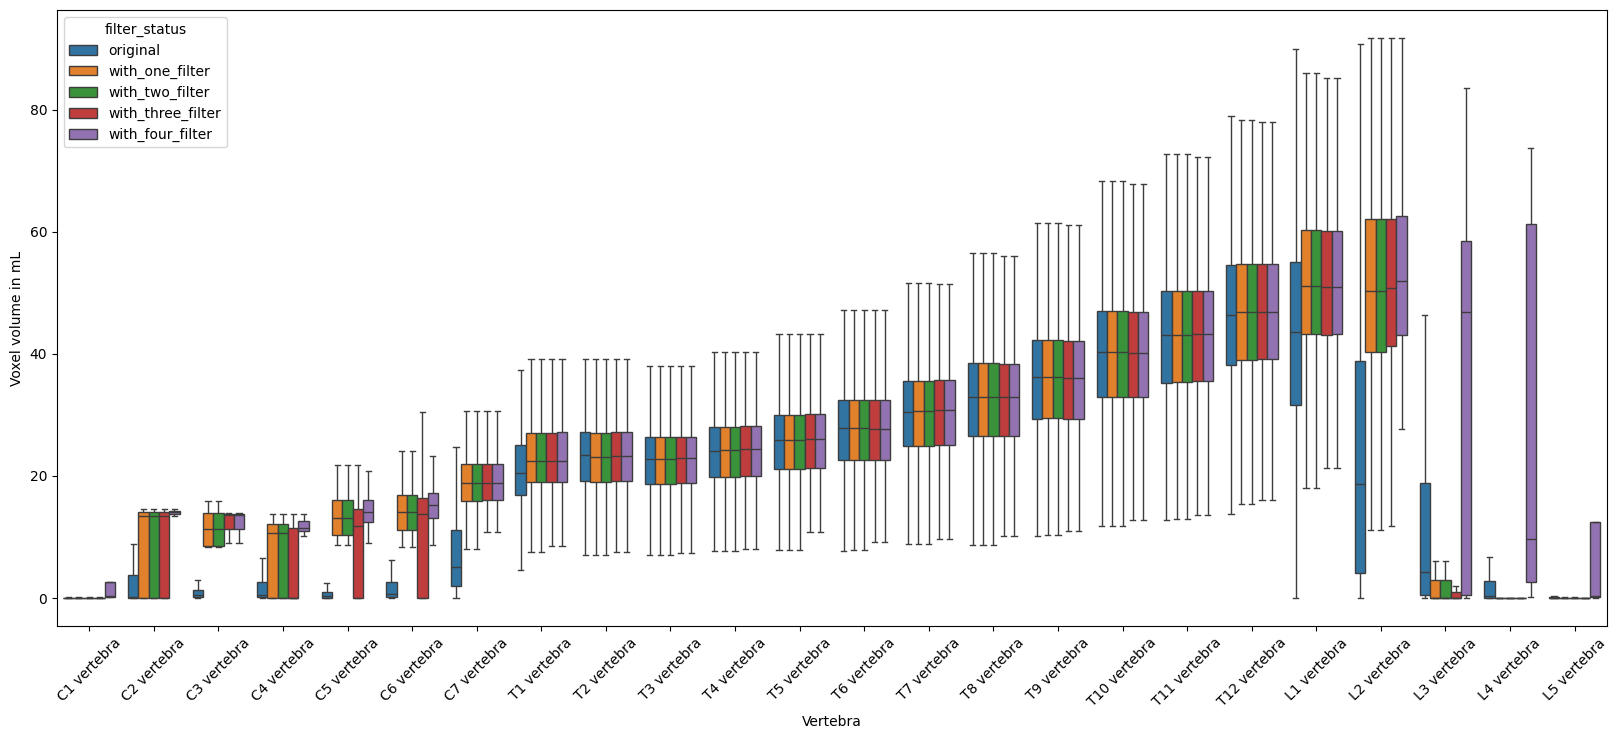

In [89]:
fig = plt.figure(figsize=(20, 8))

ax = sns.boxplot(data=df_plot_vertebrae, x="findingSite_CodeMeaning", y="Value_numeric", order=region1_list, hue="filter_status", showfliers=False)
plt.xticks(rotation=45)
ax.set_ylabel("Voxel volume in mL")
ax.set_xlabel("Vertebra")

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 [Text(0.0, 0, 'C1 vertebra'),
  Text(1.0, 0, 'C2 vertebra'),
  Text(2.0, 0, 'C3 vertebra'),
  Text(3.0, 0, 'C4 vertebra'),
  Text(4.0, 0, 'C5 vertebra'),
  Text(5.0, 0, 'C6 vertebra'),
  Text(6.0, 0, 'C7 vertebra'),
  Text(7.0, 0, 'T1 vertebra'),
  Text(8.0, 0, 'T2 vertebra'),
  Text(9.0, 0, 'T3 vertebra'),
  Text(10.0, 0, 'T4 vertebra'),
  Text(11.0, 0, 'T5 vertebra'),
  Text(12.0, 0, 'T6 vertebra'),
  Text(13.0, 0, 'T7 vertebra'),
  Text(14.0, 0, 'T8 vertebra'),
  Text(15.0, 0, 'T9 vertebra'),
  Text(16.0, 0, 'T10 vertebra'),
  Text(17.0, 0, 'T11 vertebra'),
  Text(18.0, 0, 'T12 vertebra'),
  Text(19.0, 0, 'L1 vertebra'),
  Text(20.0, 0, 'L2 vertebra'),
  Text(21.0, 0, 'L3 vertebra'),
  Text(22.0, 0, 'L4 vertebra'),
  Text(23.0, 0, 'L5 vertebra')])

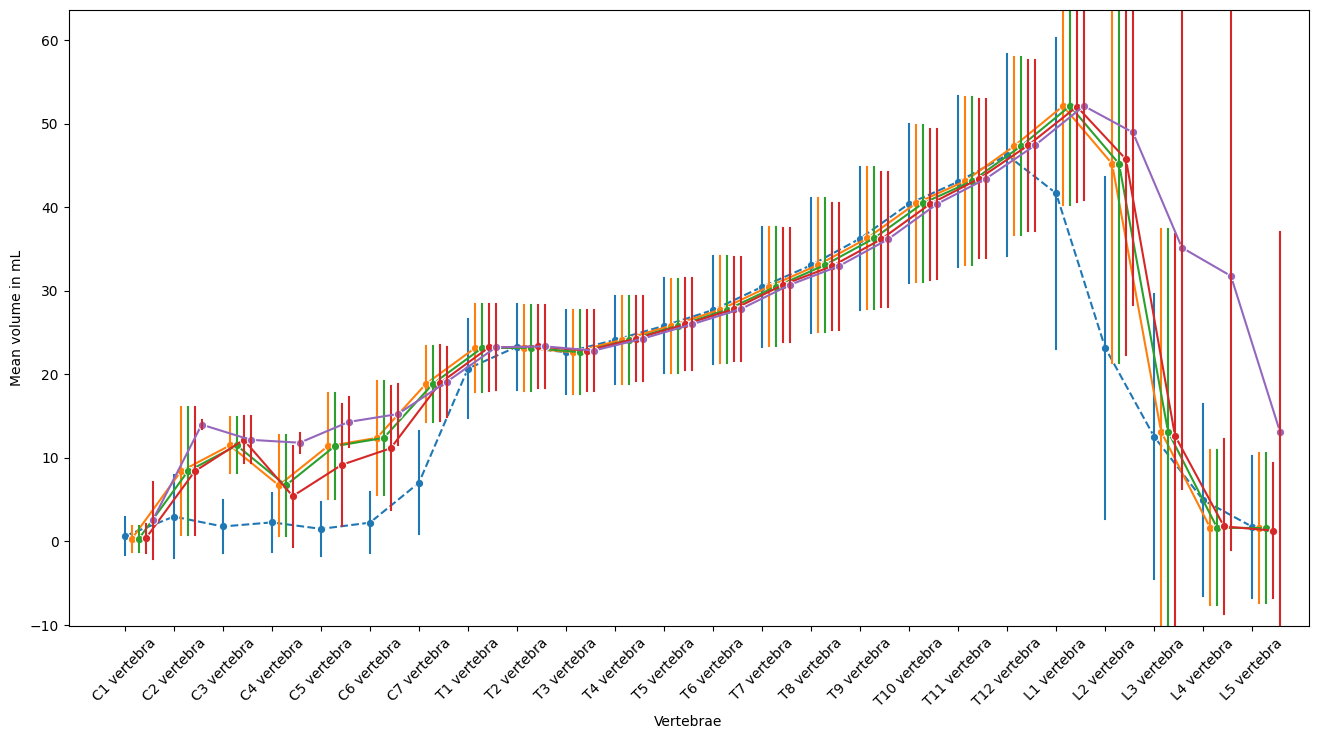

In [83]:
# Create a plot with the changes of adding each heuristic
# original
# segmenation completeness
# segmentation completeness and vertebra in every slice
# segmentation completeness, vertebrae in every slice, and number of components = 1


# https://stackoverflow.com/questions/43126064/how-do-i-shift-categorical-scatter-markers-to-left-and-right-above-xticks-multi

import matplotlib.transforms as transforms

### Calculate the mean and stddev ###

mean_cv = df_plot_vertebrae.groupby(['filter_status', 'findingSite_CodeMeaning'])['Value_numeric'].mean()
mean_cv_df = mean_cv.reset_index()
mean_cv_df.columns = ['filter_status', 'findingSite_CodeMeaning', 'Value_numeric_mean']

stddev_cv = df_plot_vertebrae.groupby(['filter_status', 'findingSite_CodeMeaning'])['Value_numeric'].std()
stddev_cv_df = stddev_cv.reset_index()
stddev_cv_df.columns = ['filter_status', 'findingSite_CodeMeaning', 'Value_numeric_stddev']

df_cv = pd.DataFrame()
df_cv = mean_cv_df.merge(stddev_cv_df, on=['filter_status', 'findingSite_CodeMeaning'], how='inner')

# Define order of vertebrae we want
vertebrae_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7',
                  'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12',
                  'L1', 'L2', 'L3', 'L4', 'L5']
vertebrae_list = [f + ' vertebra' for f in vertebrae_list]

# Create a dictionary to map the vertebrae_list to their corresponding indices
vertebrae_index_map = {vertebrae: idx for idx, vertebrae in enumerate(vertebrae_list)}

df_cv_original = df_cv[df_cv['filter_status']=='original']
df_cv_filter_1 = df_cv[df_cv['filter_status']=="with_one_filter"]
df_cv_filter_2 = df_cv[df_cv['filter_status']=="with_two_filter"]
df_cv_filter_3 = df_cv[df_cv['filter_status']=="with_three_filter"]
df_cv_filter_4 = df_cv[df_cv['filter_status']=="with_four_filter"]

# Add a new column with the corresponding index for each rib
df_cv_original['vertebrae_index'] = df_cv_original['findingSite_CodeMeaning'].map(vertebrae_index_map)
df_cv_filter_1['vertebrae_index'] = df_cv_filter_1['findingSite_CodeMeaning'].map(vertebrae_index_map)
df_cv_filter_2['vertebrae_index'] = df_cv_filter_2['findingSite_CodeMeaning'].map(vertebrae_index_map)
df_cv_filter_3['vertebrae_index'] = df_cv_filter_3['findingSite_CodeMeaning'].map(vertebrae_index_map)
df_cv_filter_4['vertebrae_index'] = df_cv_filter_4['findingSite_CodeMeaning'].map(vertebrae_index_map)

# Sort the DataFrame based on the ribs_index column
df_cv_original_sorted = df_cv_original.sort_values(by=['vertebrae_index'])
df_cv_filter_1_sorted = df_cv_filter_1.sort_values(by=['vertebrae_index'])
df_cv_filter_2_sorted = df_cv_filter_2.sort_values(by=['vertebrae_index'])
df_cv_filter_3_sorted = df_cv_filter_3.sort_values(by=['vertebrae_index'])
df_cv_filter_4_sorted = df_cv_filter_4.sort_values(by=['vertebrae_index'])

# Drop the temporary ribs_index column
df_cv_original_sorted.drop(columns=['vertebrae_index'], inplace=True)
df_cv_filter_1_sorted.drop(columns=['vertebrae_index'], inplace=True)
df_cv_filter_2_sorted.drop(columns=['vertebrae_index'], inplace=True)
df_cv_filter_3_sorted.drop(columns=['vertebrae_index'], inplace=True)
df_cv_filter_4_sorted.drop(columns=['vertebrae_index'], inplace=True)

df_cv_original = df_cv_original_sorted.copy(deep=True)
df_cv_filter_1 = df_cv_filter_1_sorted.copy(deep=True)
df_cv_filter_2 = df_cv_filter_2_sorted.copy(deep=True)
df_cv_filter_3 = df_cv_filter_3_sorted.copy(deep=True)
df_cv_filter_4 = df_cv_filter_4_sorted.copy(deep=True)

### Plot ###

fig = plt.figure(figsize=(16,8))

offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# original
ax = sns.lineplot(data=df_cv_original, x = 'findingSite_CodeMeaning', y = 'Value_numeric_mean' , marker='o')
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(vertebrae_list)-1,len(vertebrae_list)))
ax.set_xticklabels(vertebrae_list)
ax.set_xlabel('Vertebrae')
ax.set_ylabel('Mean volume in mL')
for n in range(0,len(df_cv_original)):
  plt.plot([n, n],
          [df_cv_original['Value_numeric_mean'].values[n] - df_cv_original['Value_numeric_stddev'].values[n], df_cv_original['Value_numeric_mean'].values[n] + df_cv_original['Value_numeric_stddev'].values[n]],
          c='C0')

# with 1 filter
ax = sns.lineplot(data=df_cv_filter_1, x = 'findingSite_CodeMeaning', y = 'Value_numeric_mean' , marker='o', transform=trans+offset(5))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(vertebrae_list)-1,len(vertebrae_list)))
ax.set_xticklabels(vertebrae_list)
ax.set_xlabel('Vertebrae')
ax.set_ylabel('Mean volume in mL')
for n in range(0,len(df_cv_filter_1)):
  plt.plot([n, n],
          [df_cv_filter_1['Value_numeric_mean'].values[n] - df_cv_filter_1['Value_numeric_stddev'].values[n], df_cv_filter_1['Value_numeric_mean'].values[n] + df_cv_filter_1['Value_numeric_stddev'].values[n]],
          c='C1',
          transform=trans+offset(5))

# with 2 filter
ax = sns.lineplot(data=df_cv_filter_2, x = 'findingSite_CodeMeaning', y = 'Value_numeric_mean' , marker='o', transform=trans+offset(10))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(vertebrae_list)-1,len(vertebrae_list)))
ax.set_xticklabels(vertebrae_list)
ax.set_xlabel('Vertebrae')
ax.set_ylabel('Mean volume in mL')
for n in range(0,len(df_cv_filter_2)):
  plt.plot([n, n],
          [df_cv_filter_2['Value_numeric_mean'].values[n] - df_cv_filter_2['Value_numeric_stddev'].values[n], df_cv_filter_2['Value_numeric_mean'].values[n] + df_cv_filter_2['Value_numeric_stddev'].values[n]],
          c='C2',
          transform=trans+offset(10))

# with 3 filter
ax = sns.lineplot(data=df_cv_filter_3, x = 'findingSite_CodeMeaning', y = 'Value_numeric_mean' , marker='o', transform=trans+offset(15))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(vertebrae_list)-1,len(vertebrae_list)))
ax.set_xticklabels(vertebrae_list)
ax.set_xlabel('Vertebrae')
ax.set_ylabel('Mean volume in mL')
for n in range(0,len(df_cv_filter_3)):
  plt.plot([n, n],
          [df_cv_filter_3['Value_numeric_mean'].values[n] - df_cv_filter_3['Value_numeric_stddev'].values[n], df_cv_filter_3['Value_numeric_mean'].values[n] + df_cv_filter_3['Value_numeric_stddev'].values[n]],
          c='C3',
          transform=trans+offset(15))
plt.xticks(rotation=45)

# with 4 filter
ax = sns.lineplot(data=df_cv_filter_4, x = 'findingSite_CodeMeaning', y = 'Value_numeric_mean' , marker='o', transform=trans+offset(20))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(vertebrae_list)-1,len(vertebrae_list)))
ax.set_xticklabels(vertebrae_list)
ax.set_xlabel('Vertebrae')
ax.set_ylabel('Mean volume in mL')
for n in range(0,len(df_cv_filter_4)):
  plt.plot([n, n],
          [df_cv_filter_4['Value_numeric_mean'].values[n] - df_cv_filter_4['Value_numeric_stddev'].values[n], df_cv_filter_4['Value_numeric_mean'].values[n] + df_cv_filter_4['Value_numeric_stddev'].values[n]],
          c='C3',
          transform=trans+offset(20))
plt.xticks(rotation=45)

In [97]:
def plot_mean_and_std_vertebra(df_plot, region1_list):


  df_plot_males = df_plot[df_plot['gender']=="M"]
  df_plot_females = df_plot[df_plot["gender"]=="F"]
  # df_plot_males = df_plot_keep_1000[df_plot_keep_1000['gender']=="M"]
  # df_plot_females = df_plot_keep_1000[df_plot_keep_1000['gender']=="F"]

  mean_males = []
  mean_females = []
  std_males = []
  std_females = []
  for region in region1_list:
    mean_male = np.mean(df_plot_males[df_plot_males['findingSite_CodeMeaning'] == region]['Value_numeric'].values)
    mean_female = np.mean(df_plot_females[df_plot_females['findingSite_CodeMeaning'] == region]['Value_numeric'].values)
    std_male = np.std(df_plot_males[df_plot_males['findingSite_CodeMeaning'] == region]['Value_numeric'].values)
    std_female = np.std(df_plot_females[df_plot_females['findingSite_CodeMeaning'] == region]['Value_numeric'].values)
    mean_males.append(mean_male)
    mean_females.append(mean_female)
    std_males.append(std_male)
    std_females.append(std_female)

  df_plot_mean_and_std = pd.DataFrame()
  df_plot_mean_and_std['findingSite_CodeMeaning'] = region1_list
  df_plot_mean_and_std['mean_males'] = mean_males
  df_plot_mean_and_std['mean_females'] = mean_females
  df_plot_mean_and_std['std_males'] = std_males
  df_plot_mean_and_std['std_females'] = std_females

  # Add in the values from the paper - mean and standard deviation

  region1_list_paper = region1_list[7:]

  df_plot_mean_and_std_paper = pd.DataFrame()
  df_plot_mean_and_std_paper['findingSite_CodeMeaning'] = region1_list_paper
  df_plot_mean_and_std_paper['mean_males'] = [8.48, 9.46, 9.76, 10.55, 11.96, 13.82, 15.97, 17.74, 19.28, 21.51, 23.78, 27.34, 38.15, 41.48, 44.21, 44.61, 42.52]
  df_plot_mean_and_std_paper['mean_females'] = [6.94, 7.88, 8.16, 8.93, 10.36, 11.99, 14.03, 15.51, 17.21, 19.81,  23.57, 27.06, 25.18, 27.37, 29.54, 30.19, 28.80]
  df_plot_mean_and_std_paper['std_males'] = [2.1, 1.95, 1.81, 1.97, 2.37, 3.01, 3.41, 1.28, 4.68, 4.86, 5.81, 6.67, 9.25, 7.87, 10.14, 9.96, 10.14]
  df_plot_mean_and_std_paper['std_females'] = [1.11, 0.7, 0.97, 1.11, 1.3, 1.85, 2.08, 2.61, 2.56, 2.2, 2.42, 2.72, 4.31, 4.53, 4.4, 3.07, 2.63]


  # Combine both plots

  fig = plt.figure(figsize=(16,8))
  ax = sns.lineplot(data=df_plot_mean_and_std, x = 'findingSite_CodeMeaning', y = 'mean_males' , marker='o')
  ax.lines[0].set_linestyle("--")
  ax = sns.lineplot(data=df_plot_mean_and_std, x = "findingSite_CodeMeaning", y = 'mean_females', marker='o')
  ax.lines[1].set_linestyle("--")
  ax.set_xticks(np.linspace(0,len(region1_list)-1,len(region1_list)))
  ax.set_xticklabels(region1_list)
  ax.set_xlabel('Vertebrae')
  ax.set_ylabel('Mean voxel volume in mL')
  # plot std dev for males
  for n in range(0,len(df_plot_mean_and_std)):
    plt.plot([n, n],
            [df_plot_mean_and_std['mean_males'].values[n] - df_plot_mean_and_std['std_males'].values[n], df_plot_mean_and_std['mean_males'].values[n] + df_plot_mean_and_std['std_males'].values[n]],
            c='C0')
  # plot std dev for females
  for n in range(0,len(df_plot_mean_and_std)):
    plt.plot([n, n],
            [df_plot_mean_and_std['mean_females'].values[n] - df_plot_mean_and_std['std_females'].values[n], df_plot_mean_and_std['mean_females'].values[n] + df_plot_mean_and_std['std_females'].values[n]],
            c='C1')
  plt.xticks(rotation=45)

  ################

  # Add in the values from the paper - mean and standard deviation

  region1_list_paper = region1_list[7:]

  df_plot_mean_and_std_paper = pd.DataFrame()
  df_plot_mean_and_std_paper['findingSite_CodeMeaning'] = region1_list_paper
  df_plot_mean_and_std_paper['mean_males'] = [8.48, 9.46, 9.76, 10.55, 11.96, 13.82, 15.97, 17.74, 19.28, 21.51, 23.78, 27.34, 38.15, 41.48, 44.21, 44.61, 42.52]
  df_plot_mean_and_std_paper['mean_females'] = [6.94, 7.88, 8.16, 8.93, 10.36, 11.99, 14.03, 15.51, 17.21, 19.81,  23.57, 27.06, 25.18, 27.37, 29.54, 30.19, 28.80]
  df_plot_mean_and_std_paper['std_males'] = [2.1, 1.95, 1.81, 1.97, 2.37, 3.01, 3.41, 1.28, 4.68, 4.86, 5.81, 6.67, 9.25, 7.87, 10.14, 9.96, 10.14]
  df_plot_mean_and_std_paper['std_females'] = [1.11, 0.7, 0.97, 1.11, 1.3, 1.85, 2.08, 2.61, 2.56, 2.2, 2.42, 2.72, 4.31, 4.53, 4.4, 3.07, 2.63]

  ax = sns.lineplot(data=df_plot_mean_and_std_paper, x = 'findingSite_CodeMeaning', y = 'mean_males' , marker='o', color='g') # color='C0')
  ax = sns.lineplot(data=df_plot_mean_and_std_paper, x = "findingSite_CodeMeaning", y = 'mean_females',  marker='o', color='r') # color='C1')
  # ax.set_xticks(np.linspace(0,len(region1_list_paper)-1,len(region1_list_paper)))
  # ax.set_xticklabels(region1_list_paper)
  ax.set_xlabel('Vertebrae')
  ax.set_ylabel('Mean voxel volume in mL')
  # plot std dev for males
  for n in range(0,len(df_plot_mean_and_std_paper)):
    plt.plot([n+7, n+7],
            [df_plot_mean_and_std_paper['mean_males'].values[n] - df_plot_mean_and_std_paper['std_males'].values[n], df_plot_mean_and_std_paper['mean_males'].values[n] + df_plot_mean_and_std_paper['std_males'].values[n]],
            c = 'g')
             #c='C0')
  # plot std dev for females
  for n in range(0,len(df_plot_mean_and_std_paper)):
    plt.plot([n+7, n+7],
            [df_plot_mean_and_std_paper['mean_females'].values[n] - df_plot_mean_and_std_paper['std_females'].values[n], df_plot_mean_and_std_paper['mean_females'].values[n] + df_plot_mean_and_std_paper['std_females'].values[n]],
            c = 'r')
            #c='C1')
  # plt.xticks(rotation=45)

  return df_plot_mean_and_std, df_plot_mean_and_std_paper

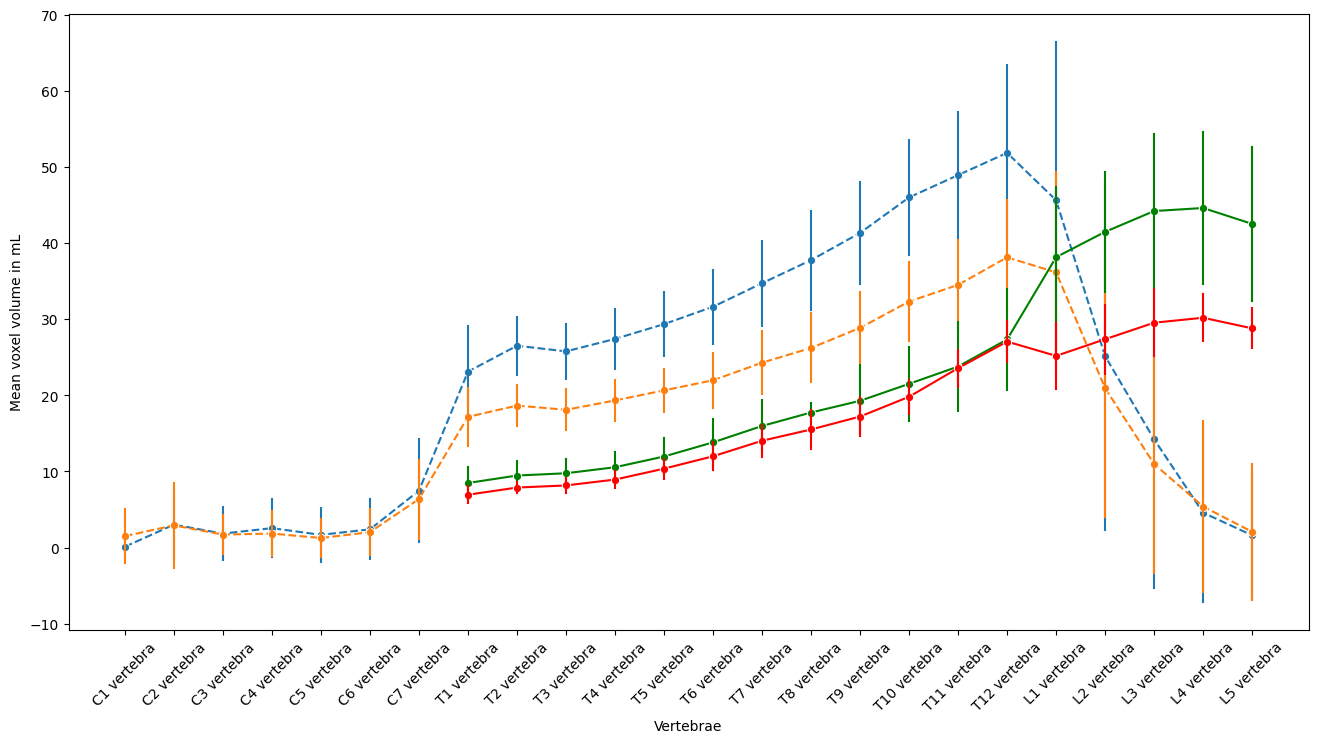

In [91]:
# Filtered M vs F vs literature

df_plot_mean_and_std_original, df_plot_mean_and_std_paper = plot_mean_and_std_vertebra(df_plot_filters_0, region1_list)

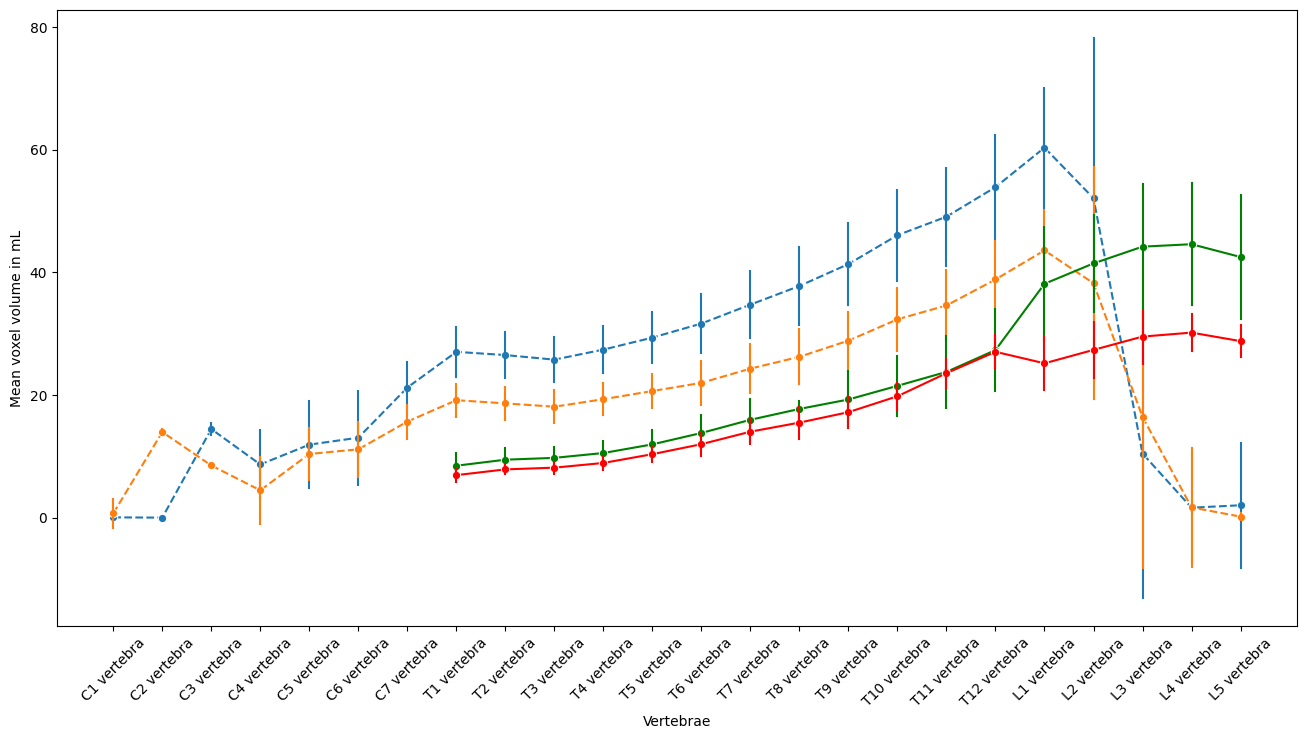

In [92]:
df_plot_mean_and_std_filters_1, df_plot_mean_and_std_paper = plot_mean_and_std_vertebra(df_plot_filters_1, region1_list)

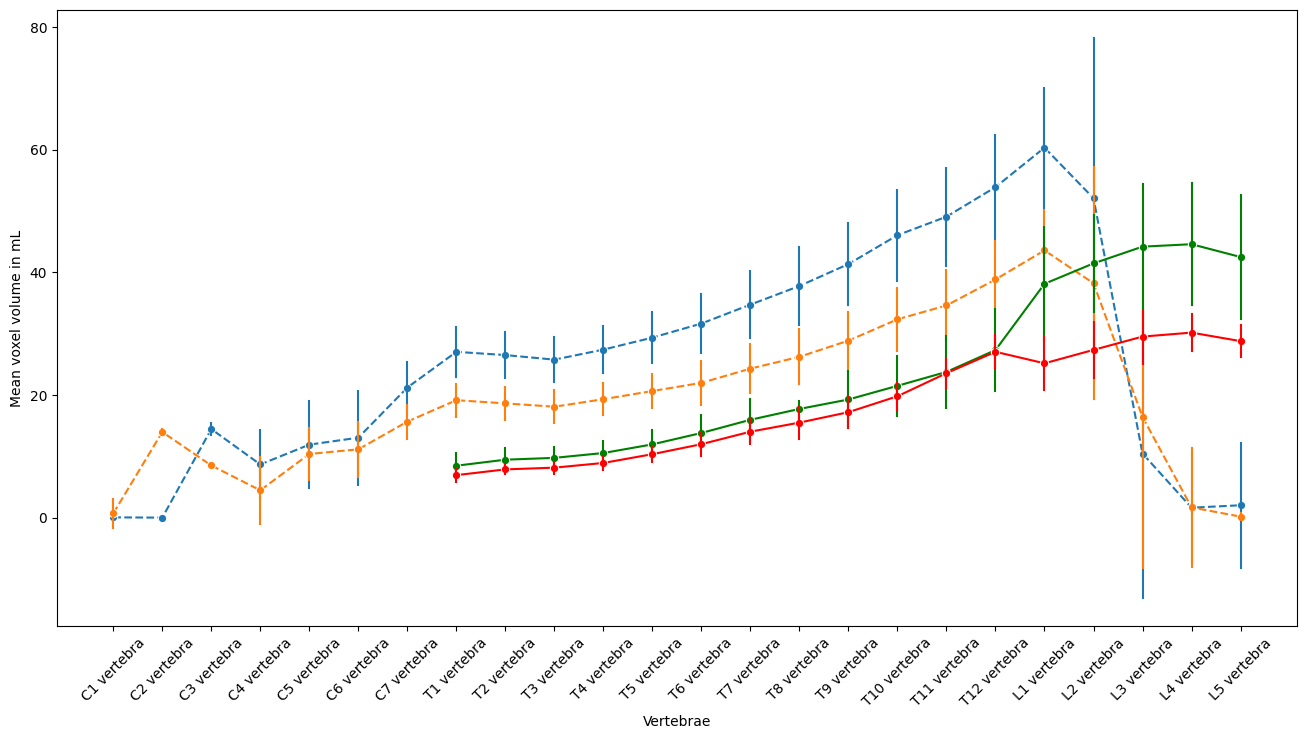

In [93]:
df_plot_mean_and_std_filters_2, df_plot_mean_and_std_paper = plot_mean_and_std_vertebra(df_plot_filters_2, region1_list)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


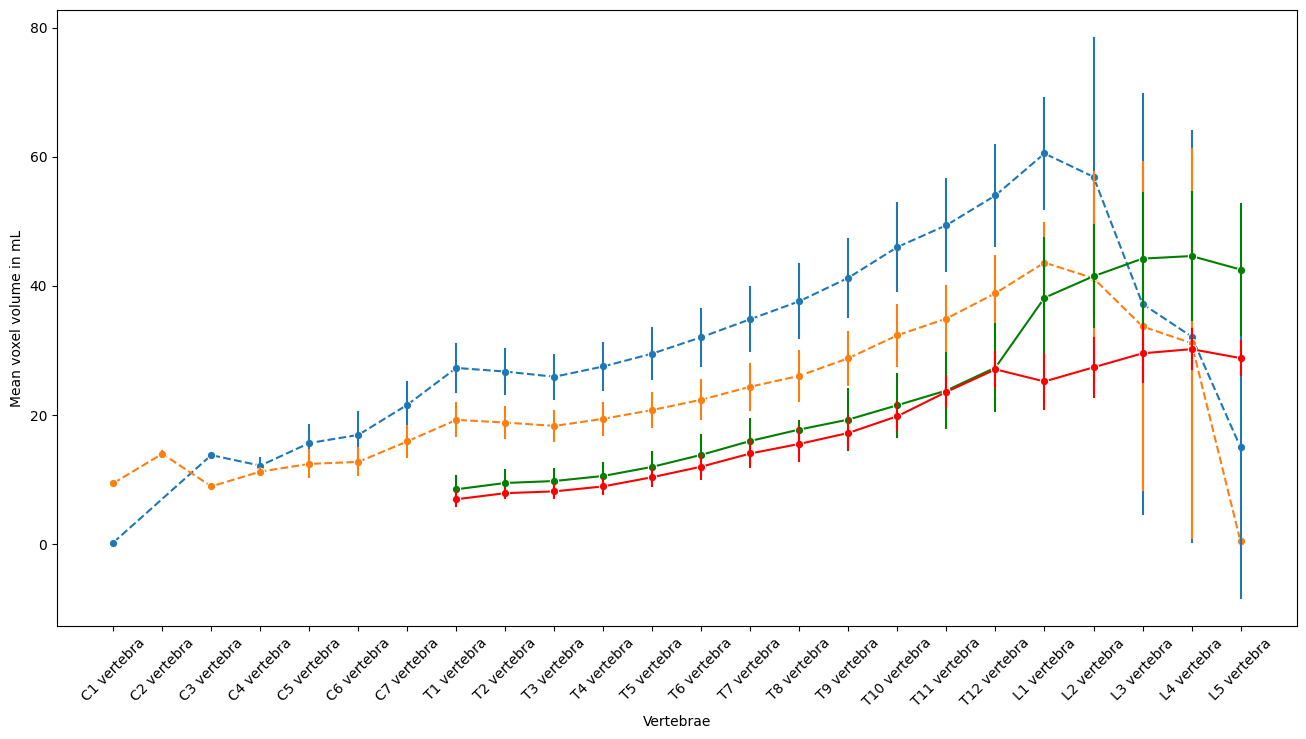

In [94]:
# Filtered M vs F vs literature

df_plot_mean_and_std_heuristics, df_plot_mean_and_std_paper = plot_mean_and_std_vertebra(df_plot_filters_4, region1_list)

In [ ]:
# # Now let's remove the ones with num_series < 10,000

# regions_10000 = num_series_df[num_series_df['num_series_with_segmentation_completeness_and_vertebrae_every_slice']>10000]['region'].values
# print('regions_10000: ' + str(regions_10000))
# df_plot_filters_3_10000 = df_plot_filters_3[df_plot_filters_3['findingSite_CodeMeaning'].isin(regions_10000)]

regions_10000: ['T1 vertebra' 'T2 vertebra' 'T3 vertebra' 'T4 vertebra' 'T5 vertebra'
 'T6 vertebra' 'T7 vertebra' 'T8 vertebra' 'T9 vertebra' 'T10 vertebra'
 'T11 vertebra' 'T12 vertebra' 'L1 vertebra']


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


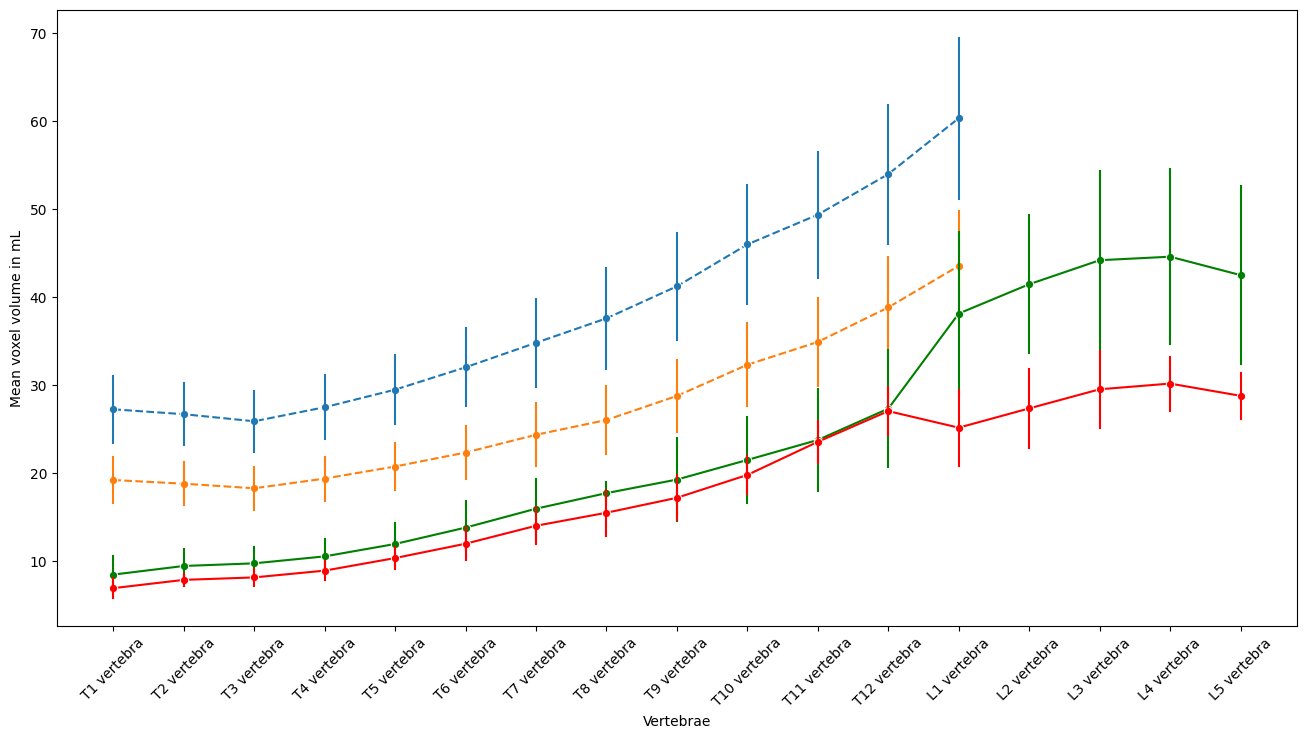

In [ ]:
# # Let's compare the M vs F and plot the mean for each vertebra with the 10000 series removed

# df_plot_mean_and_std_heuristics_10000, df_plot_mean_and_std_paper = plot_mean_and_std_vertebra(df_plot_filters_3_10000, region1_list)

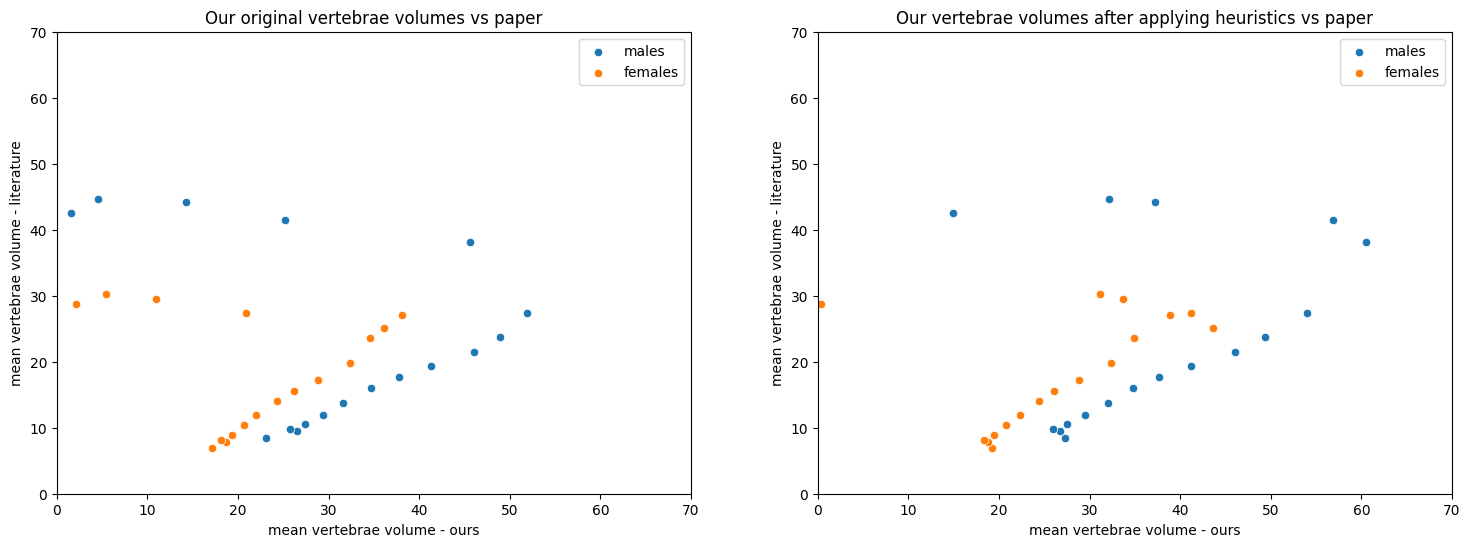

In [96]:
# Then let's plot the mean values of original vs literature and heuristics vs literature scatter plots

# df_plot_mean_and_std_original['type'] = ['ours'] * len(df_plot_mean_and_std_original)
# df_plot_mean_and_std_paper['type'] = ['paper'] * len(df_plot_mean_and_std_paper)
# df_plot_mean_and_std_original_and_paper = pd.DataFrame()
# df_plot_mean_and_std_original_and_paper = pd.concat([df_plot_mean_and_std_original, df_plot_mean_and_std_paper])

df_plot_mean_and_std_original_and_paper_plot = pd.DataFrame()
df_plot_mean_and_std_original_and_paper_plot = pd.merge(df_plot_mean_and_std_original, df_plot_mean_and_std_paper, on='findingSite_CodeMeaning', how='inner')

df_plot_mean_and_std_heuristics_and_paper_plot = pd.DataFrame()
df_plot_mean_and_std_heuristics_and_paper_plot = pd.merge(df_plot_mean_and_std_heuristics, df_plot_mean_and_std_paper, on='findingSite_CodeMeaning', how='inner')

# df_plot_mean_and_std_heuristics_10000_and_paper_plot = pd.DataFrame()
# df_plot_mean_and_std_heuristics_10000_and_paper_plot = pd.merge(df_plot_mean_and_std_heuristics_10000, df_plot_mean_and_std_paper, on='findingSite_CodeMeaning', how='inner')

plt.figure(figsize=(18,6))

# Original volume vs literature, M and F
plt.subplot(1,2,1)
a = sns.scatterplot(df_plot_mean_and_std_original_and_paper_plot, x='mean_males_x', y='mean_males_y')
b = sns.scatterplot(df_plot_mean_and_std_original_and_paper_plot, x='mean_females_x', y='mean_females_y')
plt.xlabel('mean vertebrae volume - ours')
plt.ylabel('mean vertebrae volume - literature')
plt.legend(['males', 'females'])
a.set_xlim([0, 70])
a.set_ylim([0, 70])
a.title.set_text('Our original vertebrae volumes vs paper')
# plt.suptitle('Our original vertebrae volumes vs paper')

# With heuristics vs literature, M and F
plt.subplot(1,2,2)
a = sns.scatterplot(df_plot_mean_and_std_heuristics_and_paper_plot, x='mean_males_x', y='mean_males_y')
b = sns.scatterplot(df_plot_mean_and_std_heuristics_and_paper_plot, x='mean_females_x', y='mean_females_y')
plt.xlabel('mean vertebrae volume - ours')
plt.ylabel('mean vertebrae volume - literature')
plt.legend(['males', 'females'])
a.set_xlim([0, 70])
a.set_ylim([0, 70])
a.title.set_text('Our vertebrae volumes after applying heuristics vs paper')
# plt.suptitle('Our vertebrae volumes after applying heuristics vs paper')

# # With heuristics and removing <10,000 series vs literature, M and F
# plt.subplot(1,3,3)
# a = sns.scatterplot(df_plot_mean_and_std_heuristics_10000_and_paper_plot, x='mean_males_x', y='mean_males_y')
# b = sns.scatterplot(df_plot_mean_and_std_heuristics_10000_and_paper_plot, x='mean_females_x', y='mean_females_y')
# plt.xlabel('mean vertebrae volume - ours')
# plt.ylabel('mean vertebrae volume - literature')
# plt.legend(['males', 'females'])
# a.set_xlim([0, 70])
# a.set_ylim([0, 70])
# a.title.set_text('Our vertebrae volumes after applying heuristics and removing less than 10000 series vs paper')
# # plt.suptitle('Our vertebrae volumes after applying heuristics and removing less than 10000 series vs paper')

plt.show()


In [ ]:
# Kruskal Wallis test
# Multiiple groups
# Non parametric

# tests if medians are the same

from scipy import stats

# Males

original_values = df_plot_mean_and_std_original['mean_males'].values
filter_1_values = df_plot_mean_and_std_filters_1['mean_males'].values
filter_2_values = df_plot_mean_and_std_filters_2['mean_males'].values
filter_3_values = df_plot_mean_and_std_heuristics['mean_males'].values
print(stats.kruskal(original_values, filter_1_values, filter_2_values, filter_3_values))

print(stats.kruskal(original_values, filter_3_values))

original_values = df_plot_mean_and_std_original['mean_females'].values
filter_1_values = df_plot_mean_and_std_filters_1['mean_females'].values
filter_2_values = df_plot_mean_and_std_filters_2['mean_females'].values
filter_3_values = df_plot_mean_and_std_heuristics['mean_females'].values
print(stats.kruskal(original_values, filter_1_values, filter_2_values, filter_3_values))

print(stats.kruskal(original_values, filter_3_values))

KruskalResult(statistic=0.8359294973984708, pvalue=0.8408552609920152)
KruskalResult(statistic=0.4914965986394293, pvalue=0.4832604645906545)
KruskalResult(statistic=0.7450623418558415, pvalue=0.8625570626276926)
KruskalResult(statistic=0.4914965986394293, pvalue=0.4832604645906545)


# OLD - Ribs left vs right

## Experimenting with first rib and stats test

In [ ]:
# First rib - original volumes

region = "First rib"
feature = "Volume from Voxel Summation"

df_plot_ribs_temp = get_organ_feature(region, feature, table_id, project_name)
df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
df_plot_ribs_join = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
df_plot_ribs_join = df_plot_ribs_join[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                       'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
df_plot_ribs_join = df_plot_ribs_join.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
df_plot_ribs_join['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_left'].values]
df_plot_ribs_join['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_right'].values]
df_plot_ribs_join['Value_left_minus_right'] = abs(df_plot_ribs_join['Value_left'].values - df_plot_ribs_join['Value_right'].values)


In [ ]:
set(df_plot_ribs_temp['findingSite_CodeMeaning'].values)

{'First rib'}

In [ ]:
# First rib - with heuristics

region = "First rib"
feature = "Volume from Voxel Summation"

df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness(region, feature, table_id, project_name)
df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
df_plot_ribs_join_2 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
df_plot_ribs_join_2 = df_plot_ribs_join_2[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                       'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
df_plot_ribs_join_2 = df_plot_ribs_join_2.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
df_plot_ribs_join_2['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_left'].values]
df_plot_ribs_join_2['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_right'].values]
df_plot_ribs_join_2['Value_left_minus_right'] = abs(df_plot_ribs_join_2['Value_left'].values - df_plot_ribs_join_2['Value_right'].values)


In [ ]:
set(df_plot_ribs_temp['findingSite_CodeMeaning'].values)

{'First rib'}

<Axes: ylabel='Value_left_minus_right'>

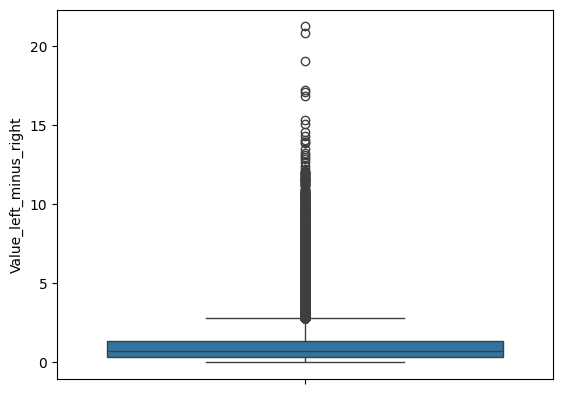

In [ ]:
sns.boxplot(df_plot_ribs_join, y='Value_left_minus_right')

<Axes: ylabel='Value_left_minus_right'>

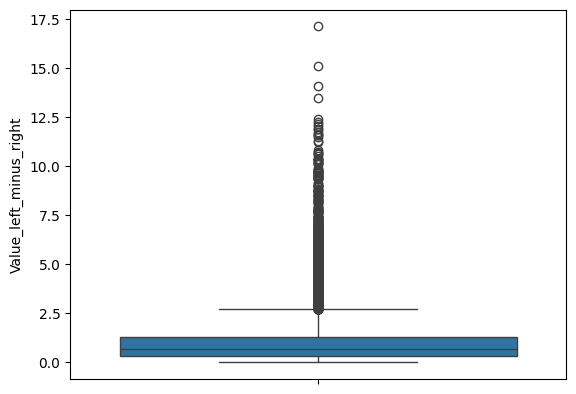

In [ ]:
sns.boxplot(df_plot_ribs_join_2, y='Value_left_minus_right')

In [ ]:
df_plot_ribs_stats = pd.DataFrame()
df_plot_ribs_join['filter_status'] = ['original'] * len(df_plot_ribs_join)
df_plot_ribs_join_2['filter_status'] = ['with_filters'] * len(df_plot_ribs_join_2)
df_plot_ribs_stats = pd.concat([df_plot_ribs_join, df_plot_ribs_join_2])

df_plot_ribs_stats.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value_left,Value_right,Value_left_minus_right,filter_status
0,132286,1.2.840.113654.2.55.69571713245519885935137963...,1.2.840.113654.2.55.10000830183123495604835259...,72,M,First rib,9166.992188,7344.727051,1822.265137,original
1,107764,1.2.840.113654.2.55.17158622996185378565487542...,1.2.840.113654.2.55.10000850533416322553665072...,56,M,First rib,14326.782227,14005.081055,321.701172,original
2,128370,1.2.840.113654.2.55.26576277676425799146847962...,1.2.840.113654.2.55.10000944692524986099312741...,69,F,First rib,6981.752930,8832.860352,1851.107422,original
3,129659,1.2.840.113654.2.55.14224315431907123431252487...,1.2.840.113654.2.55.10001102480903211454943302...,59,M,First rib,12356.179688,12444.093750,87.914062,original
4,123560,1.2.840.113654.2.55.19994432989699494147310497...,1.2.840.113654.2.55.10001275412896145078730823...,56,F,First rib,5362.366211,5485.732910,123.366699,original


In [ ]:
# df_temp = df_plot_ribs_stats.iloc[0:20]

# Let's pick 20 patients
patient_id_list = list(set(df_plot_ribs_stats['PatientID'].values))
print(len(patient_id_list))
patient_id_list = patient_id_list[0:20000]
df_temp = df_plot_ribs_stats[df_plot_ribs_stats['PatientID'].isin(patient_id_list)]

print(len(df_temp))

26192
131352


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming volumes_data is a DataFrame containing columns: patient_id, side (left/right), volume, and filter_status

# Fit linear mixed-effects model
mixed_model = smf.mixedlm("Value_left_minus_right ~ filter_status", df_temp, groups=df_temp["PatientID"])
mixed_results = mixed_model.fit()

# Print summary of results
print(mixed_results.summary())

                     Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Value_left_minus_right
No. Observations:      131352     Method:                REML                  
No. Groups:            20000      Scale:                 201671.9186           
Min. group size:       1          Log-Likelihood:        -1020537.7567         
Max. group size:       36         Converged:             Yes                   
Mean group size:       6.6                                                     
-------------------------------------------------------------------------------
                                Coef.    Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        976.411    6.708 145.558 0.000 963.264 989.559
filter_status[T.with_filters]    -13.336    3.048  -4.375 0.000 -19.310  -7.361
Group Var                     848770.358   21.552            

In [ ]:
# No observations is 115, correct
# No.Groups is 20, correct because we chose 20 patients
# Min group size and max group size seem correct - number of volumes per subject
# predicting the difference in left minus right - dependent variable
# filter status - P>[z] is large, at 0.328, which means there is not a significant difference between the original volumes and the filtered ones.

# try using more patients and see how this changes. as we increase to 1000 patients - the difference becomes significant.

## All rib pairs - left vs right differences

In [ ]:
region_list = ["First rib" , "Second rib", "Third rib", "Fourth rib",  "Fifth rib", "Sixth rib",
               "Seventh rib",  "Eighth rib", "Ninth rib", "Tenth rib", "Eleventh rib",  "Twelfth rib"]
feature = "Volume from Voxel Summation"

df_plot_ribs_stats_all = pd.DataFrame()

for n in range(0,len(region_list)):

  region = region_list[n]
  print('*** region: ' + str(region) + ' ***')

  # Original
  df_plot_ribs_temp = get_organ_feature(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join = df_plot_ribs_join[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join = df_plot_ribs_join.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_left'].values]
  df_plot_ribs_join['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_right'].values]
  df_plot_ribs_join['Value_left_minus_right'] = abs(df_plot_ribs_join['Value_left'].values - df_plot_ribs_join['Value_right'].values)

  # With segmentation completeness
  df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join_2 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join_2 = df_plot_ribs_join_2[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join_2 = df_plot_ribs_join_2.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join_2['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_left'].values]
  df_plot_ribs_join_2['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_right'].values]
  df_plot_ribs_join_2['Value_left_minus_right'] = abs(df_plot_ribs_join_2['Value_left'].values - df_plot_ribs_join_2['Value_right'].values)

  # With the segmentation completeness and checking that the number of components == 1
  df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness_and_one_connected_component(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join_3 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join_3 = df_plot_ribs_join_3[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join_3 = df_plot_ribs_join_3.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join_3['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_3['Value_left'].values]
  df_plot_ribs_join_3['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_3['Value_right'].values]
  df_plot_ribs_join_3['Value_left_minus_right'] = abs(df_plot_ribs_join_3['Value_left'].values - df_plot_ribs_join_3['Value_right'].values)

  # With the segmentation completeness, checking if number of components == 1, and number of voxels >= 10
  df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness_and_one_connected_component_and_number_of_voxels(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join_4 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join_4 = df_plot_ribs_join_4[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join_4 = df_plot_ribs_join_4.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join_4['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_4['Value_left'].values]
  df_plot_ribs_join_4['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_4['Value_right'].values]
  df_plot_ribs_join_4['Value_left_minus_right'] = abs(df_plot_ribs_join_4['Value_left'].values - df_plot_ribs_join_4['Value_right'].values)

  # Join all
  df_plot_ribs_stats = pd.DataFrame()
  df_plot_ribs_join['filter_status'] = ['original'] * len(df_plot_ribs_join)
  df_plot_ribs_join_2['filter_status'] = ['with_one_filter'] * len(df_plot_ribs_join_2)
  df_plot_ribs_join_3['filter_status'] = ['with_two_filter'] * len(df_plot_ribs_join_3)
  df_plot_ribs_join_4['filter_status'] = ['with_three_filter'] * len(df_plot_ribs_join_4)
  df_plot_ribs_stats = pd.concat([df_plot_ribs_join, df_plot_ribs_join_2, df_plot_ribs_join_3, df_plot_ribs_join_4])

  df_plot_ribs_stats_all = pd.concat([df_plot_ribs_stats_all, df_plot_ribs_stats])



*** region: First rib ***
*** region: Second rib ***
*** region: Third rib ***
*** region: Fourth rib ***
*** region: Fifth rib ***
*** region: Sixth rib ***
*** region: Seventh rib ***


Try multiple ways to assess the difference between the left and right ribs

In [ ]:
# Calculate the relative difference - ((left-right)/left) * 100
df_plot_ribs_stats_all['Value_relative_difference'] = np.abs(df_plot_ribs_stats_all['Value_left'].values - df_plot_ribs_stats_all['Value_right'].values) / df_plot_ribs_stats_all['Value_left'].values

In [ ]:
# Or instead divide by the sum of the volumes
df_plot_ribs_stats_all['Value_relative_difference2'] = (np.abs(df_plot_ribs_stats_all['Value_left'].values - df_plot_ribs_stats_all['Value_right'].values)) / (df_plot_ribs_stats_all['Value_left'].values + df_plot_ribs_stats_all['Value_right'].values)

In [ ]:
# Calculate the coefficient of variation - mean of left and right, divided by the standard deviation
temp = np.concatenate((np.expand_dims(df_plot_ribs_stats_all['Value_left'].values,1), np.expand_dims(df_plot_ribs_stats_all['Value_right'].values,1)), axis=1)
temp_mean = np.mean(temp, axis=1)
temp_std = np.std(temp, axis=1)
df_plot_ribs_stats_all['Coefficient_of_variation'] = (temp_std / temp_mean)

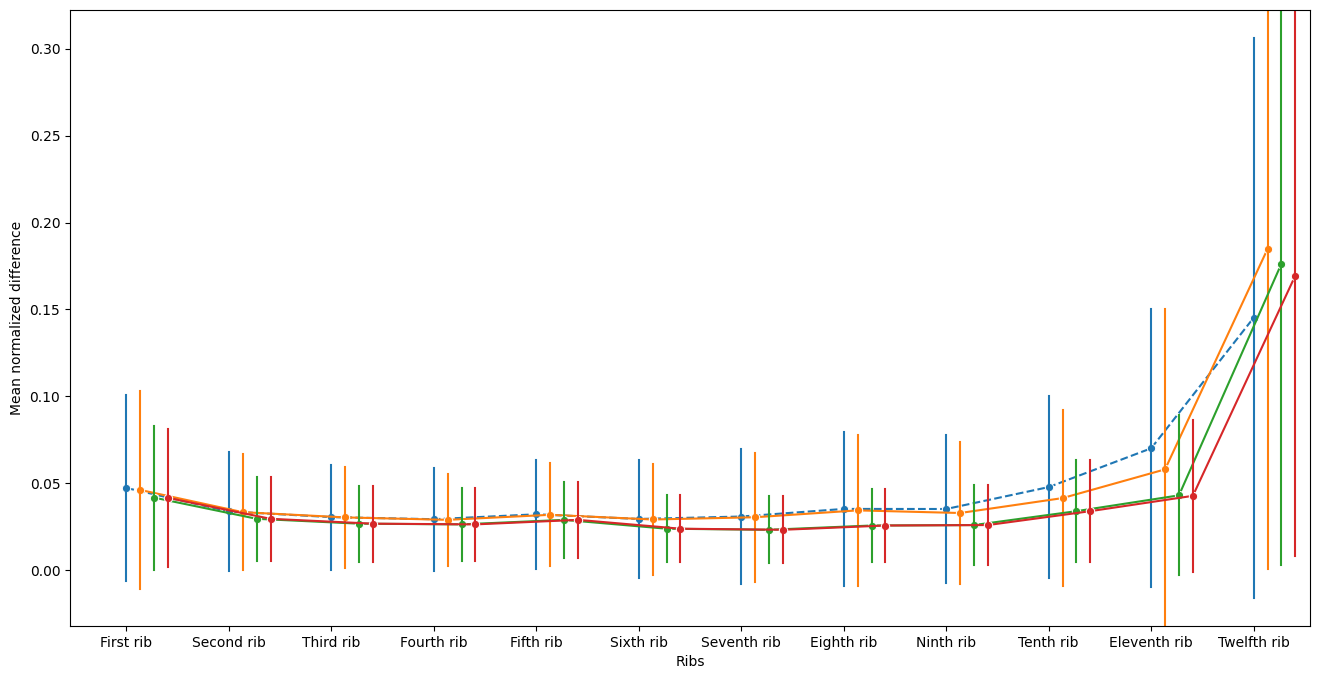

In [ ]:
### Plot for the Value_relative_difference2 mean and std over the three heuristics comparison ###

# https://stackoverflow.com/questions/43126064/how-do-i-shift-categorical-scatter-markers-to-left-and-right-above-xticks-multi

import matplotlib.transforms as transforms

### Calculate the mean and stddev ###

mean_cv = df_plot_ribs_stats_all.groupby(['filter_status', 'findingSite_CodeMeaning'])['Value_relative_difference2'].mean()
mean_cv_df = mean_cv.reset_index()
mean_cv_df.columns = ['filter_status', 'findingSite_CodeMeaning', 'Value_relative_difference2_mean']

stddev_cv = df_plot_ribs_stats_all.groupby(['filter_status', 'findingSite_CodeMeaning'])['Value_relative_difference2'].std()
stddev_cv_df = stddev_cv.reset_index()
stddev_cv_df.columns = ['filter_status', 'findingSite_CodeMeaning', 'Value_relative_difference2_stddev']

df_cv = pd.DataFrame()
df_cv = mean_cv_df.merge(stddev_cv_df, on=['filter_status', 'findingSite_CodeMeaning'], how='inner')

# Define order of ribs we want
rib_list = ['First rib', 'Second rib', 'Third rib', 'Fourth rib', 'Fifth rib', 'Sixth rib',
            'Seventh rib', 'Eighth rib', 'Ninth rib', 'Tenth rib', 'Eleventh rib', 'Twelfth rib']

# Create a dictionary to map the ribs_order to their corresponding indices
rib_index_map = {rib: idx for idx, rib in enumerate(rib_list)}

df_cv_original = df_cv[df_cv['filter_status']=='original']
df_cv_filter_1 = df_cv[df_cv['filter_status']=="with_one_filter"]
df_cv_filter_2 = df_cv[df_cv['filter_status']=="with_two_filter"]
df_cv_filter_3 = df_cv[df_cv['filter_status']=="with_three_filter"]

# Add a new column with the corresponding index for each rib
df_cv_original['rib_index'] = df_cv_original['findingSite_CodeMeaning'].map(rib_index_map)
df_cv_filter_1['rib_index'] = df_cv_filter_1['findingSite_CodeMeaning'].map(rib_index_map)
df_cv_filter_2['rib_index'] = df_cv_filter_2['findingSite_CodeMeaning'].map(rib_index_map)
df_cv_filter_3['rib_index'] = df_cv_filter_3['findingSite_CodeMeaning'].map(rib_index_map)

# Sort the DataFrame based on the ribs_index column
df_cv_original_sorted = df_cv_original.sort_values(by=['rib_index'])
df_cv_filter_1_sorted = df_cv_filter_1.sort_values(by=['rib_index'])
df_cv_filter_2_sorted = df_cv_filter_2.sort_values(by=['rib_index'])
df_cv_filter_3_sorted = df_cv_filter_3.sort_values(by=['rib_index'])

# Drop the temporary ribs_index column
df_cv_original_sorted.drop(columns=['rib_index'], inplace=True)
df_cv_filter_1_sorted.drop(columns=['rib_index'], inplace=True)
df_cv_filter_2_sorted.drop(columns=['rib_index'], inplace=True)
df_cv_filter_3_sorted.drop(columns=['rib_index'], inplace=True)

df_cv_original = df_cv_original_sorted.copy(deep=True)
df_cv_filter_1 = df_cv_filter_1_sorted.copy(deep=True)
df_cv_filter_2 = df_cv_filter_2_sorted.copy(deep=True)
df_cv_filter_3 = df_cv_filter_3_sorted.copy(deep=True)

### Plot ###

fig = plt.figure(figsize=(16,8))

offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# original
ax = sns.lineplot(data=df_cv_original, x = 'findingSite_CodeMeaning', y = 'Value_relative_difference2_mean' , marker='o')
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')
ax.set_ylabel('Mean normalized difference')
for n in range(0,len(df_cv_original)):
  plt.plot([n, n],
          [df_cv_original['Value_relative_difference2_mean'].values[n] - df_cv_original['Value_relative_difference2_stddev'].values[n], df_cv_original['Value_relative_difference2_mean'].values[n] + df_cv_original['Value_relative_difference2_stddev'].values[n]],
          c='C0')

# with 1 filter
ax = sns.lineplot(data=df_cv_filter_1, x = 'findingSite_CodeMeaning', y = 'Value_relative_difference2_mean' , marker='o', transform=trans+offset(10))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')

ax.set_ylabel('Mean normalized difference')
for n in range(0,len(df_cv_filter_1)):
  plt.plot([n, n],
          [df_cv_filter_1['Value_relative_difference2_mean'].values[n] - df_cv_filter_1['Value_relative_difference2_stddev'].values[n], df_cv_filter_1['Value_relative_difference2_mean'].values[n] + df_cv_filter_1['Value_relative_difference2_stddev'].values[n]],
          c='C1',
          transform=trans+offset(10))

# with 2 filter
ax = sns.lineplot(data=df_cv_filter_2, x = 'findingSite_CodeMeaning', y = 'Value_relative_difference2_mean' , marker='o', transform=trans+offset(20))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')

ax.set_ylabel('Mean normalized difference')
for n in range(0,len(df_cv_filter_2)):
  plt.plot([n, n],
          [df_cv_filter_2['Value_relative_difference2_mean'].values[n] - df_cv_filter_2['Value_relative_difference2_stddev'].values[n], df_cv_filter_2['Value_relative_difference2_mean'].values[n] + df_cv_filter_2['Value_relative_difference2_stddev'].values[n]],
          c='C2',
          transform=trans+offset(20))

# with 3 filter
ax = sns.lineplot(data=df_cv_filter_3, x = 'findingSite_CodeMeaning', y = 'Value_relative_difference2_mean' , marker='o', transform=trans+offset(30))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')

ax.set_ylabel('Mean normalized difference')
for n in range(0,len(df_cv_filter_3)):
  plt.plot([n, n],
          [df_cv_filter_3['Value_relative_difference2_mean'].values[n] - df_cv_filter_3['Value_relative_difference2_stddev'].values[n], df_cv_filter_3['Value_relative_difference2_mean'].values[n] + df_cv_filter_3['Value_relative_difference2_stddev'].values[n]],
          c='C3',
          transform=trans+offset(30))

In [ ]:
# Investigate why such poor results for the twelfth rib - original results

df_original = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status']=='original']
df_original_rib_12 = df_original[df_original['findingSite_CodeMeaning']=="Twelfth rib"]
df_original_rib_12 = df_original_rib_12.sort_values(by='Value_relative_difference2', ascending=False)

df_original_rib_12.head(5)

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value_left,Value_right,Value_left_minus_right,filter_status,Value_relative_difference,Value_relative_difference2,Coefficient_of_variation
90945,216972,1.3.6.1.4.1.14519.5.2.1.7009.9004.135981462593...,1.3.6.1.4.1.14519.5.2.1.7009.9004.205217235187...,63,M,Twelfth rib,7.177390,0.002052,7.175338,original,0.999714,0.999428,0.999428
59937,105248,1.2.840.113654.2.55.12908775556614379594178027...,1.2.840.113654.2.55.33539711870502012551878622...,55,M,Twelfth rib,0.003906,6.655273,6.651367,original,1702.858966,0.998827,0.998827
87196,215047,1.3.6.1.4.1.14519.5.2.1.7009.9004.226011287714...,1.3.6.1.4.1.14519.5.2.1.7009.9004.173938273212...,67,F,Twelfth rib,0.003230,4.490239,4.487009,original,1389.166794,0.998562,0.998562
598,106014,1.2.840.113654.2.55.10781111428634090169731439...,1.2.840.113654.2.55.10247436413604158632764089...,68,M,Twelfth rib,5.513871,0.004314,5.509557,original,0.999218,0.998436,0.998436
103705,214058,1.3.6.1.4.1.14519.5.2.1.7009.9004.290554253407...,1.3.6.1.4.1.14519.5.2.1.7009.9004.308929717569...,62,F,Twelfth rib,5.024927,0.003955,5.020972,original,0.999213,0.998427,0.998427


In [ ]:
# Investigate for the twelfth rib - after 3 filters - ones that were not removed, but should have been

df_filter_3 = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status']=='with_three_filter']
df_filter_3_rib_12 = df_filter_3[df_filter_3['findingSite_CodeMeaning']=="Twelfth rib"]
df_filter_3_rib_12 = df_filter_3_rib_12.sort_values(by='Value_relative_difference2', ascending=False)

df_filter_3_rib_12.head(5)

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value_left,Value_right,Value_left_minus_right,filter_status,Value_relative_difference,Value_relative_difference2,Coefficient_of_variation
9284,116957,1.2.840.113654.2.55.18871538468845583333268657...,1.2.840.113654.2.55.31523216007293066113915752...,62,F,Twelfth rib,6.234030,0.076204,6.157826,with_three_filter,0.987776,0.975847,0.975847
15189,200951,1.3.6.1.4.1.14519.5.2.1.7009.9004.171448522863...,1.3.6.1.4.1.14519.5.2.1.7009.9004.167595855113...,62,F,Twelfth rib,5.081177,0.083771,4.997406,with_three_filter,0.983513,0.967562,0.967562
14859,207385,1.3.6.1.4.1.14519.5.2.1.7009.9004.396138154798...,1.3.6.1.4.1.14519.5.2.1.7009.9004.156477874697...,68,M,Twelfth rib,7.955338,0.154145,7.801193,with_three_filter,0.980624,0.961984,0.961984
19401,207102,1.3.6.1.4.1.14519.5.2.1.7009.9004.289469800667...,1.3.6.1.4.1.14519.5.2.1.7009.9004.307637945690...,59,M,Twelfth rib,8.447058,0.172046,8.275012,with_three_filter,0.979632,0.960078,0.960078
14390,209467,1.3.6.1.4.1.14519.5.2.1.7009.9004.149806882428...,1.3.6.1.4.1.14519.5.2.1.7009.9004.140445442625...,64,M,Twelfth rib,5.203283,0.114557,5.088726,with_three_filter,0.977984,0.956916,0.956916


In [ ]:
# Investivate for the 12th rib - after 3 filters - ones that were removed, and should have been

df_original = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status']=='original']
df_original_rib_12 = df_original[df_original['findingSite_CodeMeaning']=="Twelfth rib"]
df_original_rib_12 = df_original_rib_12.sort_values(by='Value_relative_difference2', ascending=False)

series_original_rib_12 = df_original_rib_12['sourceSegmentedSeriesUID'].values

df_filter_3 = df_plot_ribs_stats_all[df_plot_ribs_stats_all['filter_status']=='with_three_filter']
df_filter_3_rib_12 = df_filter_3[df_filter_3['findingSite_CodeMeaning']=="Twelfth rib"]
df_filter_3_rib_12 = df_filter_3_rib_12.sort_values(by='Value_relative_difference2', ascending=False)

series_filter_3_rib_12 = df_filter_3_rib_12['sourceSegmentedSeriesUID'].values

# get ones in original, not in filter 3
series_filter_3_removed = list(set(series_original_rib_12)-set(series_filter_3_rib_12))
print('series_filter_3_removed: ' + str(len(series_filter_3_removed)))

# get the df
df_series_filter_3_removed = df_original_rib_12[df_original_rib_12['sourceSegmentedSeriesUID'].isin(series_filter_3_removed)]
df_series_filter_3_removed = df_series_filter_3_removed.sort_values(by='Value_relative_difference2', ascending=True)
df_series_filter_3_removed.head()


series_filter_3_removed: 93517


,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value_left,Value_right,Value_left_minus_right,filter_status,Value_relative_difference,Value_relative_difference2,Coefficient_of_variation
9410,108915,1.2.840.113654.2.55.74473136650646387874615655...,1.2.840.113654.2.55.13746977193752970720776333...,59,M,Twelfth rib,2.694397,2.694397,0.0,original,0.0,0.0,0.0
60772,116556,1.2.840.113654.2.55.33548394151134797462950580...,1.2.840.113654.2.55.33874653895768763576771172...,61,M,Twelfth rib,3.212091,3.212091,0.0,original,0.0,0.0,0.0
52029,133589,1.2.840.113654.2.55.11937667606104445300433567...,1.2.840.113654.2.55.30419583537207770359572789...,59,M,Twelfth rib,4.842851,4.842851,0.0,original,0.0,0.0,0.0
14048,129272,1.2.840.113654.2.55.86123200476371170267641179...,1.2.840.113654.2.55.15510193800585179795461862...,60,F,Twelfth rib,1.929707,1.929707,0.0,original,0.0,0.0,0.0
51474,119688,1.2.840.113654.2.55.30418520926639316605846573...,1.2.840.113654.2.55.30201011919089627410096888...,64,M,Twelfth rib,3.492340,3.492340,0.0,original,0.0,0.0,0.0


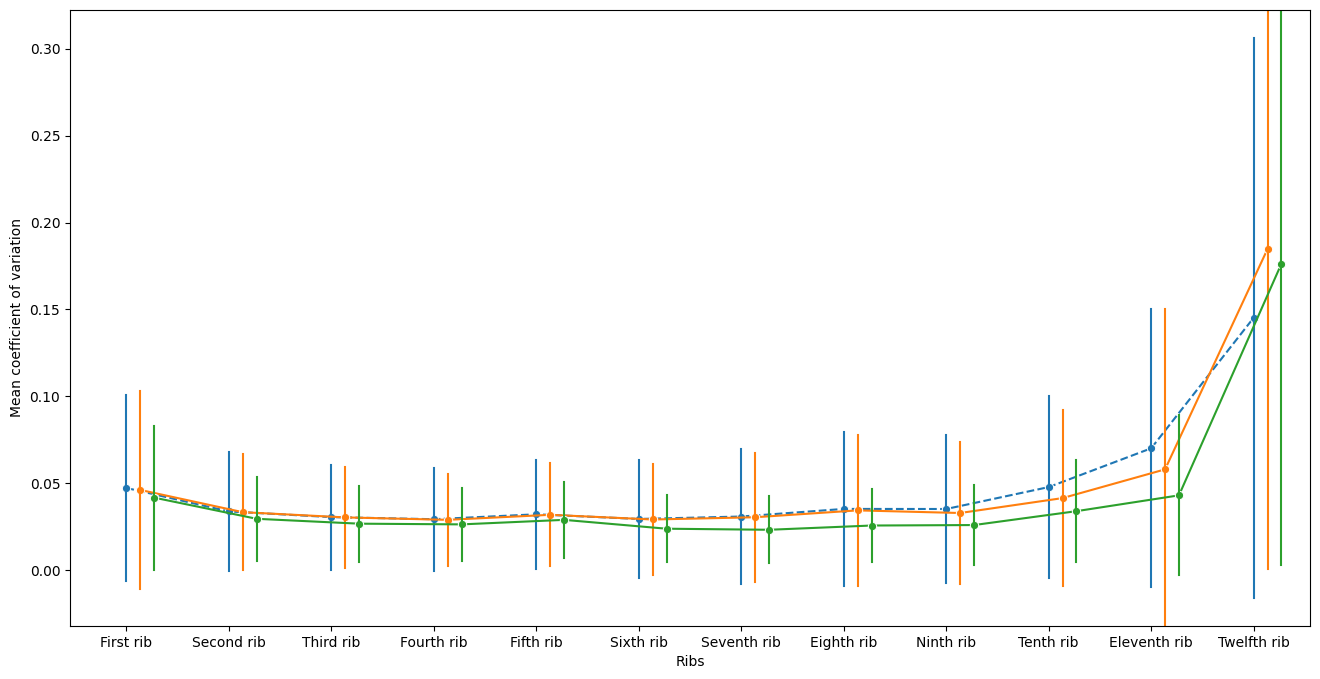

In [ ]:
### Plot for the coefficeint of variation mean and std over the three heuristics comparison ###

# https://stackoverflow.com/questions/43126064/how-do-i-shift-categorical-scatter-markers-to-left-and-right-above-xticks-multi

import matplotlib.transforms as transforms

### Calculate the mean and stddev ###

mean_cv = df_plot_ribs_stats_all.groupby(['filter_status', 'findingSite_CodeMeaning'])['Coefficient_of_variation'].mean()
mean_cv_df = mean_cv.reset_index()
mean_cv_df.columns = ['filter_status', 'findingSite_CodeMeaning', 'Coefficient_of_variation_mean']

stddev_cv = df_plot_ribs_stats_all.groupby(['filter_status', 'findingSite_CodeMeaning'])['Coefficient_of_variation'].std()
stddev_cv_df = stddev_cv.reset_index()
stddev_cv_df.columns = ['filter_status', 'findingSite_CodeMeaning', 'Coefficient_of_variation_stddev']

df_cv = pd.DataFrame()
df_cv = mean_cv_df.merge(stddev_cv_df, on=['filter_status', 'findingSite_CodeMeaning'], how='inner')

# Define order of ribs we want
rib_list = ['First rib', 'Second rib', 'Third rib', 'Fourth rib', 'Fifth rib', 'Sixth rib',
            'Seventh rib', 'Eighth rib', 'Ninth rib', 'Tenth rib', 'Eleventh rib', 'Twelfth rib']

# Create a dictionary to map the ribs_order to their corresponding indices
rib_index_map = {rib: idx for idx, rib in enumerate(rib_list)}

df_cv_original = df_cv[df_cv['filter_status']=='original']
df_cv_filter_1 = df_cv[df_cv['filter_status']=="with_one_filter"]
df_cv_filter_2 = df_cv[df_cv['filter_status']=="with_two_filter"]

# Add a new column with the corresponding index for each rib
df_cv_original['rib_index'] = df_cv_original['findingSite_CodeMeaning'].map(rib_index_map)
df_cv_filter_1['rib_index'] = df_cv_filter_1['findingSite_CodeMeaning'].map(rib_index_map)
df_cv_filter_2['rib_index'] = df_cv_filter_2['findingSite_CodeMeaning'].map(rib_index_map)

# Sort the DataFrame based on the ribs_index column
df_cv_original_sorted = df_cv_original.sort_values(by=['rib_index'])
df_cv_filter_1_sorted = df_cv_filter_1.sort_values(by=['rib_index'])
df_cv_filter_2_sorted = df_cv_filter_2.sort_values(by=['rib_index'])

# Drop the temporary ribs_index column
df_cv_original_sorted.drop(columns=['rib_index'], inplace=True)
df_cv_filter_1_sorted.drop(columns=['rib_index'], inplace=True)
df_cv_filter_2_sorted.drop(columns=['rib_index'], inplace=True)

df_cv_original = df_cv_original_sorted.copy(deep=True)
df_cv_filter_1 = df_cv_filter_1_sorted.copy(deep=True)
df_cv_filter_2 = df_cv_filter_2_sorted.copy(deep=True)

### Plot ###

fig = plt.figure(figsize=(16,8))

offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# original
ax = sns.lineplot(data=df_cv_original, x = 'findingSite_CodeMeaning', y = 'Coefficient_of_variation_mean' , marker='o')
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')
ax.set_ylabel('Mean coefficient of variation')
for n in range(0,len(df_cv_original)):
  plt.plot([n, n],
          [df_cv_original['Coefficient_of_variation_mean'].values[n] - df_cv_original['Coefficient_of_variation_stddev'].values[n], df_cv_original['Coefficient_of_variation_mean'].values[n] + df_cv_original['Coefficient_of_variation_stddev'].values[n]],
          c='C0')

# with 1 filter
ax = sns.lineplot(data=df_cv_filter_1, x = 'findingSite_CodeMeaning', y = 'Coefficient_of_variation_mean' , marker='o', transform=trans+offset(10))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')

ax.set_ylabel('Mean coefficient of variation')
for n in range(0,len(df_cv_filter_1)):
  plt.plot([n, n],
          [df_cv_filter_1['Coefficient_of_variation_mean'].values[n] - df_cv_filter_1['Coefficient_of_variation_stddev'].values[n], df_cv_filter_1['Coefficient_of_variation_mean'].values[n] + df_cv_filter_1['Coefficient_of_variation_stddev'].values[n]],
          c='C1',
          transform=trans+offset(10))

# with 2 filter
ax = sns.lineplot(data=df_cv_filter_2, x = 'findingSite_CodeMeaning', y = 'Coefficient_of_variation_mean' , marker='o', transform=trans+offset(20))
ax.lines[0].set_linestyle("--")
ax.set_xticks(np.linspace(0,len(rib_list)-1,len(rib_list)))
ax.set_xticklabels(rib_list)
ax.set_xlabel('Ribs')

ax.set_ylabel('Mean coefficient of variation')
for n in range(0,len(df_cv_filter_2)):
  plt.plot([n, n],
          [df_cv_filter_2['Coefficient_of_variation_mean'].values[n] - df_cv_filter_2['Coefficient_of_variation_stddev'].values[n], df_cv_filter_2['Coefficient_of_variation_mean'].values[n] + df_cv_filter_2['Coefficient_of_variation_stddev'].values[n]],
          c='C2',
          transform=trans+offset(20))



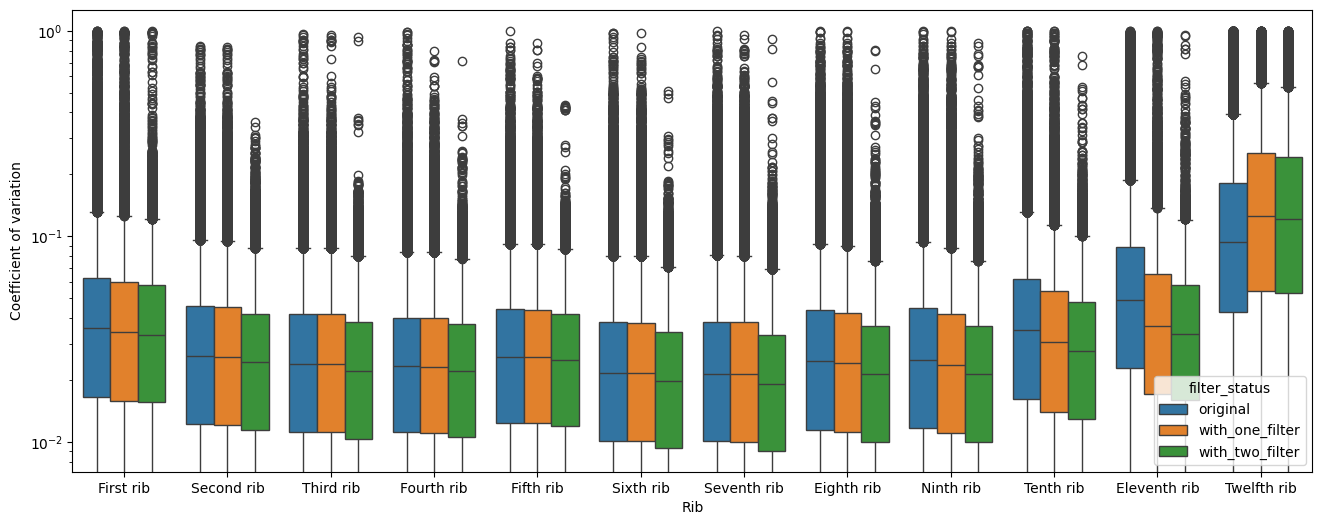

In [ ]:
# Boxplots for
# x axis - rib, and with and without heuristic as the hue
# y axis - 'Coefficient of variation'

plt.figure(figsize=(16,6))
ax = sns.boxplot(df_plot_ribs_stats_all, x='findingSite_CodeMeaning', y='Coefficient_of_variation', hue='filter_status')
ax.set(xlabel='Rib', ylabel='Coefficient of variation')
plt.yscale('log')

[Text(0.5, 0, 'Rib'), Text(0, 0.5, 'Coefficient of variation')]

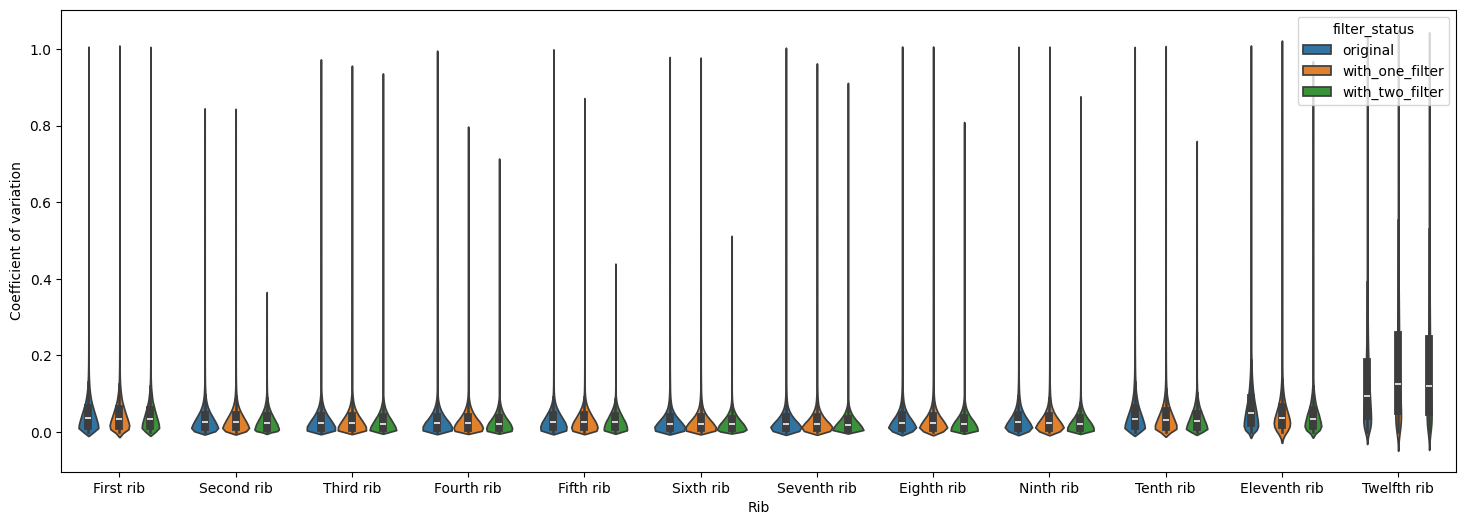

In [ ]:
# Violin plot
# Coefficient of variation

plt.figure(figsize=(18,6))
ax = sns.violinplot(data=df_plot_ribs_stats_all, x="findingSite_CodeMeaning", y="Coefficient_of_variation", hue="filter_status")
ax.set(xlabel='Rib', ylabel='Coefficient of variation')


[Text(0.5, 0, 'Rib'),
 Text(0, 0.5, 'Normalized difference of left vs right rib')]

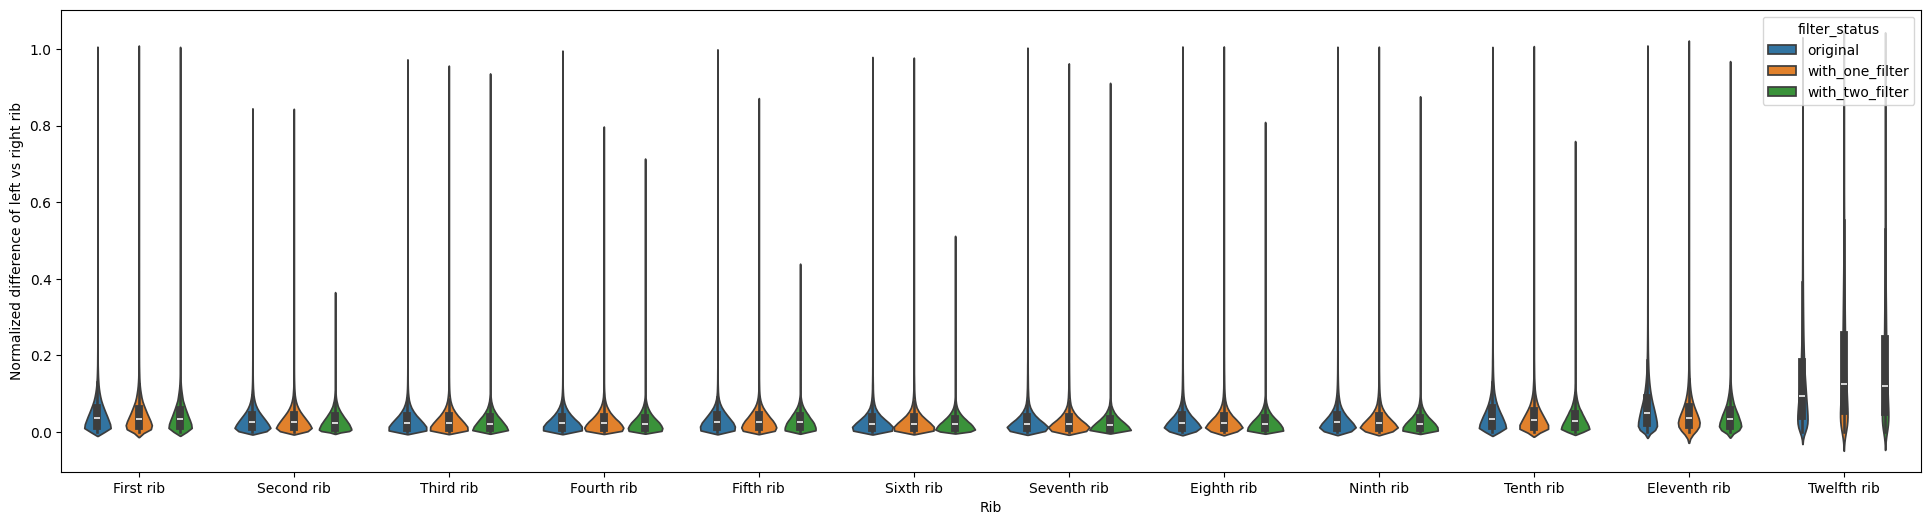

In [ ]:
# Violinplot
# Normalized differences
# (left-right)/(left+right)

plt.figure(figsize=(24,6))
ax = sns.violinplot(data=df_plot_ribs_stats_all, x="findingSite_CodeMeaning", y="Value_relative_difference2", hue="filter_status")
ax.set(xlabel='Rib', ylabel='Normalized difference of left vs right rib')

[Text(0.5, 0, 'Rib'), Text(0, 0.5, 'Relative difference of left vs right rib')]

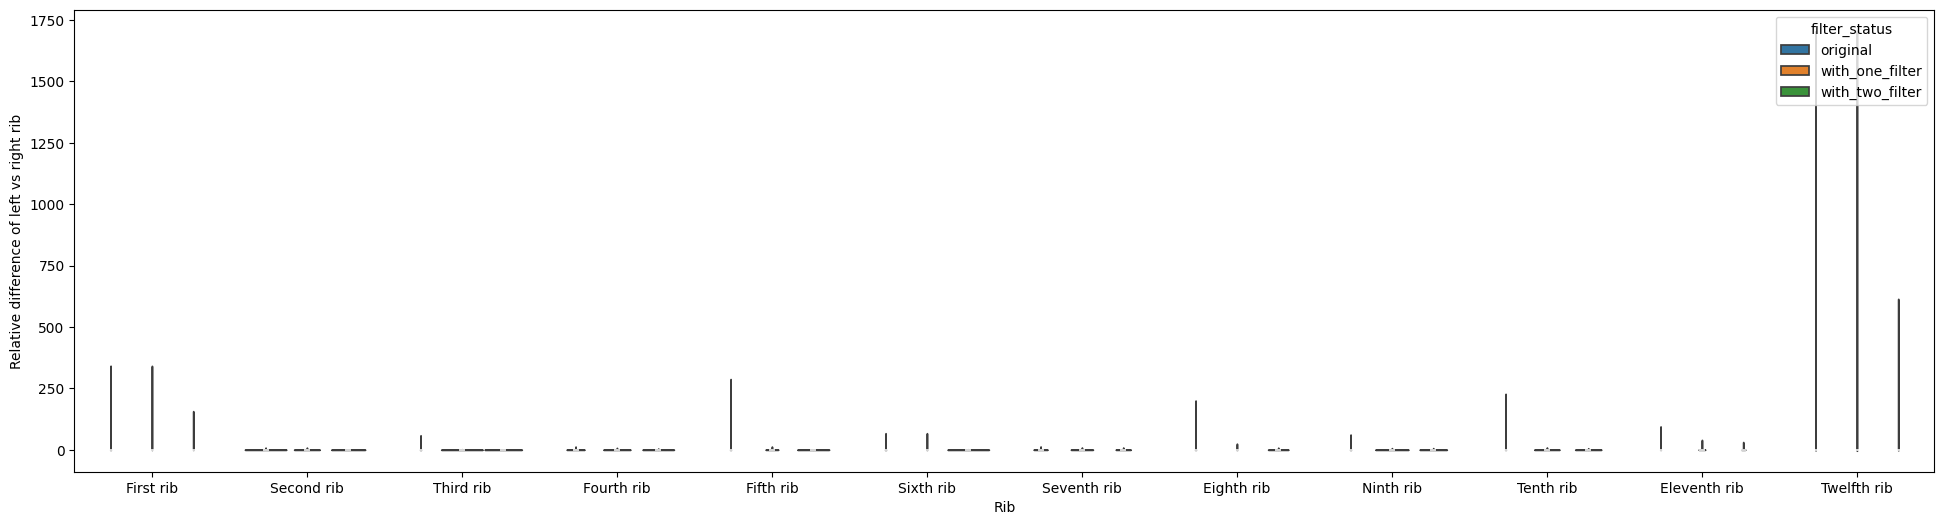

In [ ]:
# Violin plot
# Plot the relative difference
# (left-right)/left

plt.figure(figsize=(24,6))
ax = sns.violinplot(data=df_plot_ribs_stats_all, x="findingSite_CodeMeaning", y="Value_relative_difference", hue="filter_status")
ax.set(xlabel='Rib', ylabel='Relative difference of left vs right rib')


[Text(0.5, 0, 'Rib'), Text(0, 0.5, 'Relative difference of left vs right rib')]

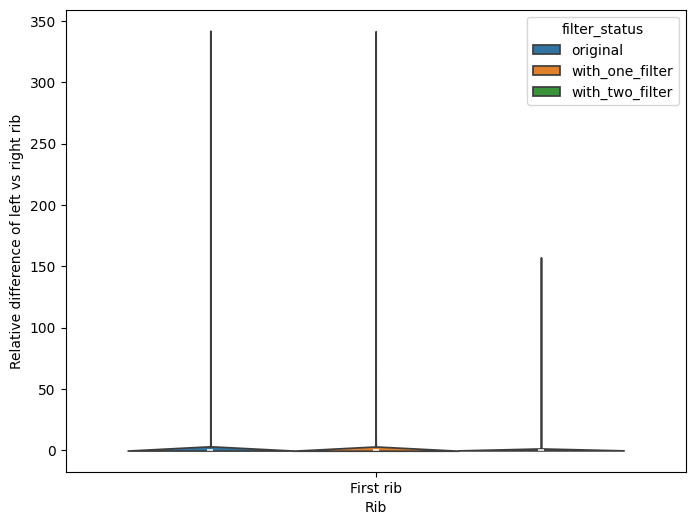

In [ ]:
# Try with just one set of ribs, to see if any better...

df_plot_ribs_stats_all_first = df_plot_ribs_stats_all[df_plot_ribs_stats_all['findingSite_CodeMeaning']=="First rib"]

plt.figure(figsize=(8,6))
ax = sns.violinplot(data=df_plot_ribs_stats_all_first, x="findingSite_CodeMeaning", y="Value_relative_difference", hue="filter_status")
ax.set(xlabel='Rib', ylabel='Relative difference of left vs right rib')

# OLD - Anatomical consistency

Here we analyze both the within-study consistency and the within-patient consistency of a subset of the segmentations.

## Within-study consistency

In [ ]:
def create_bokeh_plot_within_study_include_num_series(df_plot, output_filename):
  """

      Inputs:
        df_plot   : a dataframe containing the columns: StudyInstanceUID, region, MAD_mL, num_series, viewer_url

      Outputs:
        creates a bokeh plot in the notebook
  """

  # output_notebook()

  df_plot['num_series'] = [str(f) for f in df_plot['num_series'].values]

  # set the seed so jitter will be the same for each run
  np.random.seed(0)
  random.seed(0)

  # Get the structure to plot
  # df_plot_structure = seg_expert_vs_ai_df[seg_expert_vs_ai_df["structure_name"]==structure_name]

  # Create table where name of column is called 'distance'
  # df_plot = df_plot_structure.rename({column_name_distance: 'distance'}, axis=1)

  # sort the rows
  df_plot = df_plot.sort_values(by=['num_series']) # want alphabetical order

  # Get a color for each region
  colormap, colors = color_list_generator(df_plot, 'num_series')
  df_plot['colors'] = colors
  colormap_list_keys = list(colormap.keys())

  regions = colormap_list_keys
  colors = list(colormap.values())

  hover = HoverTool(tooltips=[
      ("(MAD_mL)", "($y)")
  ])

  wZoom = WheelZoomTool()
  bZoom = BoxZoomTool()
  reset = ResetTool()
  tap = TapTool()
  pan = PanTool()

  cats = regions

  cats2 = []
  for c in range(0,len(cats)):
    cats2.append(cats[c])
    cats2.append(cats[c]+"_boxplot")
  regions = cats2

  colors2 = []
  for c in range(0,len(colors)):
    colors2.append(colors[c])
    colors2.append(colors[c])

  p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
            x_range=regions,
            title="MAD_mL")

  # l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
  # l1 = p1.circle(y='distance', x='model', source=df_plot, alpha=1, color='colors')
  # https://stackoverflow.com/questions/64942935/jitter-in-scatterplot-for-non-numeric-x-axis
  def jitter(x):
      # return x + random.uniform(0, .5) -.25
      return x + random.uniform(0, 0.5) + 0.5
  type_ids = dict()
  for n in range(0,len(colormap_list_keys)):
    type_ids[colormap_list_keys[n]] = (n*2)
  df_plot['num_series_id'] = df_plot['num_series'].apply(lambda x:type_ids[x])
  df_plot['jitter_type'] = df_plot['num_series_id'].apply(lambda x: jitter(x))
  l1 = p1.circle(y='MAD_mL',x='jitter_type',source=df_plot, alpha=1, color='colors')

  legend = Legend(items=[LegendItem(label=dict(field="num_series"), renderers=[l1])])
  # p1.add_layout(legend, 'below')

  ### Include the box plots ###
  # find the quartiles and IQR for each category

  df_plot2 = df_plot.copy(deep=True)
  df_plot2['num_series2'] = [f + '_boxplot' for f in df_plot['num_series'].values]

  # regions are in order we want
  category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
  df_plot2['num_series2'] = df_plot2['num_series2'].astype(category_experiment)

  # groups = df_plot.groupby('experiment')
  groups = df_plot2.groupby('num_series2')
  q1 = groups.quantile(q=0.25,numeric_only=True)
  q2 = groups.quantile(q=0.5, numeric_only=True)
  q3 = groups.quantile(q=0.75, numeric_only=True)
  iqr = q3 - q1
  upper = q3 + 1.5*iqr
  lower = q1 - 1.5*iqr

  # Form the source data to call vbar for upper and lower
  # boxes to be formed later.
  upper_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q2.MAD_mL,
      top=q3.MAD_mL,
      fill_color=colors2,
      legend=cats2
  ))

  lower_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q1.MAD_mL,
      top=q2.MAD_mL,
      fill_color=colors2
  ))

  # stems (Don't need colors of treatment)
  p1.segment(cats2, upper.MAD_mL, cats2, q3.MAD_mL, line_color="black")
  p1.segment(cats2, lower.MAD_mL, cats2, q1.MAD_mL, line_color="black")

  # Add the upper and lower quartiles
  l2=p1.vbar(source = upper_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
  p1.vbar(source = lower_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

  # whiskers (almost-0 height rects simpler than segments)
  p1.rect(cats2, lower.MAD_mL, 0.2, 0.000001, line_color="black") # was 0.01
  p1.rect(cats2, upper.MAD_mL, 0.2, 0.000001, line_color="black")

  # Using the newer autogrouped syntax.
  # Grab a renderer, in this case upper quartile and then
  # create the legend explicitly.
  # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
  # legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
  # p1.add_layout(legend, 'below')

  # Setup plot titles and such.
  # p1.title.text = str(column_name_distance) + '_' + str(structure_name)
  p1.xgrid.grid_line_color = None
  p1.ygrid.grid_line_color = "white"
  p1.grid.grid_line_width = 2
  p1.xaxis.major_label_text_font_size="0pt"
  p1.xaxis.major_label_orientation = np.pi/4
  p1.xaxis.axis_label = 'Num series per study'
  # p1.yaxis.axis_label = column_name_distance
  # p1.legend.location = (100,10)
  # p1.add_layout(legend, 'right')

  p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
  p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

  url="@viewer_url"
  taptool = p1.select(type=TapTool)
  taptool.callback = OpenURL(url=url)

  # show(p1)
  # output_file(output_filename,mode='inline')

  show(p1)
  output_file(output_filename)
  save(p1)

  return


In [ ]:
def create_bokeh_plot_within_study(df_plot, output_filename):
  """ This function creates a bokeh plot for the particular structure and
      distance metric

      Inputs:
        df_plot   : a dataframe containing the columns: StudyInstanceUID, region, MAD_mL, viewer_url

      Outputs:
        creates a bokeh plot in the notebook
  """

  # output_notebook()

  # set the seed so jitter will be the same for each run
  np.random.seed(0)
  random.seed(0)

  # Get the structure to plot
  # df_plot_structure = seg_expert_vs_ai_df[seg_expert_vs_ai_df["structure_name"]==structure_name]

  # Create table where name of column is called 'distance'
  # df_plot = df_plot_structure.rename({column_name_distance: 'distance'}, axis=1)

  # sort the rows
  df_plot = df_plot.sort_values(by=['region_and_laterality']) # want alphabetical order

  # Get a color for each region
  colormap, colors = color_list_generator(df_plot, 'region_and_laterality')
  df_plot['colors'] = colors
  colormap_list_keys = list(colormap.keys())

  regions = colormap_list_keys
  colors = list(colormap.values())

  hover = HoverTool(tooltips=[
      ("(MAD_mL)", "($y)")
  ])

  wZoom = WheelZoomTool()
  bZoom = BoxZoomTool()
  reset = ResetTool()
  tap = TapTool()
  pan = PanTool()

  cats = regions

  cats2 = []
  for c in range(0,len(cats)):
    cats2.append(cats[c])
    cats2.append(cats[c]+"_boxplot")
  regions = cats2

  colors2 = []
  for c in range(0,len(colors)):
    colors2.append(colors[c])
    colors2.append(colors[c])

  p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
            x_range=regions,
            title="MAD_mL")

  # l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
  # l1 = p1.circle(y='distance', x='model', source=df_plot, alpha=1, color='colors')
  # https://stackoverflow.com/questions/64942935/jitter-in-scatterplot-for-non-numeric-x-axis
  def jitter(x):
      # return x + random.uniform(0, .5) -.25
      return x + random.uniform(0, 0.5) + 0.5
  type_ids = dict()
  for n in range(0,len(colormap_list_keys)):
    type_ids[colormap_list_keys[n]] = (n*2)
  df_plot['region_and_laterality_id'] = df_plot['region_and_laterality'].apply(lambda x:type_ids[x])
  df_plot['jitter_type'] = df_plot['region_and_laterality_id'].apply(lambda x: jitter(x))
  l1 = p1.circle(y='MAD_mL',x='jitter_type',source=df_plot, alpha=1, color='colors')

  legend = Legend(items=[LegendItem(label=dict(field="region_and_laterality"), renderers=[l1])])
  p1.add_layout(legend, 'below')

  ### Include the box plots ###
  # find the quartiles and IQR for each category

  df_plot2 = df_plot.copy(deep=True)
  df_plot2['region_and_laterality2'] = [f + '_boxplot' for f in df_plot['region_and_laterality'].values]

  # regions are in order we want
  category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
  df_plot2['region_and_laterality2'] = df_plot2['region_and_laterality2'].astype(category_experiment)

  # groups = df_plot.groupby('experiment')
  groups = df_plot2.groupby('region_and_laterality2')
  q1 = groups.quantile(q=0.25,numeric_only=True)
  q2 = groups.quantile(q=0.5, numeric_only=True)
  q3 = groups.quantile(q=0.75, numeric_only=True)
  iqr = q3 - q1
  upper = q3 + 1.5*iqr
  lower = q1 - 1.5*iqr

  # Form the source data to call vbar for upper and lower
  # boxes to be formed later.
  upper_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q2.MAD_mL,
      top=q3.MAD_mL,
      fill_color=colors2,
      legend=cats2
  ))

  lower_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q1.MAD_mL,
      top=q2.MAD_mL,
      fill_color=colors2
  ))

  # stems (Don't need colors of treatment)
  p1.segment(cats2, upper.MAD_mL, cats2, q3.MAD_mL, line_color="black")
  p1.segment(cats2, lower.MAD_mL, cats2, q1.MAD_mL, line_color="black")

  # Add the upper and lower quartiles
  l2=p1.vbar(source = upper_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
  p1.vbar(source = lower_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

  # whiskers (almost-0 height rects simpler than segments)
  p1.rect(cats2, lower.MAD_mL, 0.2, 0.000001, line_color="black") # was 0.01
  p1.rect(cats2, upper.MAD_mL, 0.2, 0.000001, line_color="black")

  # Using the newer autogrouped syntax.
  # Grab a renderer, in this case upper quartile and then
  # create the legend explicitly.
  # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
  # legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
  # p1.add_layout(legend, 'below')

  # Setup plot titles and such.
  # p1.title.text = str(column_name_distance) + '_' + str(structure_name)
  p1.xgrid.grid_line_color = None
  p1.ygrid.grid_line_color = "white"
  p1.grid.grid_line_width = 2
  p1.xaxis.major_label_text_font_size="0pt"
  p1.xaxis.major_label_orientation = np.pi/4
  p1.xaxis.axis_label = 'Num series per study'
  # p1.yaxis.axis_label = column_name_distance
  p1.legend.location = (100,10)

  p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
  p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

  url="@viewer_url"
  taptool = p1.select(type=TapTool)
  taptool.callback = OpenURL(url=url)

  # show(p1)
  # output_file(output_filename,mode='inline')

  show(p1)
  output_file(output_filename)
  save(p1)

  return


In [ ]:
### These queries are using the new tables ###

def query_for_within_study_with_laterality(region, laterality, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""

    SELECT
      DISTINCT(clinical_table.sourceSegmentedSeriesUID),
      clinical_table.PatientID,
      clinical_table.StudyInstanceUID,
      age,
      gender,
      Value,
      # SeriesNumber,
      # ViewerUrl
      viewer_url
    FROM
      `{table_id}` as clinical_table
    JOIN
      # `idc-external-025.terra.segmentation_completeness_table` as segmentation_completeness
      `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
    ON
      clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
      clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND
      clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
    WHERE
      findingSite.CodeMeaning = @region AND
      lateralityModifier.CodeMeaning = @laterality AND
      Quantity.CodeMeaning = @feature AND
      segmentation_completeness_check = 'may_be_segmented_fully'
    ORDER BY
      clinical_table.PatientID,
      clinical_table.StudyInstanceUID;

    """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("region", "STRING", region),
                                                        bigquery.ScalarQueryParameter("laterality", "STRING", laterality),
                                                        bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                        ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

def query_for_within_study_no_laterality(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""

    SELECT
      DISTINCT(clinical_table.sourceSegmentedSeriesUID),
      clinical_table.PatientID,
      clinical_table.StudyInstanceUID,
      age,
      gender,
      Value,
      # SeriesNumber,
      # ViewerUrl
      viewer_url
    FROM
      `{table_id}` as clinical_table
    JOIN
      # `idc-external-025.terra.segmentation_completeness_table` as segmentation_completeness
      `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
    ON
      clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
      # clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND
      clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
    WHERE
      findingSite.CodeMeaning = @region AND
      Quantity.CodeMeaning = @feature AND
      segmentation_completeness_check = 'may_be_segmented_fully'
    ORDER BY
      clinical_table.PatientID,
      clinical_table.StudyInstanceUID;

    """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                        bigquery.ScalarQueryParameter("region", "STRING", region),
                                                        bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                        ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

#### These queries below are using the old 10k tables ###

# def query_for_within_study_with_laterality(region, laterality, feature, table_id, project_name):

#   client = bigquery.Client(project=project_name)

#   query = f"""

#     SELECT
#       DISTINCT(clinical_table.sourceSegmentedSeriesUID),
#       clinical_table.PatientID,
#       clinical_table.StudyInstanceUID,
#       age,
#       gender,
#       Value,
#       SeriesNumber,
#       ViewerUrl
#     FROM
#       `{table_id}` as clinical_table
#     JOIN
#       `idc-external-025.terra.segmentation_completeness_table` as segmentation_completeness
#     ON
#       clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
#       # clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND
#       clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
#     WHERE
#       findingSite.CodeMeaning = @region AND
#       lateralityModifier.CodeMeaning = @laterality AND
#       Quantity.CodeMeaning = @feature AND
#       segmentation_completeness_check = 'may_be_segmented_fully'
#     ORDER BY
#       clinical_table.PatientID,
#       clinical_table.StudyInstanceUID;

#     """

#   job_config = bigquery.QueryJobConfig(query_parameters=[
#                                                         bigquery.ScalarQueryParameter("region", "STRING", region),
#                                                         bigquery.ScalarQueryParameter("laterality", "STRING", laterality),
#                                                         bigquery.ScalarQueryParameter("feature", "STRING", feature)
#                                                         ])
#   df = client.query(query, job_config=job_config).to_dataframe()

#   return df

# def query_for_within_study_no_laterality(region, feature, table_id, project_name):

#   client = bigquery.Client(project=project_name)

#   query = f"""

#     SELECT
#       DISTINCT(clinical_table.sourceSegmentedSeriesUID),
#       clinical_table.PatientID,
#       clinical_table.StudyInstanceUID,
#       age,
#       gender,
#       Value,
#       SeriesNumber,
#       ViewerUrl
#     FROM
#       `{table_id}` as clinical_table
#     JOIN
#       `idc-external-025.terra.segmentation_completeness_table` as segmentation_completeness
#     ON
#       clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
#       # clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND
#       clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
#     WHERE
#       findingSite.CodeMeaning = @region AND
#       Quantity.CodeMeaning = @feature AND
#       segmentation_completeness_check = 'may_be_segmented_fully'
#     ORDER BY
#       clinical_table.PatientID,
#       clinical_table.StudyInstanceUID;

#     """

#   job_config = bigquery.QueryJobConfig(query_parameters=[
#                                                         bigquery.ScalarQueryParameter("region", "STRING", region),
#                                                         bigquery.ScalarQueryParameter("feature", "STRING", feature)
#                                                         ])
#   df = client.query(query, job_config=job_config).to_dataframe()

#   return df

In [ ]:
# region_list = ["Lower lobe of lung", "Lower lobe of lung", "Spleen", "Liver", "L1 vertebra", "T7 vertebra"]
# laterality_list = ["Left", "Right", None, None, None, None]
# region_list = ["Spleen"]
# laterality_list = [None]

# region_list = ["Lower lobe of lung", "Lower lobe of lung"]
# laterality_list = ["Left", "Right"]

region_list = ["T7 vertebra"]
laterality_list = [None]

# feature = "Volume"
feature = "Volume from Voxel Summation"
# table_id = "idc-external-025.terra.nlst-126k-measurements-clinical-acquisition"

In [ ]:
num_regions = len(region_list)

df_plot_mad_all = pd.DataFrame()

for n in range(0,num_regions):

  region = region_list[n]
  laterality = laterality_list[n]
  print('***** region: ' + str(region) + ', laterality: ' + str(laterality) + ' *****')

  if (laterality is None):
    print('laterality is None')
    df_plot = query_for_within_study_no_laterality(region, feature, table_id, project_name)
  else:
    print('laterality is Left or Right')
    df_plot = query_for_within_study_with_laterality(region, laterality, feature, table_id, project_name)

  # For each study, group by and get the median
  median_volumes = df_plot.groupby('StudyInstanceUID')['Value'].median()
  median_volumes_df = median_volumes.reset_index()
  median_volumes_df.columns = ['StudyInstanceUID', 'Median']

  # Also get the count of the number of series per study
  num_series = df_plot.groupby('StudyInstanceUID')['sourceSegmentedSeriesUID'].count()
  num_series_df = num_series.reset_index()
  num_series_df.columns = ['StudyInstanceUID', 'num_series']

  # Now add the median value as a column to the original dataframe
  df_plot2 = df_plot.merge(median_volumes_df, on='StudyInstanceUID', how='inner')

  # Now add the number of series as a column to the dataframe
  df_plot2 = df_plot2.merge(num_series_df, on='StudyInstanceUID', how='inner')

  # Set the datatype
  df_plot2['Median'] = [np.float32(f) for f in df_plot2['Median'].values]
  df_plot2['Value'] = [np.float32(f) for f in df_plot2['Value'].values]

  # Now calculate the absolute difference between each value and the median
  df_plot2['Median_minus_Value'] = abs(df_plot2['Median'].values - df_plot2['Value'].values)

  # Now get the median value of the absolute differences
  median_volumes2 = df_plot2.groupby('StudyInstanceUID')['Median_minus_Value'].median()
  median_volumes_df2 = median_volumes2.reset_index()
  median_volumes_df2.columns = ['StudyInstanceUID', 'MAD']

  # Now add to final dataframe
  df_plot_mad = df_plot2.merge(median_volumes_df2, on='StudyInstanceUID', how='inner')

  # Divide by 1000.00 to get mL values
  df_plot_mad['MAD_mL'] = df_plot_mad['MAD'].values / 1000.00

  # Now just keep one row per study
  df_plot_mad = df_plot_mad.drop_duplicates(subset=['StudyInstanceUID'], keep='first', inplace=False, ignore_index=False)

  # Now just keep a subset of the columns
  df_plot_mad = df_plot_mad[['StudyInstanceUID', 'MAD_mL', 'num_series']]

  # Redo the viewer_url
  df_plot_mad['viewer_url'] = [os.path.join('https://viewer.imaging.datacommons.cancer.gov/viewer',f) for f in df_plot_mad['StudyInstanceUID'].values]

  # df_plot_mad

  # Now create a column with the region value and laterality
  df_plot_mad['region'] = [region] * len(df_plot_mad)
  df_plot_mad['laterality'] = [laterality] * len(df_plot_mad)
  # Combine
  if (laterality is None):
    df_plot_mad['region_and_laterality'] = region
  else:
    df_plot_mad['region_and_laterality'] = region + ' ' + laterality

  # Concatenate with the df_plot_mad_all dataframe
  df_plot_mad_all = pd.concat([df_plot_mad_all, df_plot_mad])


***** region: T7 vertebra, laterality: None *****
laterality is None


In [ ]:
set(df_plot_mad_all['region_and_laterality'].values)

{'T7 vertebra'}

In [ ]:
df_plot.head()

,sourceSegmentedSeriesUID,PatientID,StudyInstanceUID,age,gender,Value,viewer_url
0,1.2.840.113654.2.55.97114726565566537928831413...,100002,1.2.840.113654.2.55.18776632255560598345126719...,66,M,41028.992000000,https://viewer.imaging.datacommons.cancer.gov/...
1,1.2.840.113654.2.55.12234416849703812802252490...,100002,1.2.840.113654.2.55.18776632255560598345126719...,66,M,39580.444000000,https://viewer.imaging.datacommons.cancer.gov/...
2,1.2.840.113654.2.55.25792656269360766386536917...,100002,1.2.840.113654.2.55.68425808326883186792123057...,66,M,41682.816000000,https://viewer.imaging.datacommons.cancer.gov/...
3,1.2.840.113654.2.55.22965053110171620353624164...,100002,1.2.840.113654.2.55.68425808326883186792123057...,66,M,40487.640000000,https://viewer.imaging.datacommons.cancer.gov/...
4,1.2.840.113654.2.55.28339941871125297613155717...,100002,1.2.840.113654.2.55.89933508291954731667890414...,66,M,42216.751000000,https://viewer.imaging.datacommons.cancer.gov/...


/content/plots_within_study/T7_vertebra.png


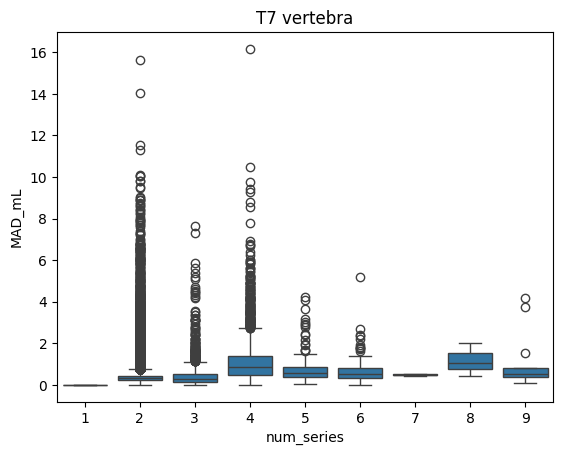

In [ ]:
# Now create a seaborn plot per region

region_and_laterality_list = list(set(df_plot_mad_all['region_and_laterality'].values))

output_directory = "/content/plots_within_study"
if not os.path.isdir(output_directory):
  os.mkdir(output_directory)

for n in range(0,len(region_list)):
  df_plot = df_plot_mad_all[df_plot_mad_all['region_and_laterality']==region_and_laterality_list[n]]
  output_filename = os.path.join(output_directory, region_and_laterality_list[n].replace(" ", "_") + ".png")
  print(output_filename)
  # create_bokeh_plot_within_study(df_plot, output_filename)
  # create_bokeh_plot_within_study_include_num_series(df_plot, output_filename)

  plt.figure()
  boxplot = sns.boxplot(data=df_plot, x="num_series", y="MAD_mL")
  boxplot.figure.savefig(output_filename)
  plt.title(region_and_laterality_list[n])



In [ ]:
# Now create a bokeh plot per region -- this probably won't work with the entire dataset!

region_and_laterality_list = list(set(df_plot_mad_all['region_and_laterality'].values))

output_directory = "/content/plots_within_study_bokeh"
if not os.path.isdir(output_directory):
  os.mkdir(output_directory)

for n in range(0,len(region_list)):
  df_plot = df_plot_mad_all[df_plot_mad_all['region_and_laterality']==region_and_laterality_list[n]]
  output_filename = os.path.join(output_directory, region_and_laterality_list[n].replace(" ", "_") + ".html")
  print(output_filename)
  # create_bokeh_plot_within_study(df_plot, output_filename)
  create_bokeh_plot_within_study_include_num_series(df_plot, output_filename)

/content/plots_within_study_bokeh/T7_vertebra.html


In [ ]:
list(set(df_plot['laterality'].values))

['Left']

In [ ]:
list(set(df_plot_mad_all['region_and_laterality'].values))

['Lower lobe of lung Right', 'Lower lobe of lung Left']

## Within-patient consistency

In [ ]:
# region_list = ["Lower lobe of lung", "Lower lobe of lung", "Spleen", "Liver", "L1 vertebra", "T7 vertebra"]
# laterality_list = ["Left", "Right", None, None, None, None]

# region_list = ["Spleen"]
# laterality_list = [None]

region_list = ["Lower lobe of lung", "Lower lobe of lung"]
laterality_list = ["Left", "Right"]

# region_list = ["T7 vertebra"]
# laterality_list = [None]

# feature = "Volume"
feature = "Volume from Voxel Summation"
# table_id = "idc-external-025.terra.nlst-126k-measurements-clinical-acquisition"

In [ ]:
num_regions = len(region_list)

df_plot_mad_all = pd.DataFrame()

for n in range(0,num_regions):

  region = region_list[n]
  laterality = laterality_list[n]
  print('***** region: ' + str(region) + ', laterality: ' + str(laterality) + ' *****')

  if (laterality is None):
    print('laterality is None')
    df_plot = query_for_within_study_no_laterality(region, feature, table_id, project_name)
  else:
    print('laterality is Left or Right')
    df_plot = query_for_within_study_with_laterality(region, laterality, feature, table_id, project_name)

  # First divide by 1000
  df_plot['Value'] = [np.float32(f)/1000.00 for f in df_plot['Value'].values]

  # For each patient, group by and get the median
  median_volumes = df_plot.groupby('PatientID')['Value'].median()
  median_volumes_df = median_volumes.reset_index()
  median_volumes_df.columns = ['PatientID', 'Median']

  # Also get the count of the number of series per patient
  num_series = df_plot.groupby('PatientID')['sourceSegmentedSeriesUID'].count()
  num_series_df = num_series.reset_index()
  num_series_df.columns = ['PatientID', 'num_series']

  # Now add the median value as a column to the original dataframe
  df_plot2 = df_plot.merge(median_volumes_df, on='PatientID', how='inner')

  # Now add the number of series as a column to the dataframe
  df_plot2 = df_plot2.merge(num_series_df, on='PatientID', how='inner')

  # Set the datatype
  df_plot2['Median'] = [np.float32(f) for f in df_plot2['Median'].values]
  df_plot2['Value'] = [np.float32(f) for f in df_plot2['Value'].values]

  # Now calculate the absolute difference between each value and the median
  df_plot2['Median_minus_Value'] = abs(df_plot2['Median'].values - df_plot2['Value'].values)

  # Now get the median value of the absolute differences
  median_volumes2 = df_plot2.groupby('PatientID')['Median_minus_Value'].median()
  median_volumes_df2 = median_volumes2.reset_index()
  median_volumes_df2.columns = ['PatientID', 'MAD']

  # Now add to final dataframe
  df_plot_mad = df_plot2.merge(median_volumes_df2, on='PatientID', how='inner')

  # Divide by 1000.00 to get mL values
  # df_plot_mad['MAD_mL'] = df_plot_mad['MAD'].values / 1000.00
  df_plot_mad['MAD_mL'] = df_plot_mad['MAD'].values

  # Now just keep one row per study
  # df_plot_mad = df_plot_mad.drop_duplicates(subset=['PatientID'], keep='first', inplace=False, ignore_index=False)

  # Now just keep a subset of the columns
  # df_plot_mad = df_plot_mad[['PatientID', 'StudyInstanceUID', 'MAD_mL', 'num_series']]
  df_plot_mad = df_plot_mad[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'MAD_mL', 'num_series', 'Median_minus_Value']]

  # # Now keep a single row per patient - where the series has the maximum deviation
  # median_minus_value = df_plot_mad.groupby('PatientID')['Median_minus_Value'].max()
  # median_minus_value_df = median_minus_value.reset_index()
  # median_minus_value_df.columns = ['PatientID', 'Median_minus_Value']
  # # Add to final dataframe
  # df_plot_mad

  # order so that the series with the maximum Median_minus_Value is first for each patient
  df_plot_mad = df_plot_mad.sort_values(by=['PatientID', 'Median_minus_Value'], ascending=[True, False])
  # Then drop duplicate rows, but keep first, which is the maximum Median_minus_Value
  df_plot_mad = df_plot_mad.drop_duplicates(subset=['PatientID'], keep='first', inplace=False, ignore_index=False)

  # Redo the viewer_url
  df_plot_mad['viewer_url'] = [os.path.join('https://viewer.imaging.datacommons.cancer.gov/viewer',f) for f in df_plot_mad['StudyInstanceUID'].values]
  # This viewer_url will be for the series that has the maximum deviation
  # df_plot_mad['viewer_url'] = [os.path.join('https://viewer.imaging.datacommons.cancer.gov/viewer',
  #                                           study,
  #                                           '?seriesInstanceUID=' + series)
  #                             for (study,series) in zip(df_plot_mad['StudyInstanceUID'].values, df_plot_mad['sourceSegmentedSeriesUID'])]


  # df_plot_mad

  # Now create a column with the region value and laterality
  df_plot_mad['region'] = [region] * len(df_plot_mad)
  df_plot_mad['laterality'] = [laterality] * len(df_plot_mad)
  # Combine
  if (laterality is None):
    df_plot_mad['region_and_laterality'] = region
  else:
    df_plot_mad['region_and_laterality'] = region + ' ' + laterality

  # Concatenate with the df_plot_mad_all dataframe
  df_plot_mad_all = pd.concat([df_plot_mad_all, df_plot_mad])


***** region: Spleen, laterality: None *****
laterality is None


In [ ]:
df_plot_mad.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,MAD_mL,num_series,Median_minus_Value,viewer_url,region,laterality,region_and_laterality
0,100002,1.2.840.113654.2.55.89933508291954731667890414...,1.2.840.113654.2.55.28339941871125297613155717...,1.966415,2,1.966415,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
6,100004,1.2.840.113654.2.55.32767037256259970220543212...,1.2.840.113654.2.55.79318439085250760439172236...,3.799889,6,8.203186,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
8,100005,1.2.840.113654.2.55.10251457513072085864761297...,1.2.840.113654.2.55.17324290215190661437113320...,0.000000,1,0.000000,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
9,100009,1.2.840.113654.2.55.11394555528208855253894081...,1.2.840.113654.2.55.16322301212762389807484918...,0.000000,1,0.000000,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
11,100010,1.2.840.113654.2.55.23646793050031342184766275...,1.2.840.113654.2.55.27999941063664947063743729...,1.124420,3,28.761200,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen


In [ ]:
df_plot_mad[df_plot_mad['PatientID']=='122217']

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,MAD_mL,num_series,Median_minus_Value,viewer_url,region,laterality,region_and_laterality
19520,122217,1.2.840.113654.2.55.33453783982534511154515073...,1.2.840.113654.2.55.51897087964112185067251248...,182.084229,2,182.084244,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen


/content/plots_within_patient/Spleen.png


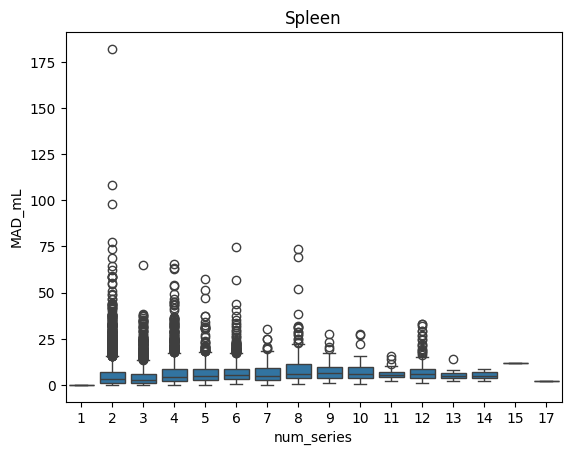

In [ ]:
# Now create a seaborn plot per region

region_and_laterality_list = list(set(df_plot_mad_all['region_and_laterality'].values))

output_directory = "/content/plots_within_patient"
if not os.path.isdir(output_directory):
  os.mkdir(output_directory)

for n in range(0,len(region_list)):
  df_plot = df_plot_mad_all[df_plot_mad_all['region_and_laterality']==region_and_laterality_list[n]]
  output_filename = os.path.join(output_directory, region_and_laterality_list[n].replace(" ", "_") + ".png")
  print(output_filename)
  # create_bokeh_plot_within_study(df_plot, output_filename)
  # create_bokeh_plot_within_study_include_num_series(df_plot, output_filename)

  plt.figure()
  boxplot = sns.boxplot(data=df_plot, x="num_series", y="MAD_mL")
  boxplot.figure.savefig(output_filename)
  plt.title(region_and_laterality_list[n])



In [ ]:
df_plot_mad_all.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,MAD_mL,num_series,Median_minus_Value,viewer_url,region,laterality,region_and_laterality
0,100002,1.2.840.113654.2.55.89933508291954731667890414...,1.2.840.113654.2.55.28339941871125297613155717...,1.966415,2,1.966415,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
6,100004,1.2.840.113654.2.55.32767037256259970220543212...,1.2.840.113654.2.55.79318439085250760439172236...,3.799889,6,8.203186,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
8,100005,1.2.840.113654.2.55.10251457513072085864761297...,1.2.840.113654.2.55.17324290215190661437113320...,0.000000,1,0.000000,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
9,100009,1.2.840.113654.2.55.11394555528208855253894081...,1.2.840.113654.2.55.16322301212762389807484918...,0.000000,1,0.000000,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
11,100010,1.2.840.113654.2.55.23646793050031342184766275...,1.2.840.113654.2.55.27999941063664947063743729...,1.124420,3,28.761200,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen


In [ ]:
# Spleen - get the max for where series=2

df_plot_spleen = df_plot_mad_all[df_plot_mad_all['region_and_laterality']=="Spleen"]
df_plot_spleen_num_series_2 = df_plot_spleen[df_plot_spleen['num_series'] == 2]
df_plot_spleen_num_series_2 = df_plot_spleen_num_series_2.sort_values(by='MAD_mL', ascending=False)

In [ ]:
df_plot_spleen_num_series_2.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,MAD_mL,num_series,Median_minus_Value,viewer_url,region,laterality,region_and_laterality
19520,122217,1.2.840.113654.2.55.33453783982534511154515073...,1.2.840.113654.2.55.51897087964112185067251248...,182.084229,2,182.084244,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
10668,112119,1.2.840.113654.2.55.21591360185161848228430311...,1.2.840.113654.2.55.92409694657334429179098357...,108.397758,2,108.397758,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
10620,112071,1.2.840.113654.2.55.27293463985685925693831086...,1.2.840.113654.2.55.86563454444893379252823517...,98.139091,2,98.139099,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
40554,210578,1.3.6.1.4.1.14519.5.2.1.7009.9004.113089867471...,1.3.6.1.4.1.14519.5.2.1.7009.9004.318890634461...,77.253784,2,77.253784,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
21947,124928,1.2.840.113654.2.55.12691286604737095797908392...,1.2.840.113654.2.55.20320443717992439529689502...,73.312836,2,73.312836,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen


In [ ]:
# Order by number of series
df_plot_spleen = df_plot_mad_all[df_plot_mad_all['region_and_laterality']=="Spleen"]
df_plot_spleen = df_plot_spleen.sort_values(by=['num_series', 'PatientID'], ascending=False)
df_plot_spleen.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,MAD_mL,num_series,Median_minus_Value,viewer_url,region,laterality,region_and_laterality
8059,109031,1.2.840.113654.2.55.21751042095110679757141782...,1.2.840.113654.2.55.43756378604924323358316884...,1.890167,17,10.204071,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
38051,208040,1.3.6.1.4.1.14519.5.2.1.7009.9004.141051721453...,1.3.6.1.4.1.14519.5.2.1.7009.9004.152015072425...,11.784943,15,19.891891,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
5272,105915,1.2.840.113654.2.55.19069851670599187839241633...,1.2.840.113654.2.55.26869081279589758981046604...,8.672249,14,19.800278,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
3711,104138,1.2.840.113654.2.55.28351634261861389125186238...,1.2.840.113654.2.55.33639338145615585674064710...,2.227943,14,6.147339,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen
2389,102744,1.2.840.113654.2.55.80585610761941749641341858...,1.2.840.113654.2.55.22073632085069847331680360...,4.756954,14,16.387878,https://viewer.imaging.datacommons.cancer.gov/...,Spleen,None,Spleen


In [ ]:
# Now create a bokeh plot per region -- this probably won't work with the entire dataset!

region_and_laterality_list = list(set(df_plot_mad_all['region_and_laterality'].values))

output_directory = "/content/plots_within_patient_bokeh"
if not os.path.isdir(output_directory):
  os.mkdir(output_directory)

for n in range(0,len(region_list)):
  df_plot = df_plot_mad_all[df_plot_mad_all['region_and_laterality']==region_and_laterality_list[n]]
  output_filename = os.path.join(output_directory, region_and_laterality_list[n].replace(" ", "_") + ".html")
  print(output_filename)
  # create_bokeh_plot_within_study(df_plot, output_filename)
  create_bokeh_plot_within_study_include_num_series(df_plot, output_filename)

/content/plots_within_patient_bokeh/Spleen.html


# OLD - Part 2 - Anatomical consistency - within patient

Here we divide into within patient and within study consistency.

Linear mixed effects - one takes into account patient, and one takes into account study??



In [ ]:
# Within study consistency

region = "T1 vertebra"
feature = "Volume from Voxel Summation"

df_plot_region_0 = get_organ_feature(region, feature, table_id, project_name)
df_plot_region_0['Value'] = [np.float32(f)/1000.00 for f in df_plot_region_0['Value'].values]
df_plot_region_0['filter_status'] = ['original'] * len(df_plot_region_0)

df_plot_region_1 = get_organ_feature_with_segmentation_completeness_no_laterality(region, feature, table_id, project_name)
df_plot_region_1['Value'] = [np.float32(f)/1000.00 for f in df_plot_region_1['Value'].values]
df_plot_region_1['filter_status'] = ['with_filters'] * len(df_plot_region_1)

df_plot_region = pd.concat([df_plot_region_0, df_plot_region_1])

In [ ]:
df_plot_region.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value,laterality,filter_status,segmentation_completeness_check
0,132286,1.2.840.113654.2.55.69571713245519885935137963...,1.2.840.113654.2.55.10000830183123495604835259...,72,M,T1 vertebra,21.268555,None,original,NaN
1,107764,1.2.840.113654.2.55.17158622996185378565487542...,1.2.840.113654.2.55.10000850533416322553665072...,56,M,T1 vertebra,27.758832,None,original,NaN
2,128370,1.2.840.113654.2.55.26576277676425799146847962...,1.2.840.113654.2.55.10000944692524986099312741...,69,F,T1 vertebra,9.293231,None,original,NaN
3,129659,1.2.840.113654.2.55.14224315431907123431252487...,1.2.840.113654.2.55.10001102480903211454943302...,59,M,T1 vertebra,13.276914,None,original,NaN
4,123560,1.2.840.113654.2.55.19994432989699494147310497...,1.2.840.113654.2.55.10001275412896145078730823...,56,F,T1 vertebra,13.692276,None,original,NaN


[Text(0.5, 0, 'Original vs with filters'),
 Text(0, 0.5, 'Standard deviation of volumes in mL')]

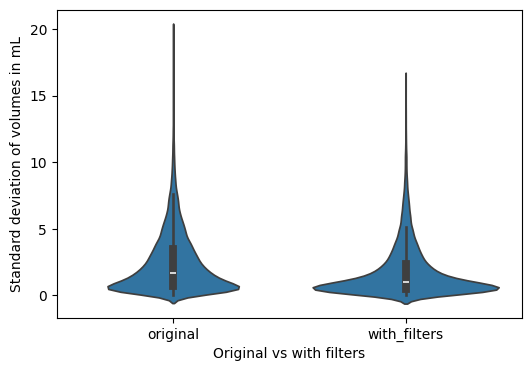

In [ ]:
# Violin plot of the standard deviation values, before and after the heuristics

df_plot_region_stddev = df_plot_region.copy(deep=True)

# For each study, group by and get the median
median_volumes = df_plot_region_stddev.groupby('PatientID')['Value'].median()
median_volumes_df = median_volumes.reset_index()
median_volumes_df.columns = ['PatientID', 'Median']

# For each study, group by and get the standard deviation
stddev_volumes = df_plot_region_stddev.groupby('PatientID')['Value'].std()
stddev_volumes_df = stddev_volumes.reset_index()
stddev_volumes_df.columns = ['PatientID', 'Stddev']

# Now add the median value and stddev value as a column to the original dataframe
df_temp = df_plot_region_stddev.merge(median_volumes_df, on='PatientID', how='inner')
df_temp = df_temp.merge(stddev_volumes_df, on='PatientID', how='inner')

df_plot_region_stddev = df_temp.copy(deep=True)

# # Set the datatype
# df_temp['Median'] = [np.float32(f) for f in df_temp['Median'].values]
# df_temp['Stddev'] = [np.float32(f) for f in df_temp]
# df_temp['Value'] = [np.float32(f) for f in df_temp['Value'].values]

# only keep first row of each patient
df_plot_region_stddev_patient = df_plot_region_stddev.copy(deep=True)
df_plot_region_stddev_patient = df_plot_region_stddev.drop_duplicates(subset=['PatientID', 'filter_status'], keep='first')

plt.figure(figsize=(6,4))
ax = sns.violinplot(data=df_plot_region_stddev_patient, x="filter_status", y="Stddev")
ax.set(xlabel='Original vs with filters', ylabel='Standard deviation of volumes in mL')

patient_list: ['100002', '100004', '100005', '100009', '100010', '100012', '100014', '100015', '100019', '100020']


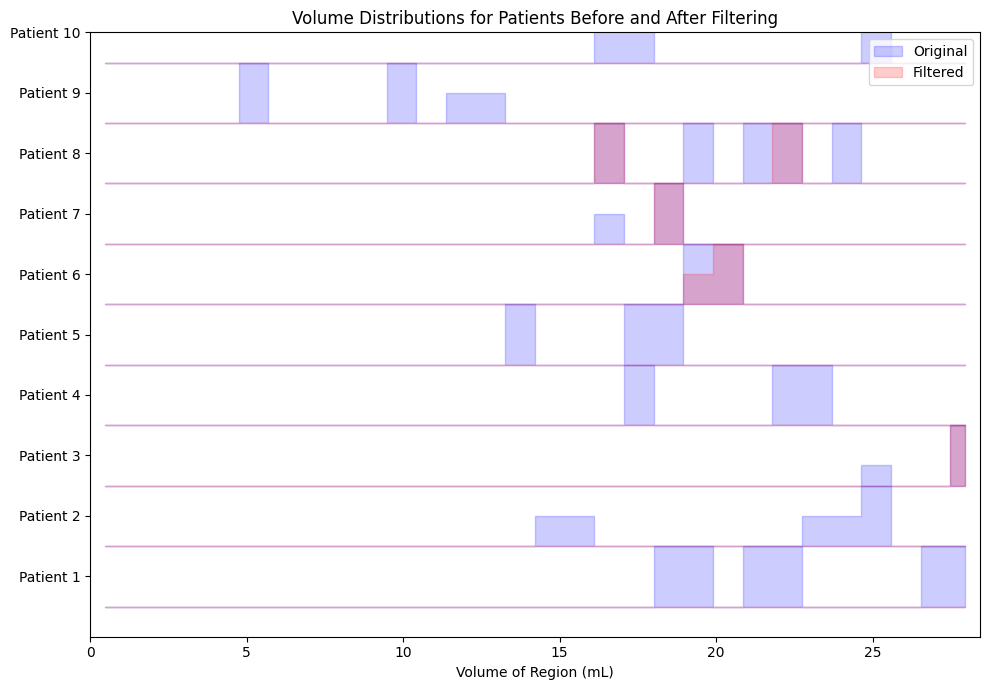

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data generation (replace with your actual data)
np.random.seed(42)
num_patients = 10

# patients = [f'Patient {i+1}' for i in range(num_patients)]
# original_volumes = [np.random.normal(1000 + i * 50, 200, 100) for i in range(num_patients)]
# filtered_volumes = [vols * np.random.uniform(0.9, 1.1, size=100) for vols in original_volumes]
patients = [f'Patient {i+1}' for i in range(num_patients)]
patient_list_original = sorted(list(set(df_plot_region_0['PatientID'].values)))
patient_list_filtered = sorted(list(set(df_plot_region_1['PatientID'].values)))
patient_list = list(set(patient_list_original) & set(patient_list_filtered))[0:num_patients]
patient_list = sorted(list(set(df_plot_region_0['PatientID'].values)))[0:num_patients]
print('patient_list: ' + str(patient_list))
original_volumes = []
filtered_volumes = []
for n in range(0,num_patients):
  original_volumes_patient = df_plot_region_0[df_plot_region_0['PatientID']==patient_list[n]]['Value'].values
  filtered_volumes_patient = df_plot_region_1[df_plot_region_1['PatientID']==patient_list[n]]['Value'].values
  original_volumes.append(original_volumes_patient)
  filtered_volumes.append(filtered_volumes_patient)


# Parameters for the plot
num_bins = 30
# hist_range = (0, 2000)
hist_range = (0, np.max(np.concatenate(original_volumes)))
bar_width = hist_range[1] / num_bins

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Set the background color of the figure to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot histograms for each patient
for i, (orig_vols, filt_vols) in enumerate(zip(original_volumes, filtered_volumes)):
    # Calculate histograms
    orig_hist, bins = np.histogram(orig_vols, bins=num_bins, range=hist_range)
    filt_hist, _ = np.histogram(filt_vols, bins=bins)

    # Normalize histograms
    orig_hist = orig_hist / orig_hist.max() if orig_hist.max() != 0 else orig_hist
    filt_hist = filt_hist / filt_hist.max() if filt_hist.max() != 0 else filt_hist

    # Calculate bin centers
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Calculate vertical offset for each patient
    offset = i

    # Plot histograms using fill_between to avoid affecting background
    ax.fill_between(bin_centers, offset, orig_hist + offset, step='mid', color='blue', alpha=0.2, label='Original' if i == 0 else "")
    ax.fill_between(bin_centers, offset, filt_hist + offset, step='mid', color='red', alpha=0.2, label='Filtered' if i == 0 else "")

    # Add patient label on the y-axis
    # ax.text(hist_range[1] + 10, offset + 0.5, patients[i], va='center', ha='left')

# Adding labels and legend
ax.set_xlabel('Volume of Region (mL)')
ax.set_title('Volume Distributions for Patients Before and After Filtering')
ax.legend(loc='upper right')

# Set the x-axis limits
ax.set_xlim(hist_range)

# Ensure each row is distinct by setting y-axis limits and removing y-axis labels
ax.set_ylim(-0.5, num_patients - 0.5)
ax.set_yticks(np.arange(num_patients) + 0.5)
ax.set_yticklabels(patients)

# Set y-ticks to be empty since we are labeling with patient names
ax.set_yticks(np.arange(num_patients) + 0.5)
ax.set_yticklabels(patients)

plt.tight_layout()
plt.show()


In [ ]:
# add in url
df_plot_region_stddev_patient['viewer_url'] = [os.path.join("https://viewer.imaging.datacommons.cancer.gov/viewer",f) for f in df_plot_region_stddev_patient['StudyInstanceUID'].values]

In [ ]:
def create_bokeh_plot_before_and_after_heuristics(df_plot, output_filename):
  """ This function creates a bokeh plot for the particular structure and
      distance metric

      Inputs:
        df_plot   : a dataframe containing the columns: StudyInstanceUID, region, MAD_mL, viewer_url

      Outputs:
        creates a bokeh plot in the notebook
  """

  # output_notebook()

  # set the seed so jitter will be the same for each run
  np.random.seed(0)
  random.seed(0)

  # sort the rows
  df_plot = df_plot.sort_values(by=['filter_status']) # want alphabetical order

  # Get a color for each region
  colormap, colors = color_list_generator(df_plot, 'filter_status')
  df_plot['colors'] = colors
  colormap_list_keys = list(colormap.keys())

  regions = colormap_list_keys
  colors = list(colormap.values())

  hover = HoverTool(tooltips=[
      ("(Stddev)", "($y)")
  ])

  wZoom = WheelZoomTool()
  bZoom = BoxZoomTool()
  reset = ResetTool()
  tap = TapTool()
  pan = PanTool()

  cats = regions

  cats2 = []
  for c in range(0,len(cats)):
    cats2.append(cats[c])
    cats2.append(cats[c]+"_boxplot")
  regions = cats2

  colors2 = []
  for c in range(0,len(colors)):
    colors2.append(colors[c])
    colors2.append(colors[c])

  p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
            x_range=regions,
            title="Stddev")

  # l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
  # l1 = p1.circle(y='distance', x='model', source=df_plot, alpha=1, color='colors')
  # https://stackoverflow.com/questions/64942935/jitter-in-scatterplot-for-non-numeric-x-axis
  def jitter(x):
      # return x + random.uniform(0, .5) -.25
      return x + random.uniform(0, 0.5) + 0.5
  type_ids = dict()
  for n in range(0,len(colormap_list_keys)):
    type_ids[colormap_list_keys[n]] = (n*2)
  df_plot['filter_status_id'] = df_plot['filter_status'].apply(lambda x:type_ids[x])
  df_plot['jitter_type'] = df_plot['filter_status_id'].apply(lambda x: jitter(x))
  l1 = p1.circle(y='Stddev',x='jitter_type',source=df_plot, alpha=1, color='colors')

  legend = Legend(items=[LegendItem(label=dict(field="filter_status"), renderers=[l1])])
  p1.add_layout(legend, 'below')

  ### Include the box plots ###
  # find the quartiles and IQR for each category

  df_plot2 = df_plot.copy(deep=True)
  df_plot2['filter_status2'] = [f + '_boxplot' for f in df_plot['filter_status'].values]

  # regions are in order we want
  category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
  df_plot2['filter_status2'] = df_plot2['filter_status2'].astype(category_experiment)

  # groups = df_plot.groupby('experiment')
  groups = df_plot2.groupby('filter_status2')
  q1 = groups.quantile(q=0.25,numeric_only=True)
  q2 = groups.quantile(q=0.5, numeric_only=True)
  q3 = groups.quantile(q=0.75, numeric_only=True)
  iqr = q3 - q1
  upper = q3 + 1.5*iqr
  lower = q1 - 1.5*iqr

  # Form the source data to call vbar for upper and lower
  # boxes to be formed later.
  upper_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q2.Stddev,
      top=q3.Stddev,
      fill_color=colors2,
      legend=cats2
  ))

  lower_source = ColumnDataSource(data=dict(
      x=cats2,
      bottom=q1.Stddev,
      top=q2.Stddev,
      fill_color=colors2
  ))

  # stems (Don't need colors of treatment)
  p1.segment(cats2, upper.Stddev, cats2, q3.Stddev, line_color="black")
  p1.segment(cats2, lower.Stddev, cats2, q1.Stddev, line_color="black")

  # Add the upper and lower quartiles
  l2=p1.vbar(source = upper_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
  p1.vbar(source = lower_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

  # whiskers (almost-0 height rects simpler than segments)
  p1.rect(cats2, lower.Stddev, 0.2, 0.000001, line_color="black") # was 0.01
  p1.rect(cats2, upper.Stddev, 0.2, 0.000001, line_color="black")

  # Using the newer autogrouped syntax.
  # Grab a renderer, in this case upper quartile and then
  # create the legend explicitly.
  # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
  # legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
  # p1.add_layout(legend, 'below')

  # Setup plot titles and such.
  # p1.title.text = str(column_name_distance) + '_' + str(structure_name)
  p1.xgrid.grid_line_color = None
  p1.ygrid.grid_line_color = "white"
  p1.grid.grid_line_width = 2
  p1.xaxis.major_label_text_font_size="0pt"
  p1.xaxis.major_label_orientation = np.pi/4
  p1.xaxis.axis_label = 'Filter status'
  # p1.yaxis.axis_label = column_name_distance
  p1.legend.location = (100,10)

  p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
  p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

  url="@viewer_url"
  taptool = p1.select(type=TapTool)
  taptool.callback = OpenURL(url=url)

  # show(p1)
  # output_file(output_filename,mode='inline')

  show(p1)
  output_file(output_filename)
  save(p1)

  return



In [ ]:
# Bokeh plot of the standard deviation values, before and after the heuristics

create_bokeh_plot_before_and_after_heuristics(df_plot_region_stddev_patient, '/content/within_patient_before_after_heuristics.html')

In [ ]:
# Linear mixed effects of the raw volumes, before and after heuristics

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit linear mixed-effects model
mixed_model = smf.mixedlm("Value ~ filter_status", df_plot_region_stddev, groups=df_plot_region_stddev["PatientID"])
mixed_results = mixed_model.fit()

# Print summary of results
print(mixed_results.summary())

print(mixed_results.pvalues[1]) # significant difference

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Value       
No. Observations:      149409       Method:                  REML        
No. Groups:            26192        Scale:                   9.8131      
Min. group size:       1            Log-Likelihood:          -415962.2021
Max. group size:       36           Converged:               Yes         
Mean group size:       5.7                                               
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     20.487    0.032 648.657 0.000 20.425 20.549
filter_status[T.with_filters]  1.145    0.025  45.733 0.000  1.096  1.194
Group Var                     23.604    0.079                            

0.0


# OLD - Num series per study

In [ ]:
client = bigquery.Client(project=project_name)

query = f"""

  SELECT
    COUNT(DISTINCT(clinical_table.sourceSegmentedSeriesUID)) as num_series,
    clinical_table.StudyInstanceUID,
  FROM
    `{table_id}` as clinical_table
  GROUP BY
    clinical_table.StudyInstanceUID

  """
df_series_counts = client.query(query).to_dataframe()

In [ ]:
df_series_counts.head()

,num_series,StudyInstanceUID
0,5,1.2.840.113654.2.55.31980143031712550390292551...
1,5,1.2.840.113654.2.55.70170168938577976462574384...
2,6,1.3.6.1.4.1.14519.5.2.1.7009.9004.132558092716...
3,5,1.2.840.113654.2.55.33809284049151718496749777...
4,5,1.2.840.113654.2.55.35562799563470306641698002...


In [ ]:
len(df_series_counts)

71661

Text(0, 0.5, 'Number of series per study')

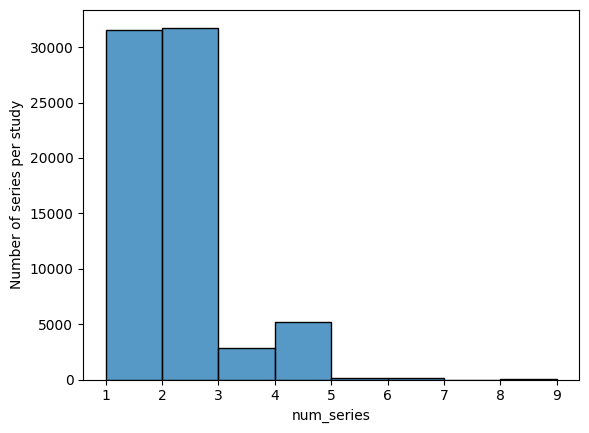

In [ ]:
ax = sns.histplot(df_series_counts, x='num_series', bins=8)
plt.ylabel('Number of series per study')
